In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [2]:
def component_mahalanobis_distances(GMmodel):
    """
    input = sklearn Gaussian mixture model
    output = matrix of mahalanobis distances between means of Gaussian components
    """
    no_components = GMmodel.means_.shape[0]
    GM_comp_mahal_distances = np.zeros((no_components,no_components))
    for comp1_ind, comp1 in enumerate(GMmodel.means_):
        for comp2_ind, comp2 in enumerate(GMmodel.means_):
            GM_comp_mahal_distances[comp1_ind, comp2_ind] = distance.mahalanobis(comp1, comp2, np.linalg.inv(GMmodel.covariances_[comp2_ind]))
            print(comp1_ind, comp2_ind)
            clear_output(wait=True)
    return GM_comp_mahal_distances

def merge_gaussian_component_labels(distance_matrix, observation_labels, sigma_threshold):
    """
        if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, relabel the data within
    those components as belonging to a new, single cluster
    
    input:
        distance_matrix - square matrix containing distances between Gaussian component means, output of component_mahalanobis_distances function
        observation_labels - list of data labels corresponding to the Gaussian components
        sigma_threshold - threshold for the merger of Gaussian components. If distances between two component means are less then the threshold,
        (both when calculating from A to B and from B to A), the components will be treated as one cluster.
                            
    output
        new_observation_labels - modified observation_labels, where a new index was created for merged components, and both component indices were
        replaced with that new index
    

    uses the graph solution from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
    """
    # find pairs of components whose means are separated by mahalanobis distance smaller than the threshold (both ways)
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    new_observation_labels = observation_labels
    # merge components
    for n_connection, connection in enumerate(connected_components(G)):
        node_indices=np.array([int(node) for node in connection])
#         new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
#                                           n_connection+np.unique(observation_labels).shape[0], new_observation_labels)
        new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
                                          node_indices[0], new_observation_labels)
        
    return new_observation_labels


def grid_search_classification(data_labels, data, train_set_ids, val_set_ids, seg_ObIDs):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
    
#     comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    
    
    # training data
    train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
    # validation data
    val_data = obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"]
            
    #random forest hyperparameters
#     n_estimators_list = [50, 100, 300, 500] # 100
    max_depth_list = [None, 5, 10, 15, 25] # None
#     min_samples_split_list = [2, 5, 10, 15] # 2
#     min_samples_leaf_list = [1, 2, 5, 10] # 1   
    criterion_list= ["entropy", 'gini']

    reports = []
    
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for random_state in range(100):
                RF_clf = RandomForestClassifier(random_state=random_state,
                                                criterion=criterion,
                                                class_weight="balanced",
                                                n_estimators=100,
                                                max_depth=max_depth, 
                                                min_samples_split= 2,
                                                min_samples_leaf = 1
                                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
                preds = RF_clf.predict(val_data.iloc[:,:-1])

                reports.append((precision_recall_fscore_support(val_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                                accuracy_score(val_data.iloc[:,-1], preds),
                               (criterion,max_depth, random_state)))
    return reports


def test_classification(data_labels, data, train_set_ids, test_set_ids,
                                                    n_estimators=50,
                                                    max_depth=5, 
                                                    min_samples_split=15,
                                                    min_samples_leaf = 1):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
    
#     comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    
    
    # training data
    train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
    # validation data
    test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]
            

    RF_clf = RandomForestClassifier(random_state=0,
                                    class_weight="balanced",
                                    n_estimators=n_estimators,
                                    max_depth=max_depth, 
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf = min_samples_leaf
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    return (precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                    accuracy_score(test_data.iloc[:,-1], preds))

def merge_gaussian_return_component_sets(distance_matrix, observation_labels, sigma_threshold):
    """
    if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, return these components in a list
    """
    # merge components within 3 sigma
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    data_labels = observation_labels
    
    list_connected_components=[]
    for set_comps in connected_components(G):
        list_connected_components.append(set_comps)

    return list_connected_components



# 1 second cadence data

In [3]:
# load light curve segments
with open('{}/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-24_13-14-02.h5"
segments_dir = '../../../data_GRS1915/474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 20 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [4]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [5]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [6]:
with open('{}/474471_len128_stride10_1sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [7]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_222comps_model_2020-12-24_13-14-02_segments_474471_len128_stride10_1sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_1s = pickle.load(f)

# find clusters for the data
GMmodel_1s_labels = GMmodel_1s.predict(shape_moments)

In [8]:
# calculate mahalanobis distances between components
# GM_comp_mahal_distances_1s = component_mahalanobis_distances(GMmodel_1s)

# with open("GM_comp_mahal_distances_1s.pkl", 'wb') as f:
#     pickle.dump(GM_comp_mahal_distances_1s, f)

with open('GM_comp_mahal_distances_1s.pkl', 'rb') as f:
    GM_comp_mahal_distances_1s = pickle.load(f)

In [365]:
no_components_premerger = np.unique(GMmodel_1s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_1s_100rng_criterion_depth_fixed_mergers.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

59 5.0


In [10]:
with open('sigmas100_reports_list_1s_100rng_criterion_depth_fixed_mergers.pkl', 'rb') as f:
    sigma_reports_list = pickle.load(f)

In [11]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [12]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]

In [17]:
np.unique(merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.91)).shape

(180,)

In [ ]:
[2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]

In [90]:
test_classification(merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.91), 
                    shape_moments, split_ob_ids[0], split_ob_ids[1],
                                                    n_estimators=100,
                                                    max_depth=10, 
                                                    min_samples_split=2,
                                                    min_samples_leaf = 1)
# (0.9185410334346504, 0.9361702127659575)

(0.7638694638694639, 0.8181818181818182)

In [307]:
# [2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]
results = []

n_estimators=50
max_depth=None
min_samples_split=10
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.9141414141414144)
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v



# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

for test_iter in range(1000):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    n_estimators=1000,
                                    max_depth=10, 
                                    min_samples_split=2,
                                    min_samples_leaf = 1
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

KeyboardInterrupt: 

In [308]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.9197354030483809 0.008215337526324746 0.9377129266568107 0.007602421773849735


In [370]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.9197796106966318 0.009448670505214772 0.9378936170212769 0.00857525998138264


In [310]:
np.unique(merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.9141414141414144)).shape

(180,)

In [30]:

with open('best_testing_results_1s.pkl', 'rb') as f:
    results = pickle.load(f)

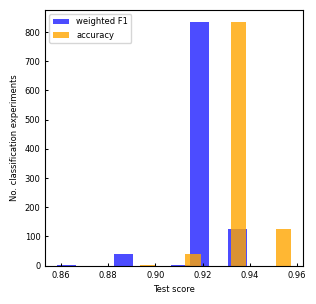

In [99]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(np.array(results)[:,0], bins=10, label="weighted F1", alpha=0.7, color="blue")
plt.hist(np.array(results)[:,1], bins=10, label="accuracy", alpha=0.8, color="orange")
plt.legend(loc="upper left")
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")

# plt.axvline(0.17291455589327928, c="blue", linestyle="--")

# plt.axvline(16/47, c="orange", linestyle="--")

# plt.xlim([0.1,1])
# plt.ylim([0,300])

plt.savefig('figures/classification_histogram_92F1.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [376]:
0.9197796106966318-3*0.009448670505214772

0.8914335991809875

# figures

In [528]:
n_estimators=1000
max_depth=10
min_samples_split=2
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.91)
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[1]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v



# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]


RF_clf = RandomForestClassifier(random_state=16,
                                class_weight="balanced",
                                n_estimators=n_estimators,
                                max_depth=max_depth, 
                                min_samples_split=min_samples_split,
                                min_samples_leaf = min_samples_leaf
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

(0.7002331002331001, 0.7727272727272727)


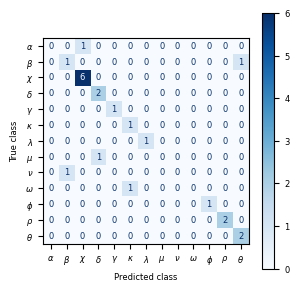

In [529]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
# plt.savefig('figures/classification_matrix_1s_94F1.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [94]:
np.unique(np.array(results)[:,0], return_counts=1)

(array([0.85834331, 0.88780817, 0.88907617, 0.90813914, 0.91854103,
        0.938872  ]),
 array([  1,   3,  38,   1, 833, 124]))

In [109]:
np.argmax(np.array(results)[:,0])

16

In [95]:
np.unique(np.array(results)[:,1], return_counts=1)

(array([0.89361702, 0.91489362, 0.93617021, 0.95744681]),
 array([  1,  41, 834, 124]))

In [515]:
ob_state["20402-01-36-00"]

'lambda'

In [397]:
np.where(np.array(ids)=="40703-01-27-01")

(array([1540]),)

In [251]:
test_data.loc[misclass.index[0]].to_frame().T

1         4  5  6  7  8        10        11 12 13  ... 219  \
40703-01-35-01  0  0.003663  0  0  0  0  0.025641  0.003663  0  0  ...   0   

               220 221       222         223 224 225 226 227 Class  
40703-01-35-01   0   0  0.150183  0.00732601   0   0   0   0  beta  

[1 rows x 181 columns]

In [254]:
np.unique(test_data.iloc[:,-1])

array(['alpha', 'beta', 'chi', 'delta', 'gamma', 'kappa', 'lambda', 'mu',
       'nu', 'omega', 'phi', 'rho', 'theta'], dtype=object)

In [255]:
RF_clf.predict_proba(test_data.loc[misclass.index[1]].to_frame().T.iloc[:,:-1])

array([[0.00868333, 0.29281244, 0.30574381, 0.08104412, 0.02954365,
        0.03519224, 0.02783333, 0.03957788, 0.002     , 0.027     ,
        0.05708572, 0.01846264, 0.07502084]])

In [71]:
precision_recall_fscore_support(np.concatenate((np.ones(16), np.zeros(47-16))), np.ones(47),zero_division=0, average="weighted")

(0.11588954277953825, 0.3404255319148936, 0.17291455589327928, None)

# Classification after 10 validation runs per hyperparameter set
(0.7647785547785549, 0.8181818181818181, (50, None, 10, 1))] 10rng with threshold 1.7142857142857144

In [45]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.860237782183543 0.03594481106613001 0.8847446808510637 0.02958220471283791


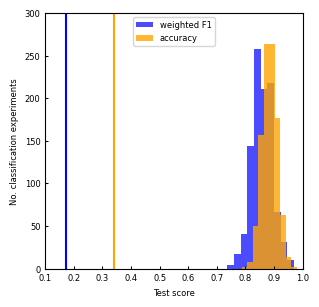

In [49]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(np.array(results)[:,0], bins=10, label="weighted F1", alpha=0.7, color="blue")
plt.hist(np.array(results)[:,1], bins=10, label="accuracy", alpha=0.8, color="orange")
plt.legend(loc="upper center")
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")

plt.axvline(0.17291455589327928, c="blue")

plt.axvline(16/47, c="orange")

plt.xlim([0.1,1])
plt.ylim([0,300])

plt.savefig('figures/classification_histogram_lines_1s_10rng_212merged_components.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [83]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [84]:
new_classification = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 0)

Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

comparison_matrix = np.zeros((len(np.unique(new_classification)), len(Belloni_classes)), dtype=int)

comparison_matrix_df = pd.DataFrame(comparison_matrix, columns=Belloni_classes, index=np.unique(new_classification))

for n_Bc, Belloni_class in enumerate(Belloni_classes):
    Belloni_class_indices = np.where(np.array(segment_class) == Belloni_class)[0]
    count_clusters_for_class = np.unique(np.take(new_classification, Belloni_class_indices), return_counts=True)
    for cluster_ind, cluster in enumerate(count_clusters_for_class[0]):
        comparison_matrix_df[Belloni_class][cluster] = count_clusters_for_class[1][cluster_ind]

In [85]:
class_normalized_comparison_matrix_df=(comparison_matrix_df-comparison_matrix_df.min())/(comparison_matrix_df.max()-comparison_matrix_df.min())
known_comparison_matrix_df = comparison_matrix_df.drop(columns=['Unknown']).T
component_normalized_comparison_matrix_df = (known_comparison_matrix_df-known_comparison_matrix_df.min())/(known_comparison_matrix_df.max()-known_comparison_matrix_df.min())

In [87]:
merged_components  = merge_gaussian_return_component_sets(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.59)

In [88]:
np.unique(merged_components).shape

(8,)

In [86]:
class_normalized_comparison_matrix_df

alpha      beta     gamma  delta     theta  kappa  lambda   mu  \
0    0.000000  0.029478  0.000000    0.0  0.001373    0.0     0.0  0.0   
1    0.000000  0.004535  0.000000    0.0  0.000000    0.0     0.0  0.0   
2    0.009967  0.061224  0.000000    0.0  0.001373    0.0     0.0  0.0   
3    0.004983  0.038549  0.000996    0.0  0.004804    0.0     0.0  0.0   
4    0.001661  0.009070  0.000000    0.0  0.001373    0.0     0.0  0.0   
..        ...       ...       ...    ...       ...    ...     ...  ...   
217  0.003322  0.006803  0.000000    0.0  0.000000    0.0     0.0  0.0   
218  0.000000  0.000000  0.000000    0.0  0.000000    0.0     0.0  0.0   
219  0.004983  0.000000  0.000000    0.0  0.000000    0.0     0.0  0.0   
220  0.000000  0.000000  0.000000    0.0  0.000000    0.0     0.0  0.0   
221  1.000000  0.000000  0.000000    0.0  0.000000    0.0     0.0  0.0   

           nu       rho       phi       chi       eta  omega   Unknown  
0    0.025641  0.000000  0.010370  0.029071  0.006369    0.0  0.245630  
1    0.000000  0.000000  0.000000  0.058560  0.000000    0.0  0.364659  
2    0.051282  0.000000  0.013333  0.032984  0.000000    0.0  0.267676  
3    0.018315  0.000000  0.031111  0.013417  0.000000    0.0  0.164124  
4    0.014652  0.000000  0.001481  0.039273  0.000000    0.0  0.203318  
..        ...       ...       ...       ...       ...    ...       ...  
217  0.010989  0.000000  0.001481  0.027533  0.000000    0.0  0.170694  
218  0.000000  0.515971  0.000000  0.000000  0.000000    0.0  0.059570  
219  0.018315  0.191646  0.000000  0.000000  0.000000    0.0  0.063801  
220  0.000000  0.000000  0.001481  0.000000  0.000000    0.0  0.097762  
221  0.000000  0.000000  0.000000  1.000000  0.101911    0.0  0.175482  

[222 rows x 15 columns]

In [89]:
cluster_centroids = []
centroid_distances=[]
for component in class_normalized_comparison_matrix_df.T.columns.values:
    cluster_centroids.append(GMmodel_1s.means_[component])
for comp_indices in merged_components:
    cluster_centroids.append(np.mean(np.take(GMmodel_1s.means_,list(comp_indices),axis=0),axis=0))
for centroid in cluster_centroids:
    centroid_distances.append(np.sqrt(np.mean((centroid-np.ones(24))**2)))
order_columns = np.take(class_normalized_comparison_matrix_df.T.columns.values, np.argsort(centroid_distances))

IndexError: index 228 is out of bounds for axis 0 with size 222

In [80]:
len(cluster_centroids)

222

In [78]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
def seriation(Z,N,cur_index):
    '''
    https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
    https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
#     seriated_dist = np.zeros((N,N))
#     a,b = np.triu_indices(N,k=1)
#     seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
#     seriated_dist[b,a] = seriated_dist[a,b]
    
    return res_order

In [80]:
no_components = len(cluster_centroids)
GM_comp_euclid_distances = np.zeros((no_components,no_components))
for comp1_ind, comp1 in enumerate(cluster_centroids):
    for comp2_ind, comp2 in enumerate(cluster_centroids):
        GM_comp_euclid_distances[comp1_ind, comp2_ind] = distance.euclidean(comp1, comp2)
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

NameError: name 'cluster_centroids' is not defined

In [79]:
new_cluster_order  = compute_serial_matrix(GM_comp_euclid_distances,method="single") 
new_cluster_order= np.take(class_normalized_comparison_matrix_df.T.columns.values, new_cluster_order)

NameError: name 'GM_comp_euclid_distances' is not defined

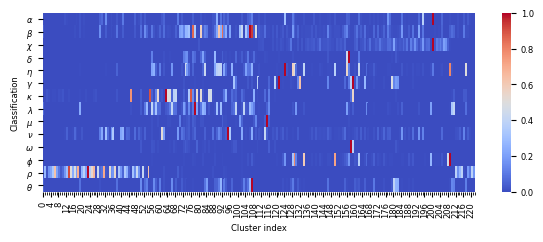

In [883]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True)[new_cluster_order], xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
# # ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 6)
# ax.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="out")

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())

classes_names = class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True).index.values
ax.set_yticklabels([r"$\{}$".format(c) for c in classes_names])

# offset = ScaledTranslation(0.5, 0, ax.transData)

# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)
    
# for label in ax.xaxis.get_minorticklabels():
#     label.set_transform(label.get_transform() + offset)

plt.xlabel("Cluster index")
plt.ylabel("Classification")

# plt.title("Gaussian mixture components' populations in terms of classified data (component-wise min-maxed)")
# plt.savefig("figures/GMM122vsBelloni_heatmap.png", dpi=300)
# plt.savefig('figures/GMM222merged_vsBelloni_heatmap_sorted_fixedmu.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()

In [419]:
class_normalized_comparison_matrix_df.T.iloc[0,:].max() #here

1.0

In [114]:
ids_ar = np.array(segment_class)

phi_stats = np.take(desc_stats, np.where(ids_ar == "phi")[0], axis=0)
chi_stats = np.take(desc_stats, np.where(ids_ar == "chi")[0], axis=0)
gamma_stats = np.take(desc_stats, np.where(ids_ar == "gamma")[0], axis=0)

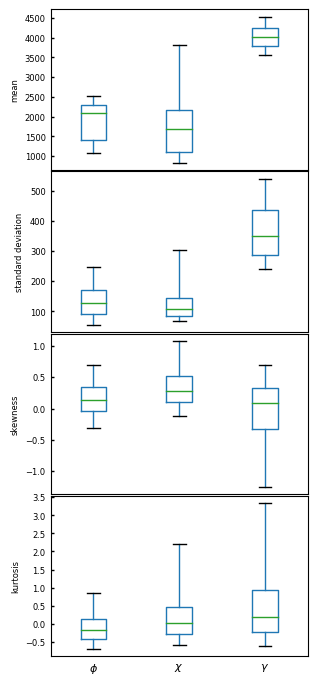

In [116]:
# axes = axes.flatten()


plt.rcParams['figure.figsize'] = (3.32, 8.4)#6.97)
plt.rcParams.update({'font.size': 6})

fig, axes = plt.subplots(nrows=4, ncols=1)

for plot_ind in range(4):
#     light_c = selected_lcs[plot_ind]
    stat_df = pd.DataFrame([phi_stats[:,plot_ind],chi_stats[:,plot_ind],gamma_stats[:,plot_ind]], index = [r"$\{}$".format(x) for x in ["phi", "chi", "gamma"]]).T #r"$\{}$"[r"$\{}$".format(x) for x in ["phi", "chi", "gamma"]]
    stat_df.boxplot(whis=[5,95], sym="", ax=axes[plot_ind], grid=False)
#     axes[plot_ind].tick_params(axis="x", which="major", length=0, width=1, labelsize=0, direction="in")
    axes[plot_ind].tick_params(axis="y", which="major", length=2, width=1, labelsize=6, direction="in")
    if plot_ind != 3:
        axes[plot_ind].set_xticks([])
        axes[plot_ind].set_xticklabels([])
    else:
#         axes[plot_ind].tick_params(axis="x", which="major", length=2, width=1, labelsize=6, direction="in")
        axes[plot_ind].tick_params(axis="x", which="major", length=0, width=1, labelsize=8, direction="in")
        
    axes[plot_ind].set_ylabel(["mean", "standard deviation", "skewness", "kurtosis"][plot_ind])
plt.subplots_adjust(hspace=0.01)
plt.subplots_adjust(wspace=0.01)
# axes.reshape((2,2))
plt.savefig('figures/stat_boxplot_1s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)
# axes[1] = stat_df.boxplot(whis=[1,99], sym="")#plt.gca()
plt.show()

In [48]:
# phi_sifos = np.take(shape_moments, np.where(ids_ar == "phi")[0], axis=0)
# chi_sifos = np.take(shape_moments, np.where(ids_ar == "chi")[0], axis=0)
# gamma_sifos = np.take(shape_moments, np.where(ids_ar == "gamma")[0], axis=0)
rho_sifos = np.take(shape_moments, np.where(ids_ar == "rho")[0], axis=0)


In [39]:
phi_sifos.shape

(4131, 24)

In [33]:
import umap
trans = umap.UMAP(random_state=0).fit(np.vstack((phi_stats,chi_stats)))


/export/data/jakubok/software/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


In [51]:
phi_sifos.shape[0]+ chi_sifos.shape[0]+gamma_sifos.shape[0]

46458

In [49]:
trans_shape_pcgr = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,:20],chi_sifos[:,:20], gamma_sifos[:,:20], rho_sifos[:,:20])))


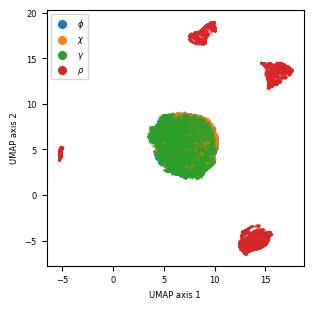

In [86]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})

plt.scatter(trans_shape_pcgr.embedding_[:4131, 0], trans_shape_pcgr.embedding_[:4131, 1],s=0.2,zorder=1, label=r"$\phi$")
plt.scatter(trans_shape_pcgr.embedding_[4131:39870, 0], trans_shape_pcgr.embedding_[4131:39870, 1],s=0.1,zorder=1, label=r"$\chi$")
plt.scatter(trans_shape_pcgr.embedding_[39870:46458, 0], trans_shape_pcgr.embedding_[39870:46458, 1],s=0.1,zorder=1, label=r"$\gamma$")
plt.scatter(trans_shape_pcgr.embedding_[46458:, 0], trans_shape_pcgr.embedding_[46458:, 1],s=0.1,zorder=5, label=r"$\rho$")
lgnd = plt.legend(fontsize=6)

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

plt.savefig('figures/UMAP_SFoS_1s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.05)
# plt.title('Embedding of the training set by UMAP', fontsize=24);
plt.show()

In [56]:
trans_pcgr = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,20:],chi_sifos[:,20:], gamma_sifos[:,20:], rho_sifos[:,20:])))


In [58]:
trans_pcg = umap.UMAP(random_state=0).fit(np.vstack((phi_sifos[:,20:],chi_sifos[:,20:], gamma_sifos[:,20:])))


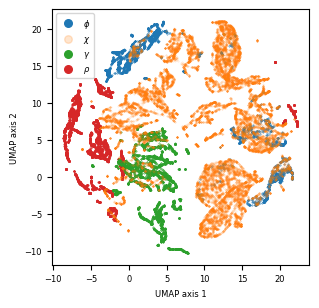

In [80]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})

plt.scatter(trans_pcg.embedding_[:4131, 0], trans_pcg.embedding_[:4131, 1],s=0.1,zorder=2, label=r"$\phi$")
plt.scatter(trans_pcg.embedding_[4131:39870, 0], trans_pcg.embedding_[4131:39870, 1],s=0.1,zorder=5,alpha=0.2, label=r"$\chi$")
plt.scatter(trans_pcg.embedding_[39870:46458, 0], trans_pcg.embedding_[39870:46458, 1],s=0.1,zorder=2, label=r"$\gamma$")
plt.scatter(trans_pcgr.embedding_[46458:, 0], trans_pcgr.embedding_[46458:, 1],s=0.2,zorder=1, label=r"$\rho$")
lgnd = plt.legend(fontsize=6)

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
lgnd.legendHandles[2]._sizes = [30]
lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

plt.savefig('figures/UMAP_IFoS_1s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.05)


plt.show()

# 4 seconds cadence

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [3]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [4]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [5]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_279comps_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_4s = pickle.load(f)

In [6]:
# load light curve segments
with open('{}/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-21_20-11-39.h5"
segments_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [7]:
GMmodel_4s_labels = GMmodel_4s.predict(shape_moments)

In [8]:
# calculate mahalanobis distances between components
GM_comp_mahal_distances_4s = component_mahalanobis_distances(GMmodel_4s)

# with open("GM_comp_mahal_distances_4s.pkl", 'wb') as f:
#     pickle.dump(GM_comp_mahal_distances_4s, f)

276 235


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
with open("GM_comp_mahal_distances_4s.pkl".format(data_dir), 'rb') as f:
    GM_comp_mahal_distances_4s = pickle.load(f)

In [9]:
with open('{}/468202_len128_stride8_4sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [13]:
no_components_premerger = np.unique(GMmodel_4s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_4s_100rng_criterion_depth_fixed_mergers.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

64 4.929292929292929


In [14]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [15]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[3.515151515151515, (0.6852890442890444, 0.7481818181818185, ('gini', 5, 0))]

In [ ]:
results = []

n_estimators=50
max_depth=None
min_samples_split=10
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, 3.515151515151515)
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v



# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

for test_iter in range(1000):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    n_estimators=1000,
                                    max_depth=5, 
                                    min_samples_split=2,
                                    min_samples_leaf = 1
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

517


In [19]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.7644067955929645 0.015224280121196 0.8075957446808509 0.017352508517024513


In [21]:
no_components_premerger = np.unique(GMmodel_4s_labels).shape[0]

sigma_reports_list = []

reports = grid_search_classification(GMmodel_4s_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
sigma_reports_list.append((0, reports))
print(len(sigma_reports_list), 0)
clear_output(wait=True)

for sigma_threshold in np.linspace(1,6,50):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, sigma_threshold)
    if np.unique(data_labels).shape[0] < no_components_premerger:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
# with open("sigma_reports_list_4s.pkl", 'wb') as f:
#     pickle.dump(sigma_reports_list, f)

40 6.0


In [22]:
best_f1 = 0
best_result = []
for threshold, report_list in sigma_reports_list:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[3.6530612244897958, (0.782051282051282, 0.8181818181818182, (50, None, 2, 5))]

In [24]:
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, 3.6530612244897958)
test_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[2],
                                                    n_estimators=50,
                                                    max_depth=None, 
                                                    min_samples_split=2,
                                                    min_samples_leaf = 5)

(0.6790571547768044, 0.7021276595744681)

1 second cadence data
validation
f1 0.833
accuracy 0.864

test
f1 0.822
accuracy 0.851

4 second cadence data
valdiation
f1 0.782
accuracy 0.818

test
f1 0.679
accuracy 0.702

In [12]:
results = []

#[3.6530612244897958, (0.782051282051282, 0.8181818181818182, (50, None, 2, 5))]

n_estimators=50
max_depth=None
min_samples_split=2
min_samples_leaf = 5
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, 3.6530612244897958)

data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v



# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

for test_iter in range(1000):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    n_estimators=n_estimators,
                                    max_depth=max_depth, 
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf = min_samples_leaf
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

1000


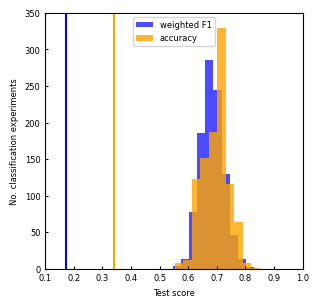

In [34]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)
plt.rcParams.update({'font.size': 6})

# plt.hist(f1s_average, bins=15, label="average F1")
plt.hist(np.array(results)[:,0], bins=10, label="weighted F1", alpha=0.7, color="blue")
plt.hist(np.array(results)[:,1], bins=10, label="accuracy", alpha=0.8, color="orange")
plt.legend()
# plt.xlim((0.65,0.95))
axes = plt.gca()
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
plt.xlabel("Test score")
plt.ylabel("No. classification experiments")

plt.axvline(0.17291455589327928, c="blue")

plt.axvline(16/47, c="orange")

plt.xlim([0.1,1])
plt.ylim([0,350])



plt.savefig('figures/classification_histogram_lines_4s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [13]:
np.argmin(np.absolute(np.array([x for x,y in results])-np.mean([x for x,y in results])))

280

In [18]:
results[280]

(0.682708544410672, 0.6808510638297872)

In [15]:
np.mean([x for x,y in results])

0.682520566368489

In [16]:
np.std([x for x,y in results])

0.03996877689323817

In [17]:
np.mean([y for x,y in results])

0.6942978723404255

In [12]:
np.std([y for x,y in results])

0.04351350456147341

Test classification performance with 1 second cadence dataweighted F1 0.818±0.035accuracy 0.837±0.032Test classification performance with 4 second cadence dataweighted F1 0.683±0.040accuracy 0.694±0.044

In [14]:
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, 3.6530612244897958)
# test_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[2],
#                                                     n_estimators=50,
#                                                     max_depth=None, 
#                                                     min_samples_split=2,
#                                                     min_samples_leaf = 5)

In [15]:
n_estimators=50
max_depth=None
min_samples_split=2
min_samples_leaf = 5
data_labels = data_labels
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v



# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]


RF_clf = RandomForestClassifier(random_state=280,
                                class_weight="balanced",
                                n_estimators=n_estimators,
                                max_depth=max_depth, 
                                min_samples_split=min_samples_split,
                                min_samples_leaf = min_samples_leaf
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

(0.682708544410672, 0.6808510638297872)


In [29]:
obs_component_counts_df_comp.loc[split_ob_ids[1]].loc[obs_component_counts_df_comp.loc[split_ob_ids[1]].iloc[:,-1] != "Unknown"]

10   11        14   16        17        19        20   21  \
20402-01-23-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
40703-01-18-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
40703-01-35-00  0.0  0.0  0.000000  0.0  0.080882  0.000000  0.000000  0.0   
20402-01-39-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
20402-01-41-03  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
10408-01-14-09  0.0  0.0  0.072165  0.0  0.000000  0.000000  0.103093  0.0   
10408-01-15-04  0.0  0.0  0.000000  0.0  0.032922  0.000000  0.000000  0.0   
20186-03-02-03  0.0  0.0  0.000000  0.0  0.045378  0.000000  0.000000  0.0   
40703-01-12-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
20402-01-37-01  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.031519  0.0   
10408-01-08-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.042017  0.0   
10408-01-44-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
40703-01-23-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
20402-01-32-01  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
10408-01-19-01  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
30402-01-12-02  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
20402-01-15-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
30402-01-12-03  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
30703-01-33-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
20402-01-48-00  0.0  0.0  0.000000  0.0  0.000000  0.049347  0.000000  0.0   
20402-01-50-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.000000  0.0   
40703-01-27-00  0.0  0.0  0.000000  0.0  0.000000  0.000000  0.204380  0.0   

                      23   24  ...  280  281       282       283       284  \
20402-01-23-00  0.000000  0.0  ...  0.0  0.0  0.112500  0.000000  0.000000   
40703-01-18-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
40703-01-35-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20402-01-39-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20402-01-41-03  0.000000  0.0  ...  0.0  0.0  0.000000  0.011236  0.022472   
10408-01-14-09  0.000000  0.0  ...  0.0  0.0  0.000000  0.298969  0.000000   
10408-01-15-04  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20186-03-02-03  0.000000  0.0  ...  0.0  0.0  0.000000  0.008403  0.000000   
40703-01-12-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20402-01-37-01  0.000000  0.0  ...  0.0  0.0  0.000000  0.005731  0.000000   
10408-01-08-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.336134  0.000000   
10408-01-44-00  0.034772  0.0  ...  0.0  0.0  0.143885  0.000000  0.000000   
40703-01-23-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20402-01-32-01  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
10408-01-19-01  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
30402-01-12-02  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20402-01-15-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
30402-01-12-03  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
30703-01-33-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
20402-01-48-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.409289   
20402-01-50-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   
40703-01-27-00  0.000000  0.0  ...  0.0  0.0  0.000000  0.000000  0.000000   

                     285       286       287       288   Class  
20402-01-23-00  0.000000  0.081250  0.000000  0.000000   alpha  
40703-01-18-00  0.000000  0.000000  0.000000  0.026923    beta  
40703-01-35-00  0.000000  0.000000  0.000000  0.000000    beta  
20402-01-39-00  0.994403  0.000000  0.000000  0.000000   gamma  
20402-01-41-03  0.000000  0.000000  0.056180  0.000000   delta  
10408-01-14-09  0.000000  0.000000  0

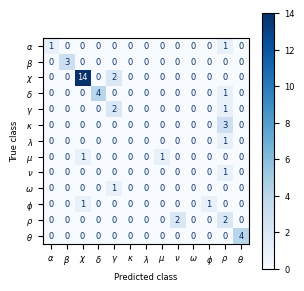

In [16]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
plt.savefig('figures/classification_matrix_4s.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [21]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [22]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
#https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib


# pylab.rcParams['figure.figsize'] = (3.15, 8.4) # A4 size 210mm x 297mm
plt.rcParams['figure.figsize'] = (6.97, 8.4)
plt.rcParams.update({'font.size': 6})


# colors = matplotlib.colors.CSS4_COLORS.keys()
# colors = np.array(list(colors))


# NUM_COLORS = 14
# cm = plt.get_cmap("jet")#('gist_rainbow')
# colors = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

ids_ar = np.array(segment_class)

# class_names = list(inv_ob_state.keys())


alpha = np.where(ids_ar == "alpha")[0][1]#1
beta= np.where(ids_ar == "beta")[0][7]#7
gamma=np.where(ids_ar == "gamma")[0][4]
delta=np.where(ids_ar == "delta")[0][5]
theta=np.where(ids_ar == "theta")[0][4]#4
kappa=np.where(ids_ar == "kappa")[0][3]
lambda1=np.where(ids_ar == "lambda")[0][2]
mu=np.where(ids_ar == "mu")[0][1]
nu=np.where(ids_ar == "nu")[0][1]
rho=np.where(ids_ar == "rho")[0][1]
phi=np.where(ids_ar == "phi")[0][1]
chi=np.where(ids_ar == "chi")[0][1]
eta=np.where(ids_ar == "eta")[0][4]
omega=np.where(ids_ar == "omega")[0][3]


# selected_lcs = [alpha,beta,gamma,delta,theta,kappa,lambda1,mu,nu,rho,phi,chi,eta,omega]
selected_lcs = [alpha,beta,chi,delta,eta,gamma,kappa,lambda1,mu,nu,omega,phi,rho,theta]


fig, axes = plt.subplots(nrows=14, ncols=2)
# axes = axes.flatten()

plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.01)

# good_classes = ["delta", "mu", "rho", "phi"]
intervals = {}

class_names = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
class_names = np.sort(class_names)

for plot_ind in range(14):
    light_c = selected_lcs[plot_ind]
    class_name = class_names[plot_ind]    
    axes[plot_ind, 0].plot(np.linspace(0,512, num=128), segments[light_c], c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind, 0].plot(np.linspace(0,512, num=128), recos[light_c], c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind, 1].plot(np.linspace(0,512, num=128), segments[light_c]/1000, c="black", linewidth=0.5, zorder=1, label="Input")
    axes[plot_ind, 1].plot(np.linspace(0,512, num=128), recos[light_c]/1000, c="magenta", linewidth=0.5, zorder=2, label="Reconstruction")
    axes[plot_ind, 1].yaxis.tick_right()
    axes[plot_ind, 0].set_ylim([0, 15000])
    axes[plot_ind, 0].set_xlim([0, 512])
    axes[plot_ind, 1].set_xlim([0, 512])

    axes[plot_ind, 0].text(0.99,0.99,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind, 0].transAxes, size=10)
        
    axes[plot_ind, 0].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
    axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind].tick_params(axis="y", which="minor", length=2, width=0.75, labelsize=8, direction="in")


#     if plot_ind%2 == 0:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=8, direction="in")
#     else:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind].get_yticklabels(), visible=False)

    if plot_ind == 6:
        axes[plot_ind, 0].set_ylabel("Rate (kcts/s)", size=6)
    if plot_ind == 13:#plot_ind == 12 or plot_ind == 13:
        axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
        axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
        axes[plot_ind, 0].set_xlabel("Time (s)", size=6, x=1)

    else:
        axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind, 0].get_xticklabels(), visible=False)
        axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
        plt.setp(axes[plot_ind, 1].get_xticklabels(), visible=False)
    
#     axes[plot_ind].set_yticks([0, 2000, 4000, 6000, 8000, 10000, 12000, 14000])
#     axes[plot_ind].set_yticklabels([0, "", "", 6, "", "", 12, ""])
    axes[plot_ind, 0].set_yticks([0, 2500, 5000, 7500, 10000, 12500])
    axes[plot_ind, 0].set_yticklabels([0, "", 5, "", 10, "",])
    axes[plot_ind, 0].set_xticks([0, 100, 200,300, 400, 500])
    axes[plot_ind, 0].set_xticklabels([0, "", 200,"", 400, ""])
    axes[plot_ind, 1].set_xticks([0, 100, 200,300, 400, 500])
    axes[plot_ind, 1].set_xticklabels([0, "", 200,"", 400, ""])
    
# axes.reshape((14,1))


# axes[0][0].tick_params(axis="x", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[0][1].tick_params(axis="x", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[1][0].tick_params(axis="x", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[1][1].tick_params(axis="x", which="major", length=5, width=1, labelsize=25, direction="in")

# axes[0][0].tick_params(axis="y", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[1][0].tick_params(axis="y", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[0][1].tick_params(axis="y", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[1][1].tick_params(axis="y", which="major", length=5, width=1, labelsize=5, direction="in")

# plt.setp(axes[0][1].get_yticklabels(), visible=False)
# plt.setp(axes[1][1].get_yticklabels(), visible=False)
# plt.setp(axes[0][1].get_xticklabels(), visible=False)
# plt.setp(axes[0][0].get_xticklabels(), visible=False)

# axes[1][0].set_xticks([500,1000,1500,2000])
# axes[1][1].set_xticks([500,1000,1500,2000])


# axes[0][0].yaxis.set_label_coords(-0.2, 0)
# axes[1][0].xaxis.set_label_coords(1, -0.1)

# plt.suptitle("14 classes of activity of x-ray black hole binary GRS1915+105", fontsize=40, y=0.92)

# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
#             hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())


# plt.savefig('figures/segments_fit_alphabetical.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)
# plt.legend()
plt.show()

NameError: name 'segments' is not defined

In [20]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [31]:
np.unique(data_labels).shape

(211,)

In [ ]:
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, 3.6530612244897958)

In [24]:
new_classification = data_labels

Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

comparison_matrix = np.zeros((len(np.unique(new_classification)), len(Belloni_classes)), dtype=int)

comparison_matrix_df = pd.DataFrame(comparison_matrix, columns=Belloni_classes, index=np.unique(new_classification))

for n_Bc, Belloni_class in enumerate(Belloni_classes):
    Belloni_class_indices = np.where(np.array(segment_class) == Belloni_class)[0]
    count_clusters_for_class = np.unique(np.take(new_classification, Belloni_class_indices), return_counts=True)
    for cluster_ind, cluster in enumerate(count_clusters_for_class[0]):
        comparison_matrix_df[Belloni_class][cluster] = count_clusters_for_class[1][cluster_ind]

In [25]:
class_normalized_comparison_matrix_df=(comparison_matrix_df-comparison_matrix_df.min())/(comparison_matrix_df.max()-comparison_matrix_df.min())
known_comparison_matrix_df = comparison_matrix_df.drop(columns=['Unknown']).T
component_normalized_comparison_matrix_df = (known_comparison_matrix_df-known_comparison_matrix_df.min())/(known_comparison_matrix_df.max()-known_comparison_matrix_df.min())

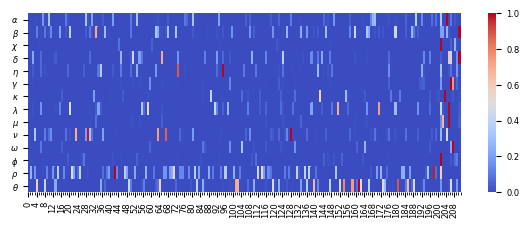

In [26]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True), xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
# # ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 6)
# ax.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="out")

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())

classes_names = class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True).index.values
ax.set_yticklabels([r"$\{}$".format(c) for c in classes_names])

# offset = ScaledTranslation(0.5, 0, ax.transData)

# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)
    
# for label in ax.xaxis.get_minorticklabels():
#     label.set_transform(label.get_transform() + offset)

# plt.title("Gaussian mixture components' populations in terms of classified data (component-wise min-maxed)")
# plt.savefig("figures/GMM122vsBelloni_heatmap.png", dpi=300)
plt.savefig('figures/GMM279vsBelloni_heatmap.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()

# Assess light curve classifications (1s)

In [39]:
with open('{}/1776_light_curves_1s_bin_errorfix.pkl'.format(data_dir), 'rb') as f:
    lcs = pickle.load(f)
with open('{}/1776_light_curves_1s_bin_ids_errorfix.pkl'.format(data_dir), 'rb') as f:
    ids = pickle.load(f)

In [41]:
test_set_classifications = test_data.iloc[:,-1].to_frame()
test_set_classifications["Prediction"] = preds

In [42]:
preds

array(['alpha', 'alpha', 'alpha', 'beta', 'beta', 'gamma', 'gamma',
       'gamma', 'delta', 'delta', 'delta', 'delta', 'delta', 'theta',
       'theta', 'theta', 'theta', 'kappa', 'kappa', 'kappa', 'theta',
       'mu', 'mu', 'rho', 'rho', 'rho', 'rho', 'rho', 'chi', 'chi', 'chi',
       'chi', 'chi', 'gamma', 'chi', 'chi', 'chi', 'chi', 'gamma', 'chi',
       'chi', 'chi', 'chi', 'chi', 'chi', 'chi', 'kappa'], dtype=object)

In [43]:
misclass = test_set_classifications[test_set_classifications["Class"] != test_set_classifications["Prediction"]]

In [44]:
misclass

Class Prediction
40703-01-22-00    beta      alpha
20402-01-36-01  lambda      theta
10408-01-40-00      nu        rho
10408-01-19-00     phi        chi
10408-01-19-02     phi        chi
10408-01-42-00     chi      gamma
40703-01-20-03     chi      gamma
40703-01-29-01   omega      kappa

In [45]:
misclass_lc_n=0

In [46]:
test_data.loc[misclass.index[misclass_lc_n]].to_frame().T#.iloc[:-1]#.values.reshape(1, -1)

5  6         10 11 13          15 16          18         19  \
40703-01-22-00  0  0  0.0416667  0  0  0.00833333  0  0.00833333  0.0166667   

               21  ... 210 213 214        215 216 218 219 220 221 Class  
40703-01-22-00  0  ...   0   0   0  0.0916667   0   0   0   0   0  beta  

[1 rows x 141 columns]

In [143]:
(train_data["Class"]=="lambda").sum()

2

In [385]:
between_stars = (finger_UMAP.embedding_[:,1]<5) & (finger_UMAP.embedding_[:,1]>4.6) & (finger_UMAP.embedding_[:,0]>5)

In [372]:
xover5_73 = finger_UMAP.embedding_[:,0]>5.73

In [373]:
yunder5 = finger_UMAP.embedding_[:,1]<5

In [386]:
UMAP_data[between_stars]

0    1         2         3         4    5    6  \
20402-01-07-00  0.009864  0.0  0.025894  0.001233  0.012330  0.0  0.0   
30703-01-35-00  0.000000  0.0  0.012295  0.000000  0.002049  0.0  0.0   

                       7    8    9  ...  213  214  215  216       217  218  \
20402-01-07-00  0.006165  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.001233  0.0   
30703-01-35-00  0.002049  0.0  0.0  ...  0.0  0.0  0.0  0.0  0.000000  0.0   

                219  220  221  Class  
20402-01-07-00  0.0  0.0  0.0    chi  
30703-01-35-00  0.0  0.0  0.0    chi  

[2 rows x 223 columns]

In [365]:
finger_UMAP.embedding_[:-1,:][training_lcs_predicted_class[:-1]][chi_xover5_73 & chi_yunder5]

array([[5.772046 , 3.7760227],
       [5.922937 , 3.7046342],
       [5.971767 , 4.0223007],
       [6.0956426, 4.762551 ],
       [5.845106 , 3.9048662]], dtype=float32)

In [357]:
training_lcs_predicted_class

20402-01-33-00    False
40703-01-14-01    False
20402-01-35-00    False
40703-01-30-00    False
40703-01-14-00    False
                  ...  
40703-01-20-02     True
30703-01-35-00     True
20402-01-29-00     True
20402-01-05-00     True
20402-01-09-00     True
Name: Class, Length: 62, dtype: bool

In [251]:
test_data.loc[["10408-01-42-00","40703-01-20-03", "40703-01-20-01"]]#.to_frame()

0    1    2         3    4    5    6    7    8    9  ...  \
10408-01-42-00  0.0  0.0  0.0  0.015873  0.0  0.0  0.0  0.0  0.0  0.0  ...   
40703-01-20-03  0.0  0.0  0.0  0.012821  0.0  0.0  0.0  0.0  0.0  0.0  ...   
40703-01-20-01  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...   

                213  214  215  216  217  218  219  220  221  Class  
10408-01-42-00  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    chi  
40703-01-20-03  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    chi  
40703-01-20-01  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0    chi  

[3 rows x 223 columns]

In [254]:
np.unique(test_data.iloc[:,-1])

array(['alpha', 'beta', 'chi', 'delta', 'gamma', 'kappa', 'lambda', 'mu',
       'nu', 'omega', 'phi', 'rho', 'theta'], dtype=object)

In [277]:
RF_clf.predict_proba(test_data.loc[misclass.index[2]].to_frame().T.iloc[:,:-1])[0]

array([0.00616275, 0.05295771, 0.0323668 , 0.10415388, 0.02232777,
       0.1890532 , 0.115     , 0.04662781, 0.        , 0.05      ,
       0.01449058, 0.03386844, 0.33299106])

In [51]:
misclass

Class Prediction
40703-01-22-00    beta      alpha
20402-01-36-01  lambda      theta
10408-01-40-00      nu        rho
10408-01-19-00     phi        chi
10408-01-19-02     phi        chi
10408-01-42-00     chi      gamma
40703-01-20-03     chi      gamma
40703-01-29-01   omega      kappa

In [53]:
misclass_lc_n = 5
for prob, clas in zip(RF_clf.predict_proba(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T.iloc[:,:-1])[0], np.unique(test_data.iloc[:,-1])):
    print(np.round(prob, decimals=4), clas)

0.0034 alpha
0.0188 beta
0.3246 chi
0.023 delta
0.3431 gamma
0.0331 kappa
0.0 lambda
0.0133 mu
0.0005 nu
0.0007 omega
0.114 phi
0.1121 rho
0.0134 theta


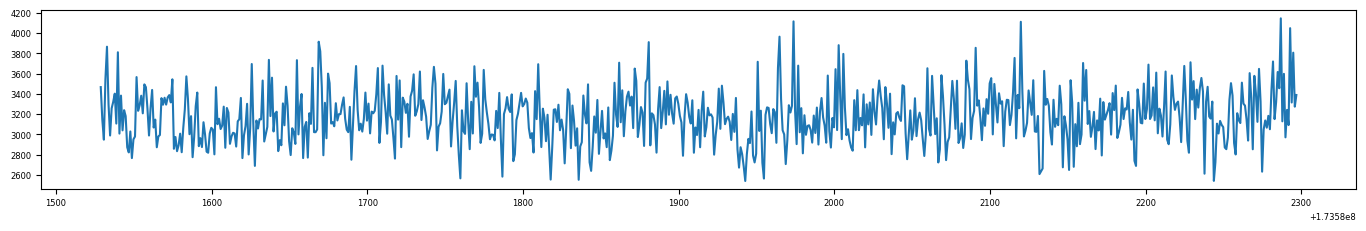

In [60]:
plt.rcParams['figure.figsize'] = (16.97, 6.97*(1/3))

plot_lc = lcs[np.where(np.array(ids) == "40703-01-20-03")[0][0]]
plt.plot(plot_lc[0][260:], plot_lc[1][260:])
plt.show()

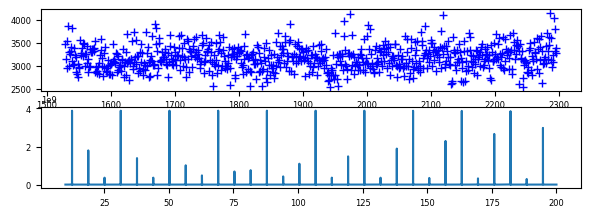

In [72]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(1/3))

import scipy.signal as signal
f = np.linspace(10, 200, 10000)
pgram = signal.lombscargle(plot_lc[0][260:], plot_lc[1][260:], f, normalize=False)
plt.subplot(2, 1, 1)
plt.plot(plot_lc[0][260:], plot_lc[1][260:], 'b+')
plt.subplot(2, 1, 2)
plt.plot(f, pgram)
plt.show()

In [75]:
np.mean(misclass_lc[1])

3133.021218134636

In [49]:
misclass

Class Prediction
40703-01-22-00    beta      alpha
20402-01-36-01  lambda      theta
10408-01-40-00      nu        rho
10408-01-19-00     phi        chi
10408-01-19-02     phi        chi
10408-01-42-00     chi      gamma
40703-01-20-03     chi      gamma
40703-01-29-01   omega      kappa

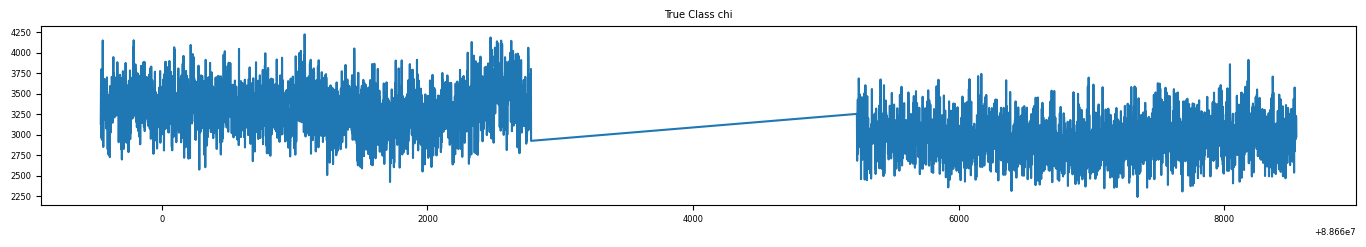

Predicted Class gamma


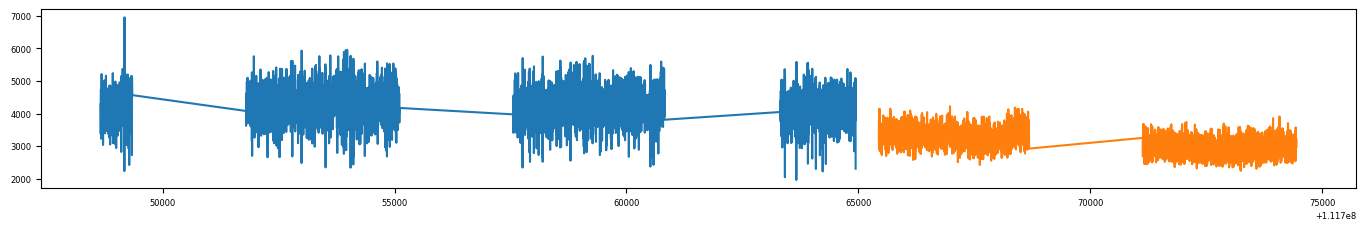

20402-01-37-00


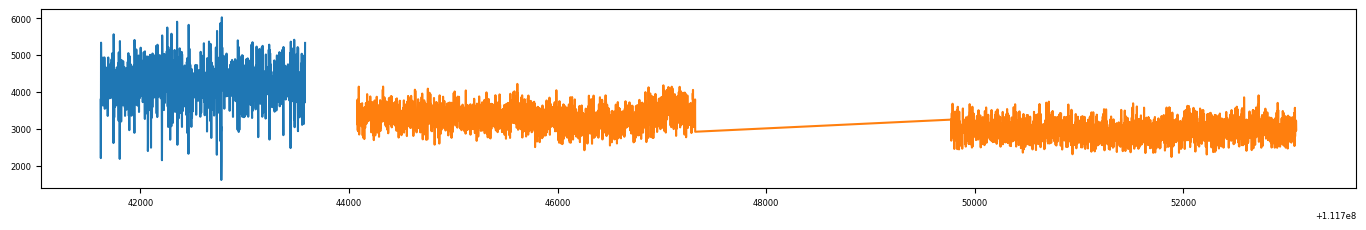

20402-01-37-02


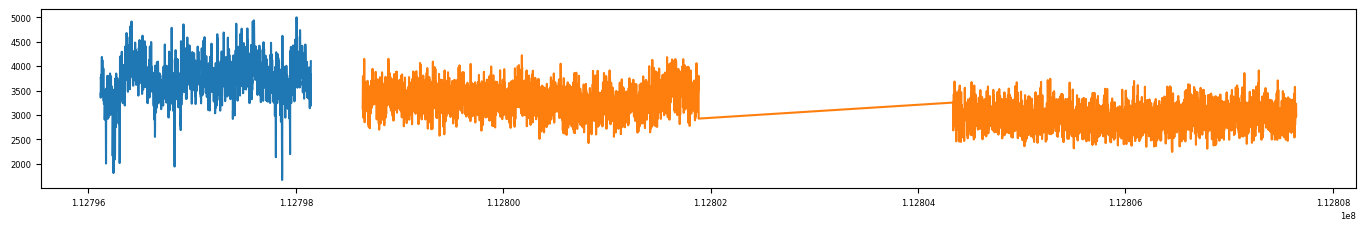

20402-01-39-02


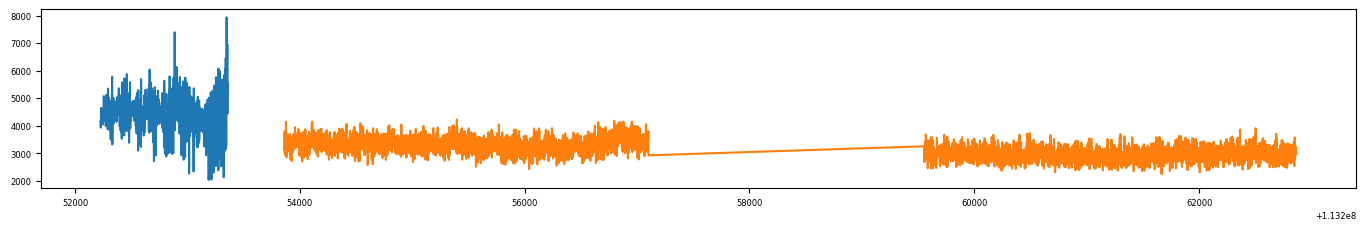

20402-01-40-00


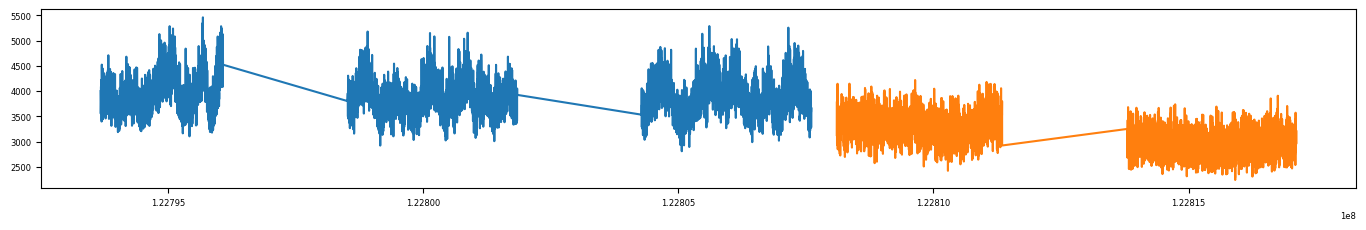

20402-01-56-00


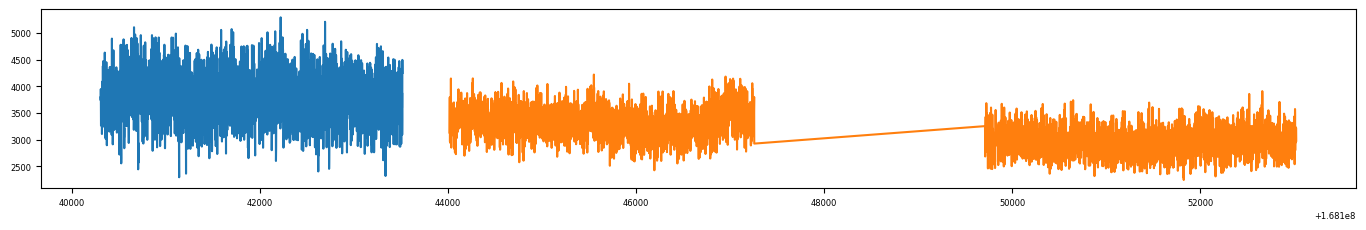

40703-01-13-00


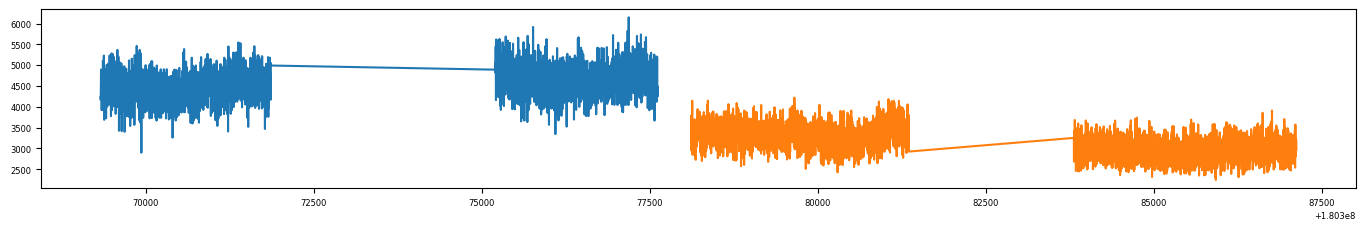

40115-01-07-00


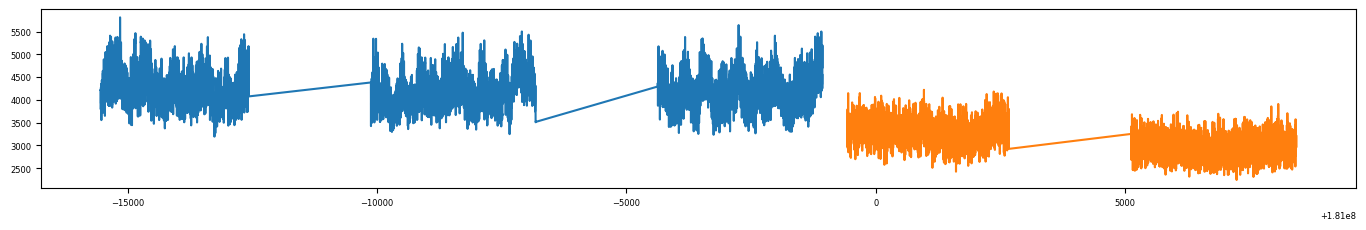

40703-01-31-00
True Class chi


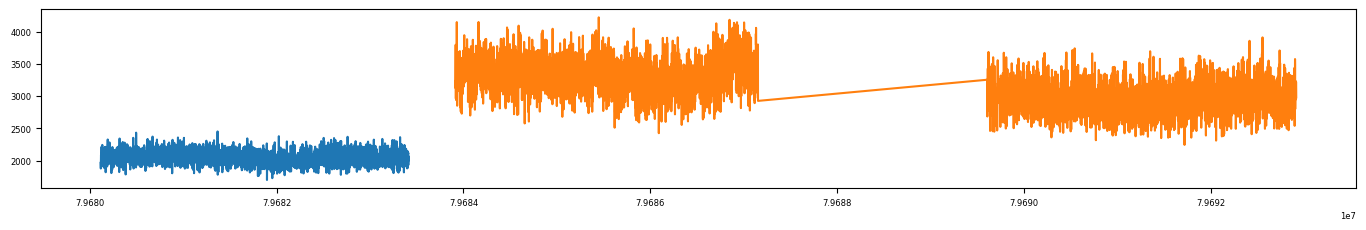

10408-01-22-01


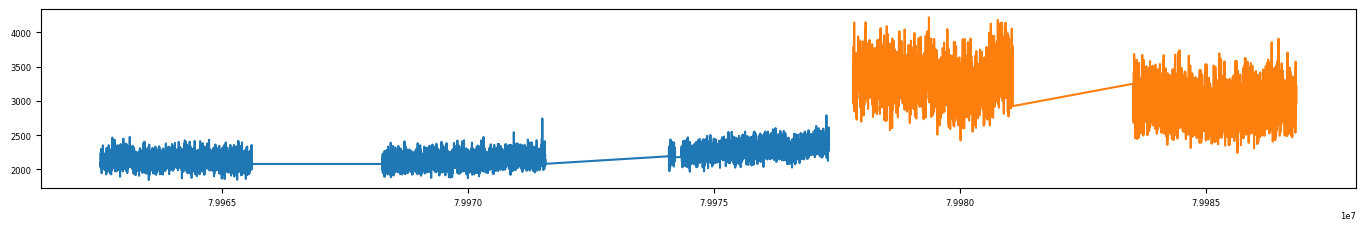

10408-01-23-00


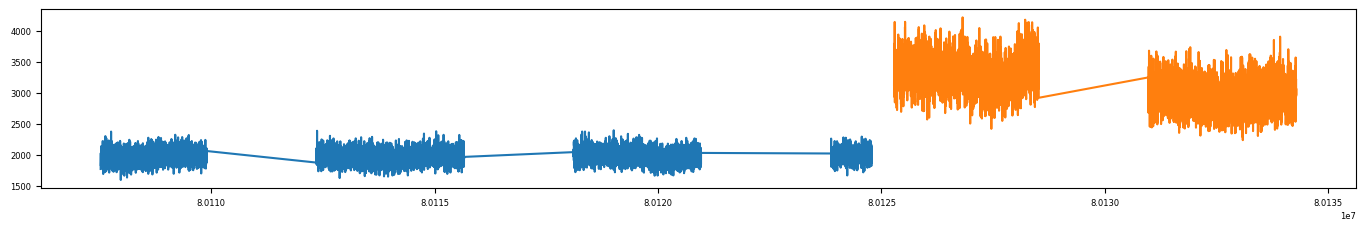

10408-01-24-00


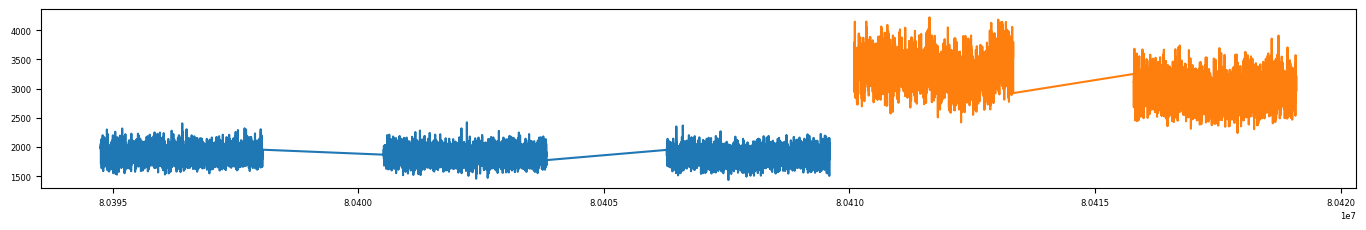

10408-01-25-00


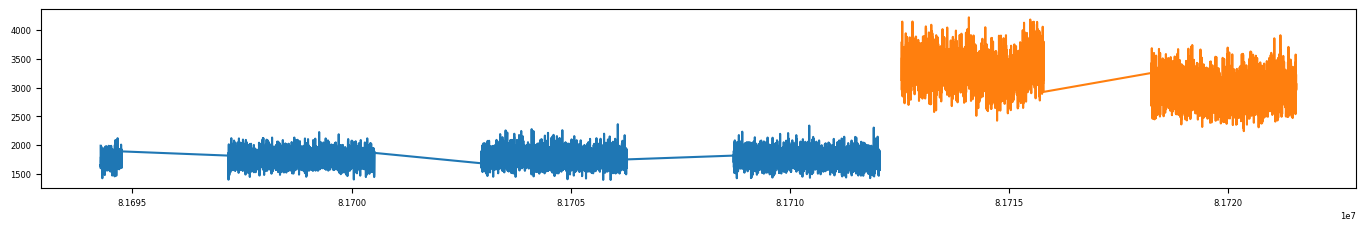

10408-01-28-00


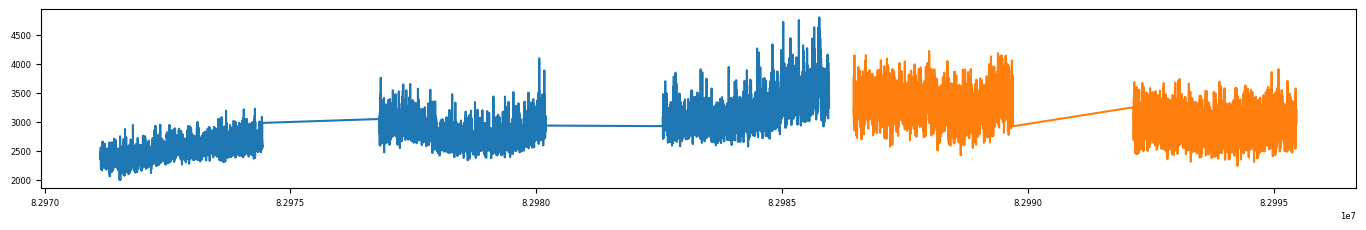

10408-01-30-00


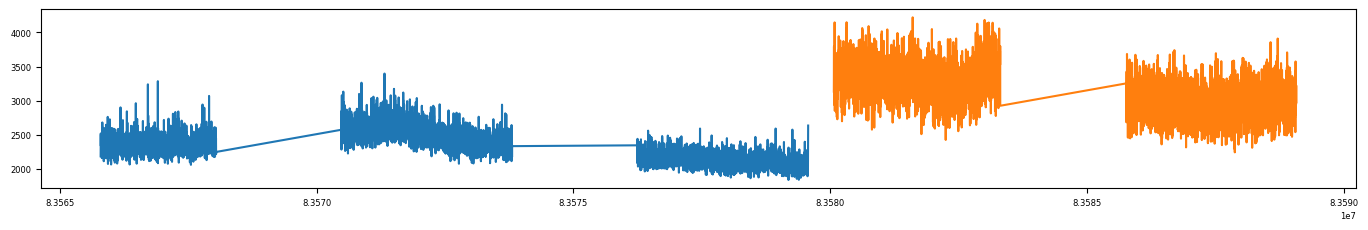

10408-01-31-00


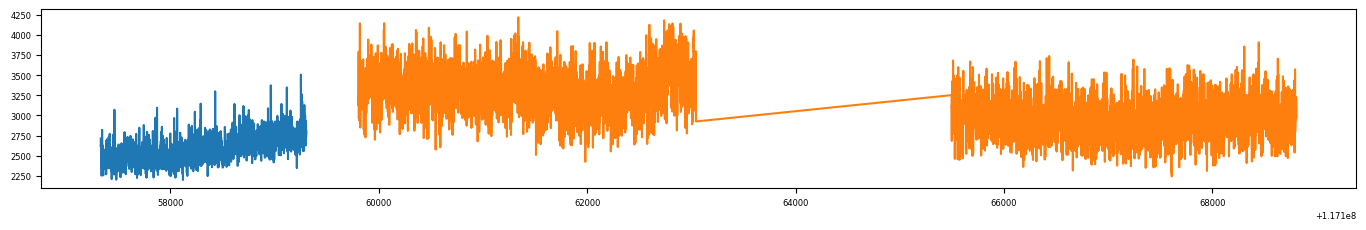

20186-03-02-05


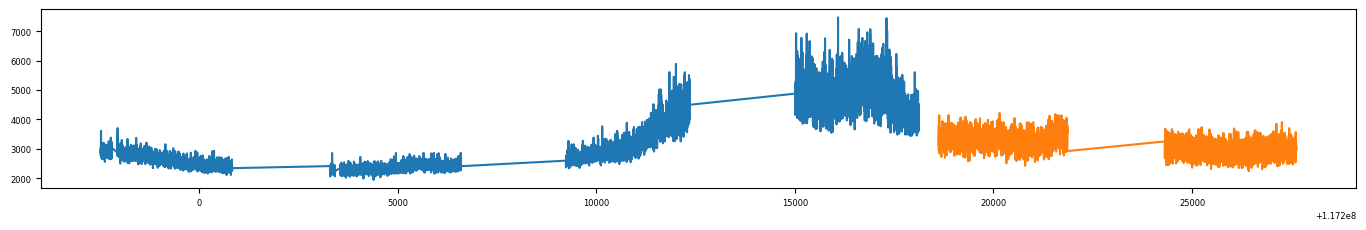

20186-03-02-06


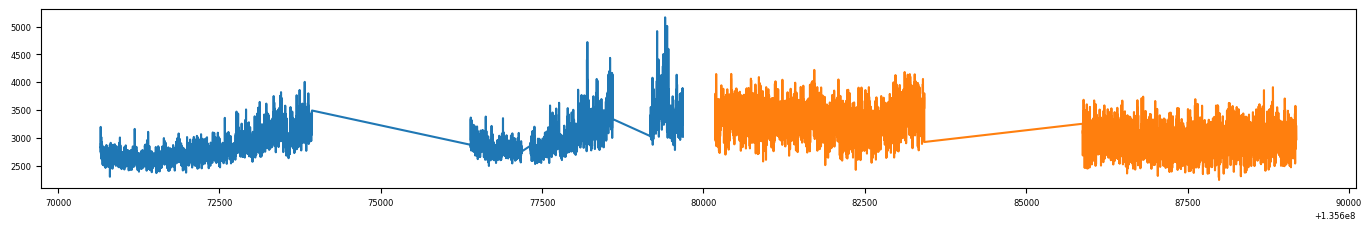

30402-01-11-00


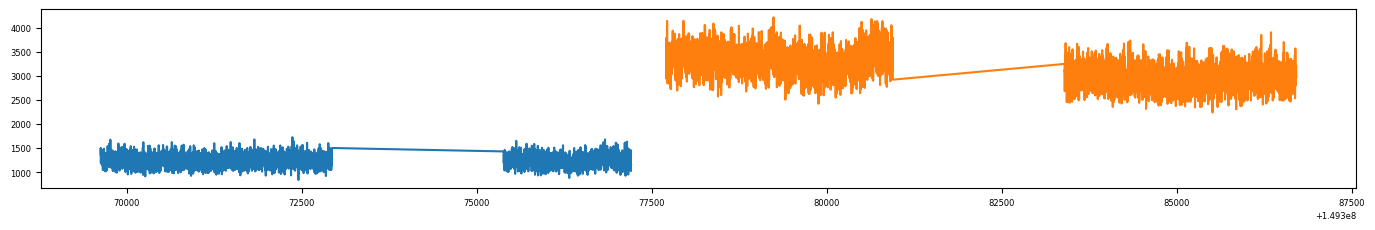

30703-01-35-00


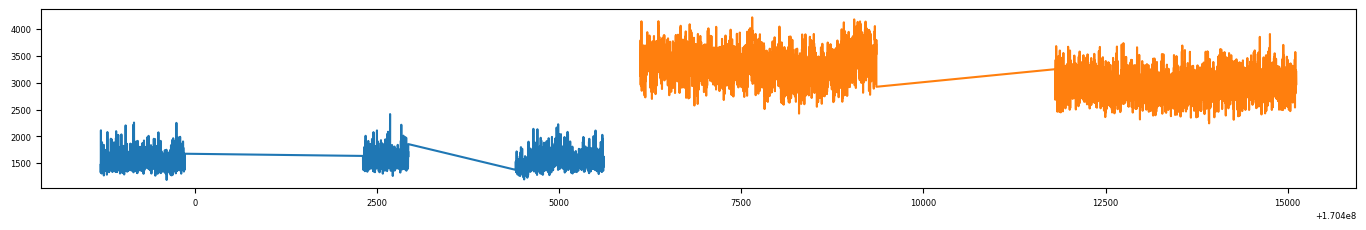

40703-01-15-00


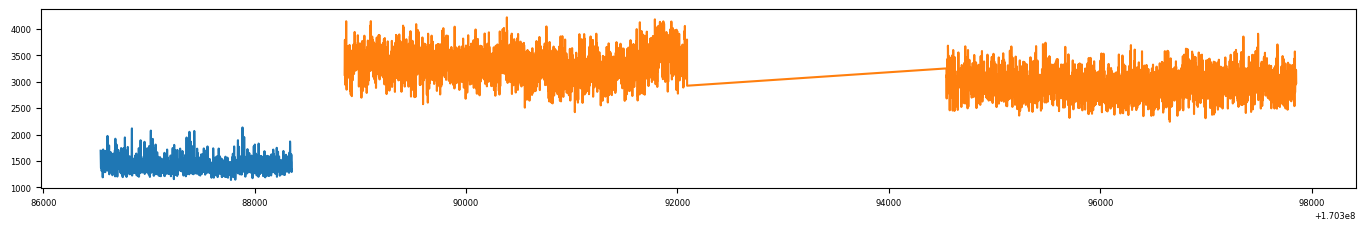

40703-01-15-01


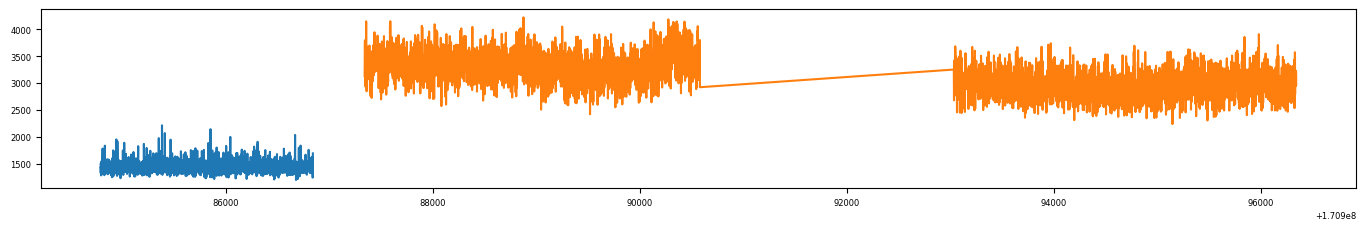

40703-01-16-00


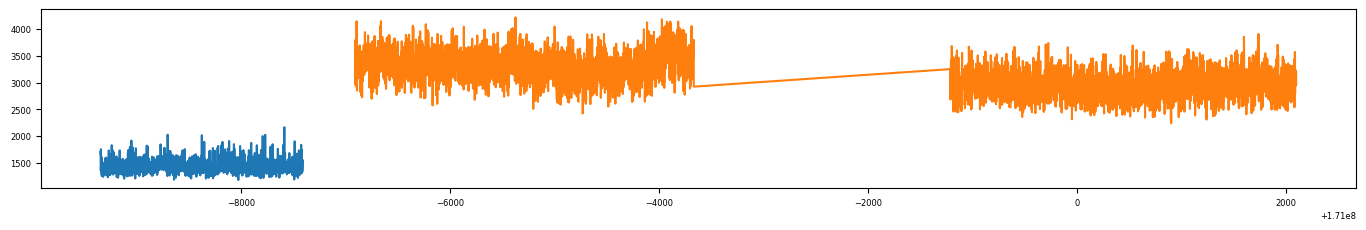

40703-01-16-01


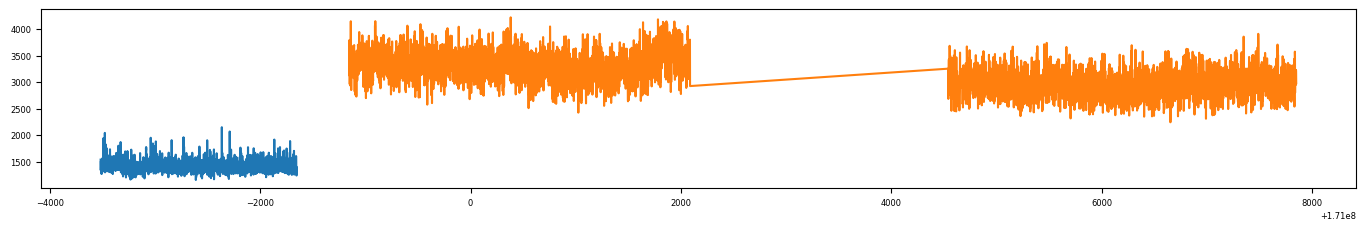

40703-01-16-02


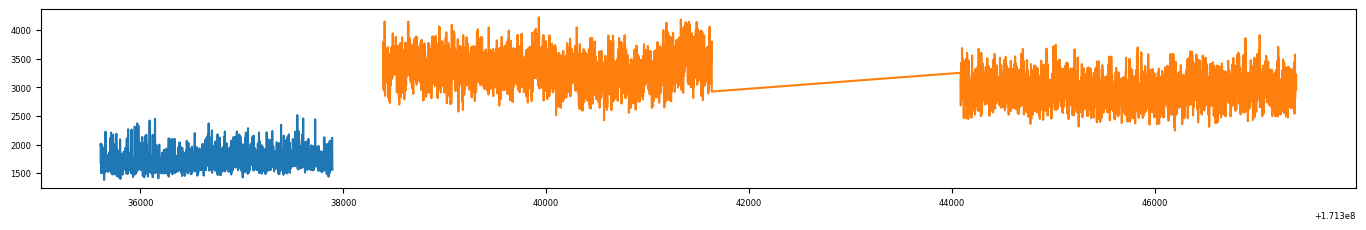

40703-01-17-00


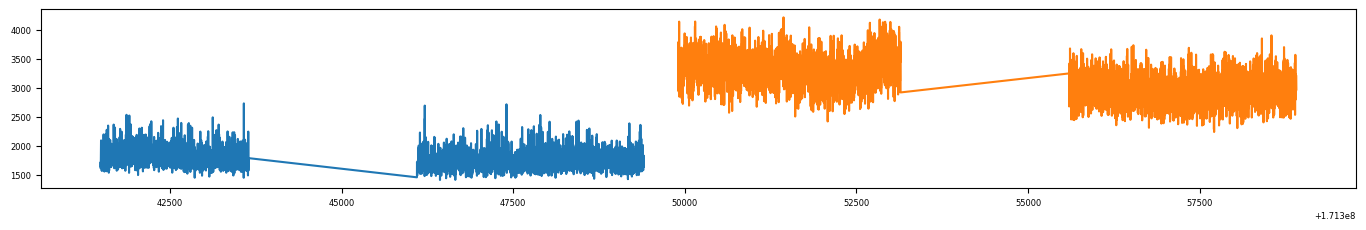

40703-01-17-01


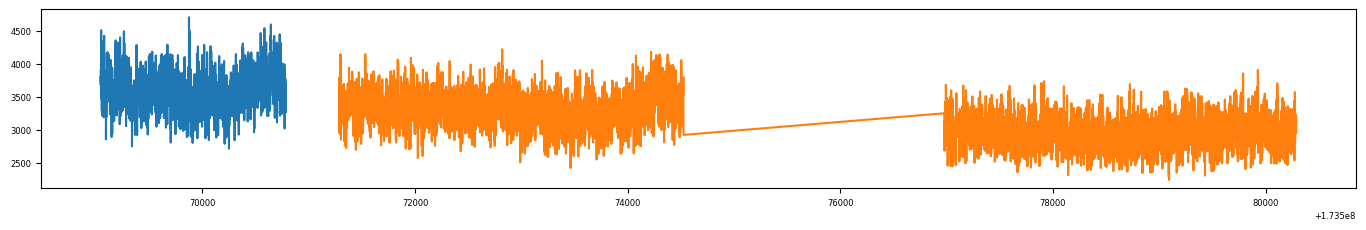

40703-01-20-00


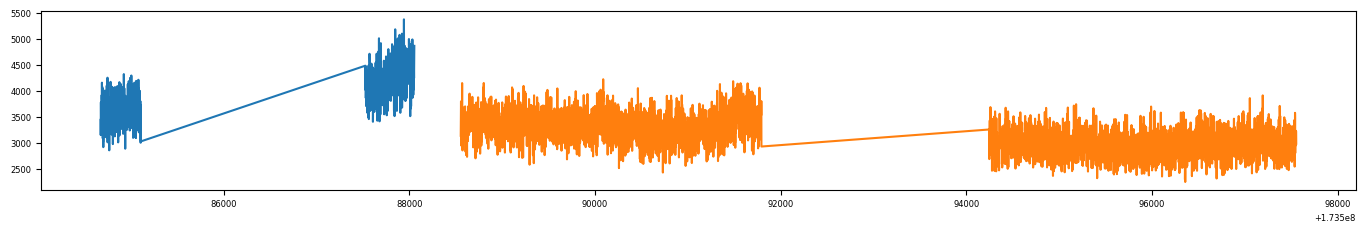

40703-01-20-02


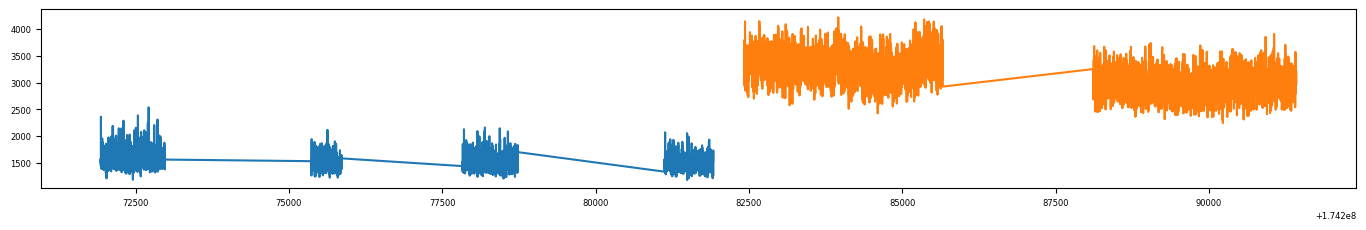

40703-01-21-01


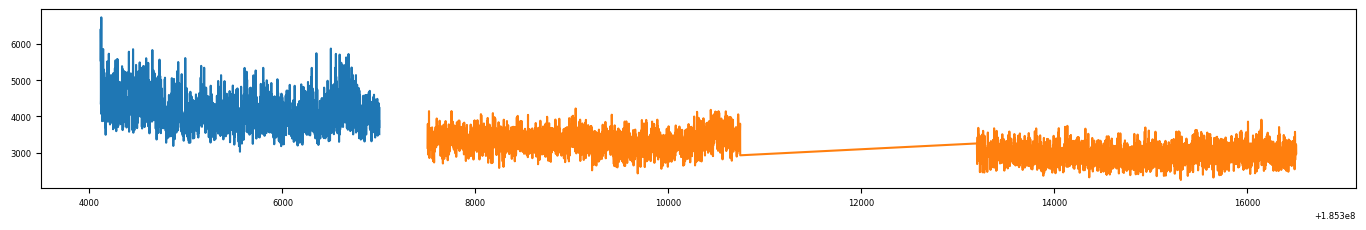

40703-01-38-01


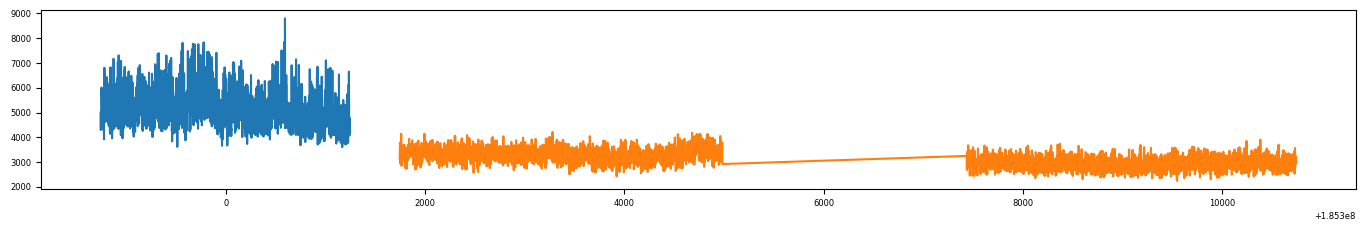

40703-01-38-02


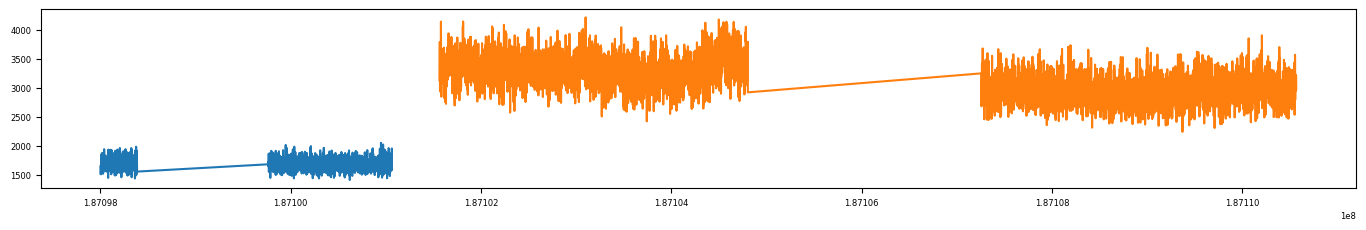

40703-01-41-00


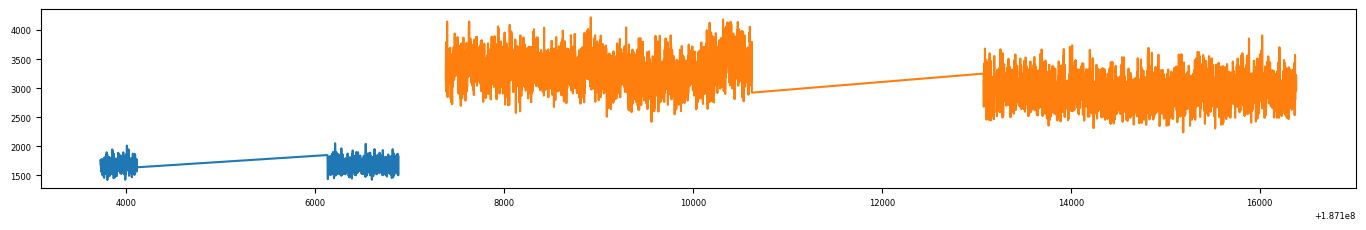

40703-01-41-01


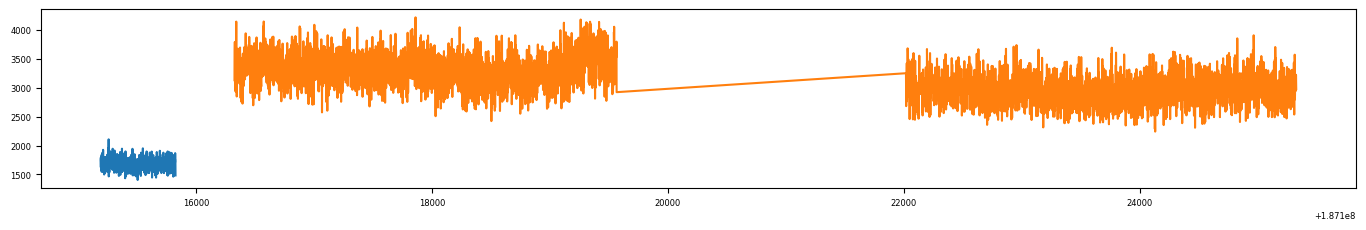

40703-01-41-03


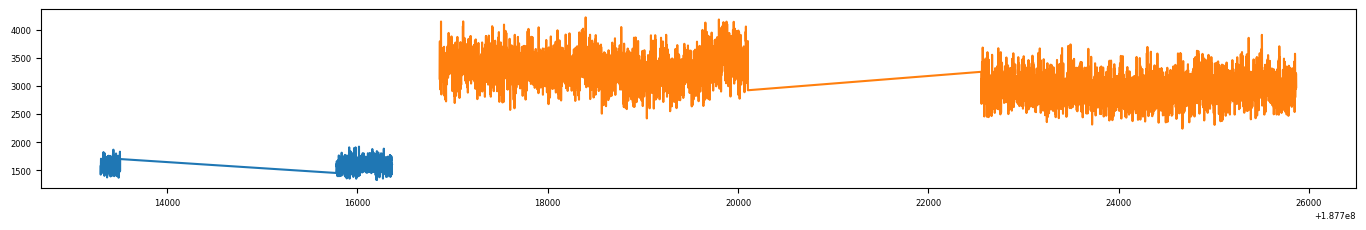

40703-01-42-01


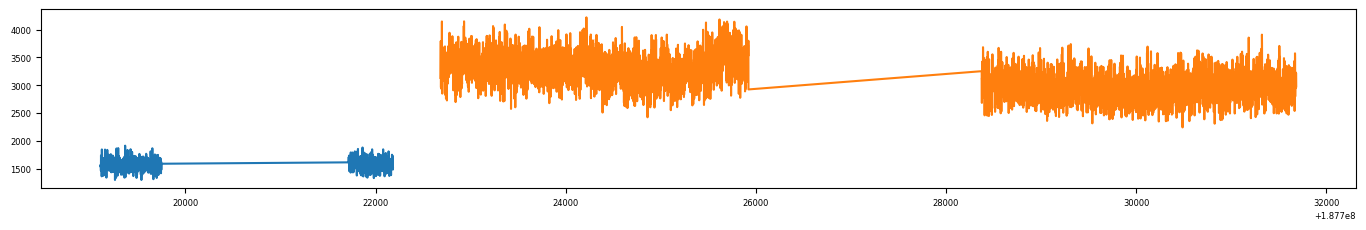

40703-01-42-03


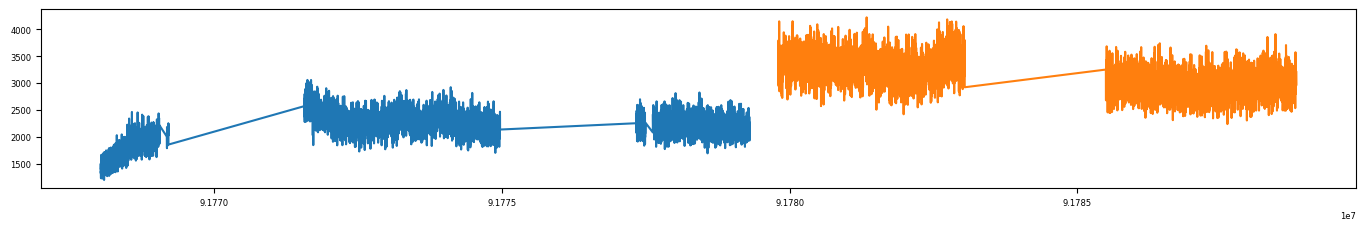

20402-01-04-00


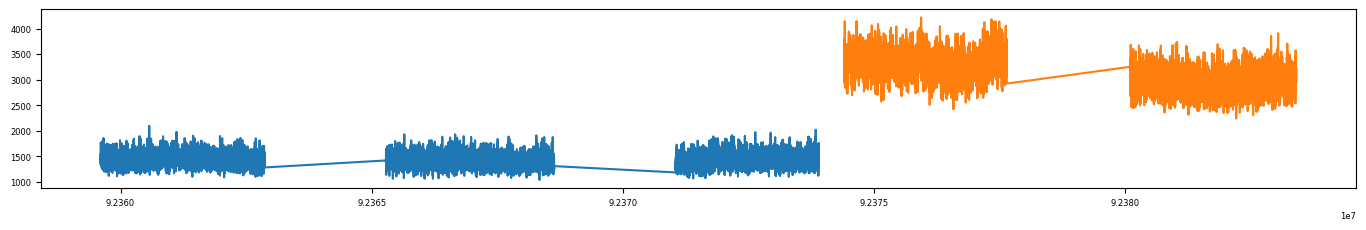

20402-01-05-00


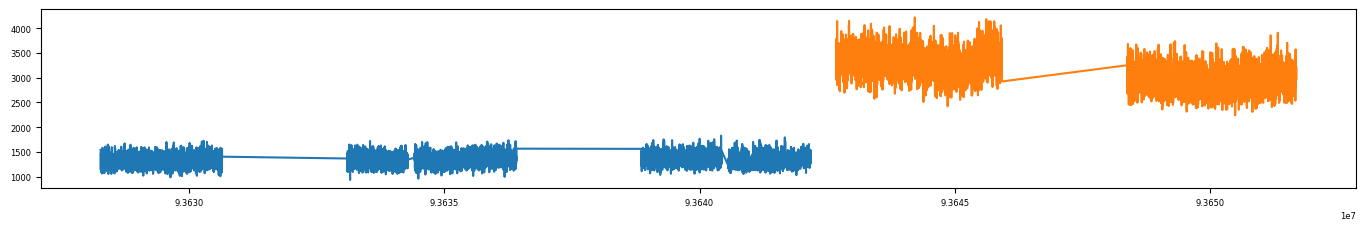

20402-01-07-00


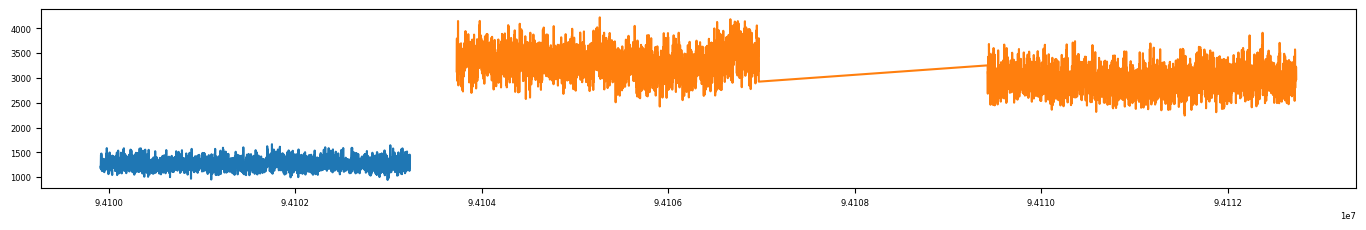

20402-01-08-01


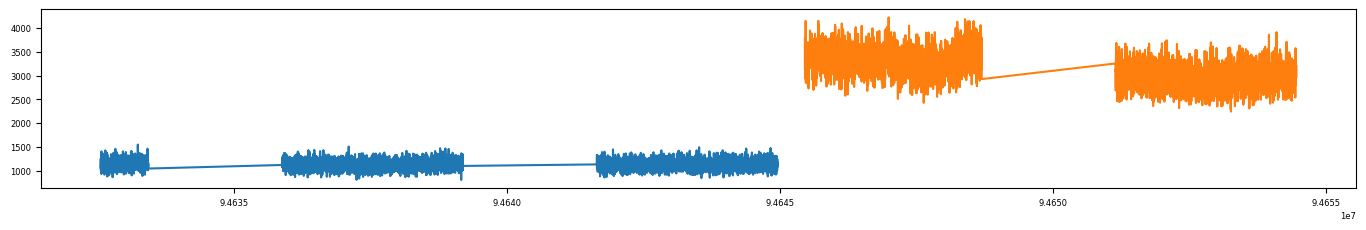

20402-01-09-00


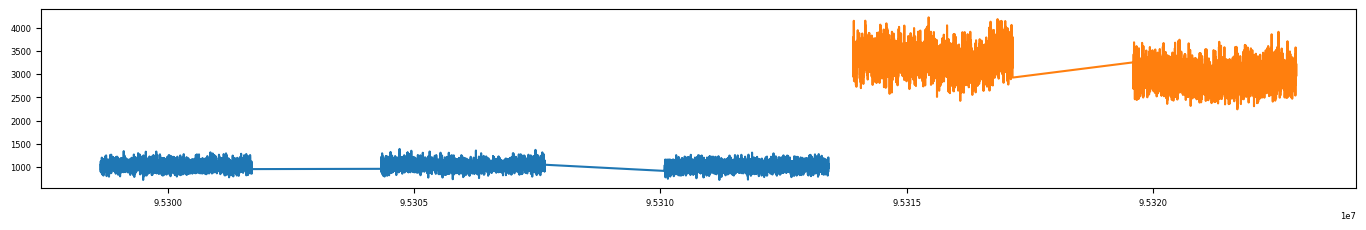

20402-01-10-00


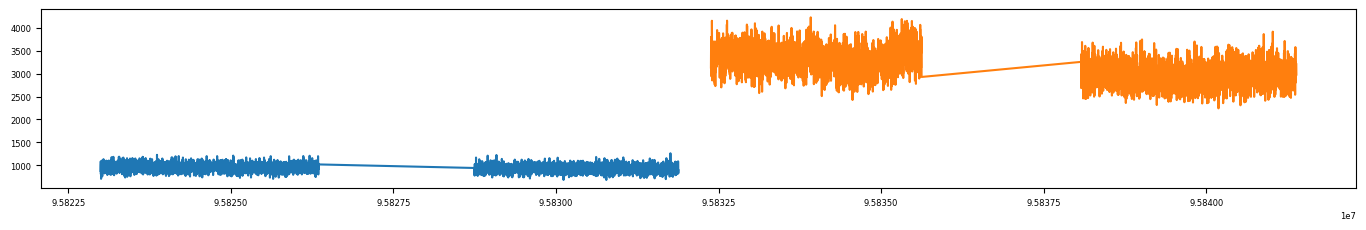

20402-01-11-00


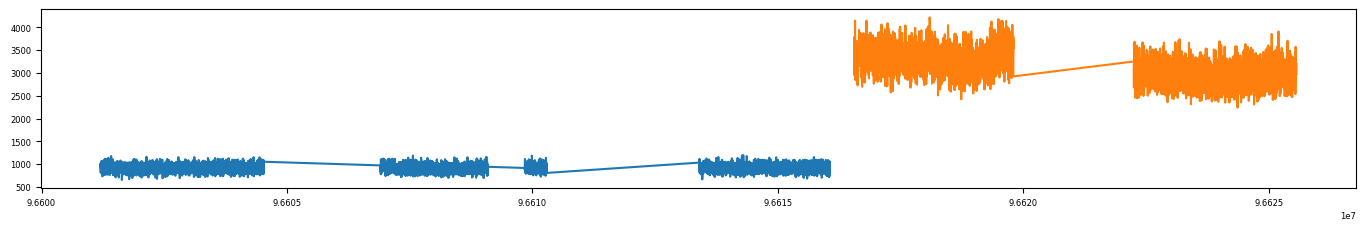

20402-01-12-00


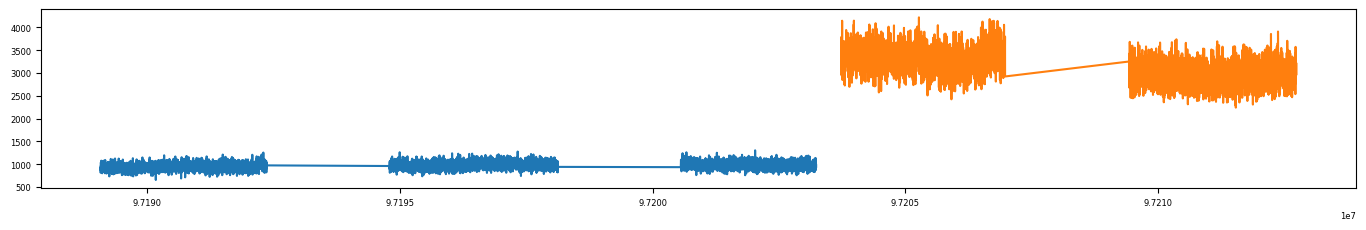

20402-01-13-00


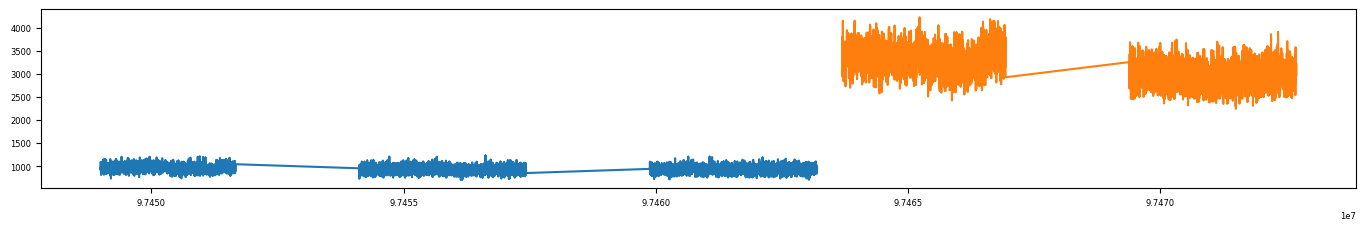

20402-01-14-00


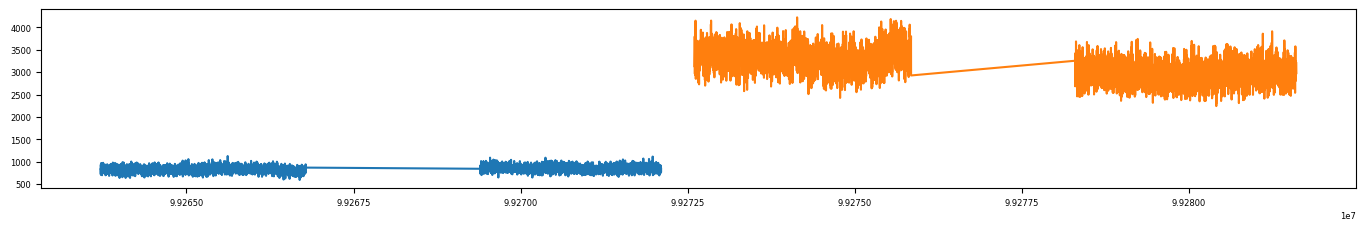

20402-01-16-00


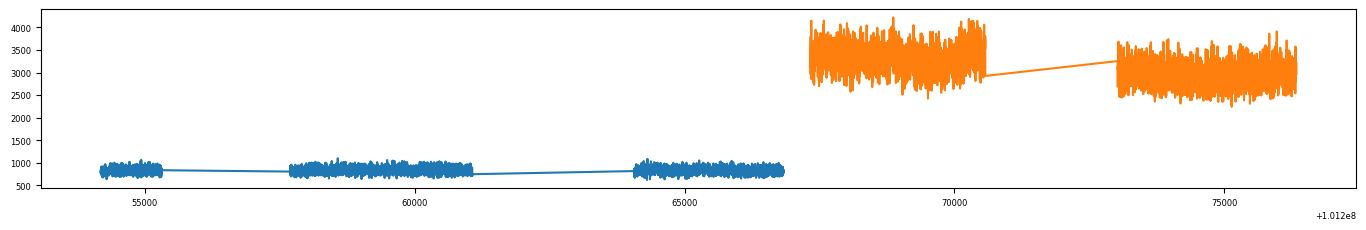

20402-01-20-00


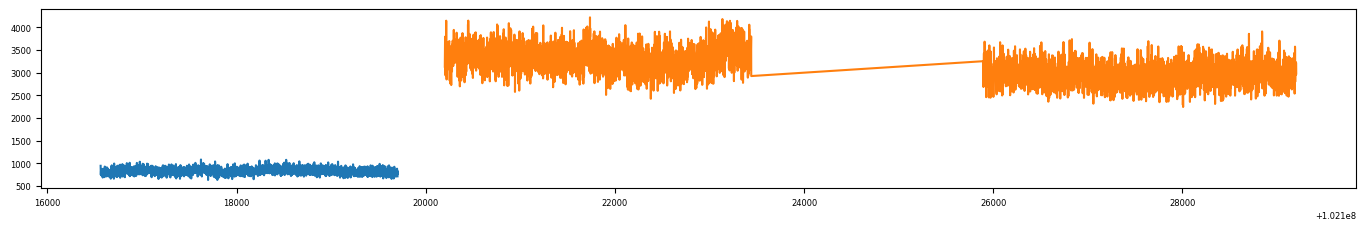

20402-01-21-01


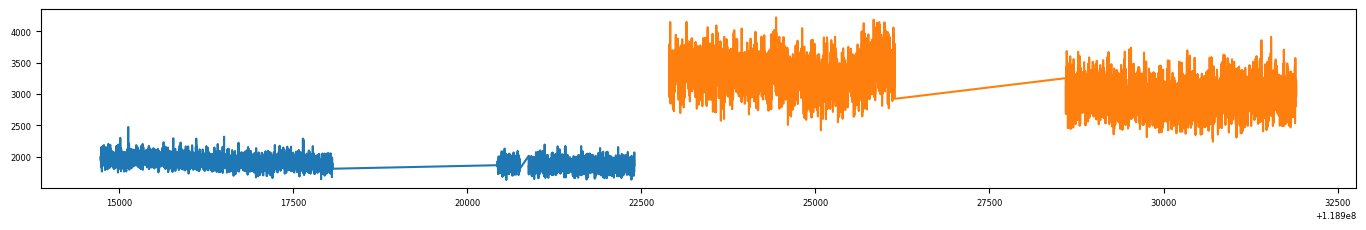

20402-01-49-00


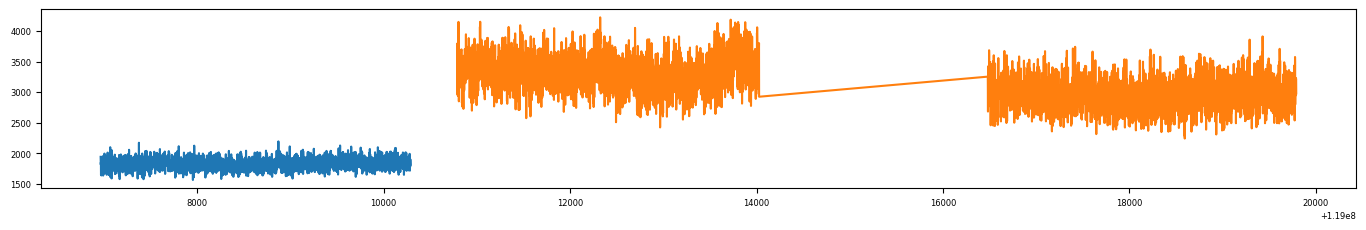

20402-01-49-01


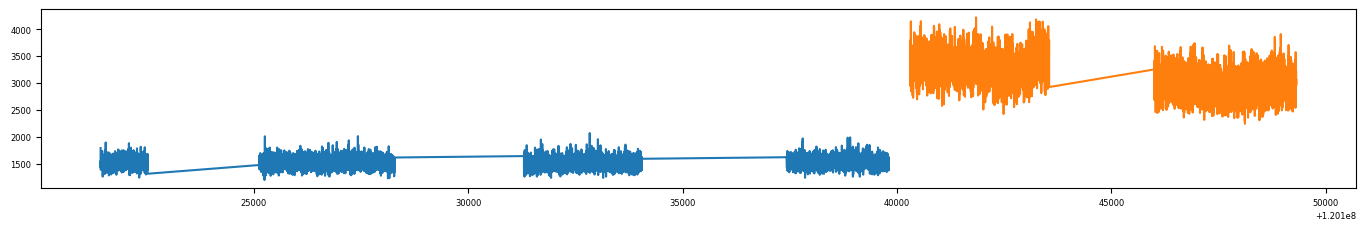

20402-01-51-00


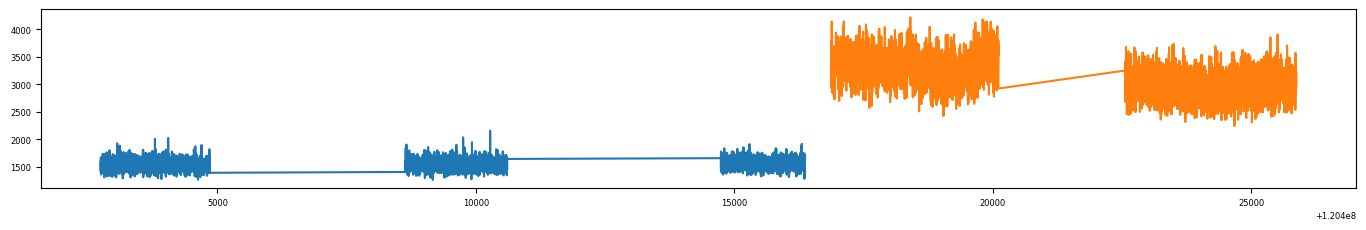

20402-01-52-00


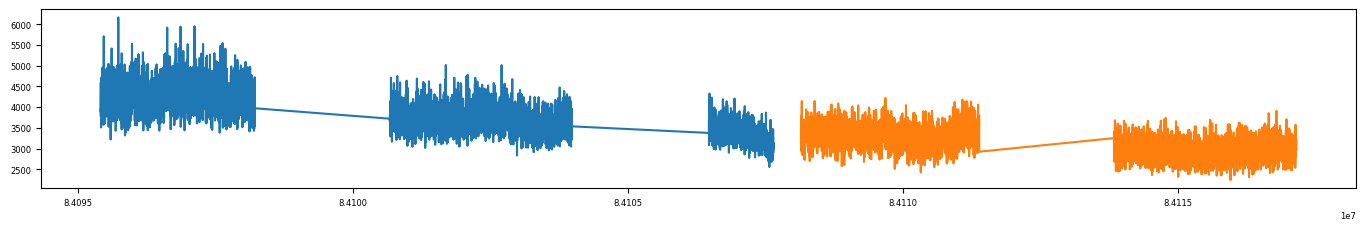

10408-01-32-00


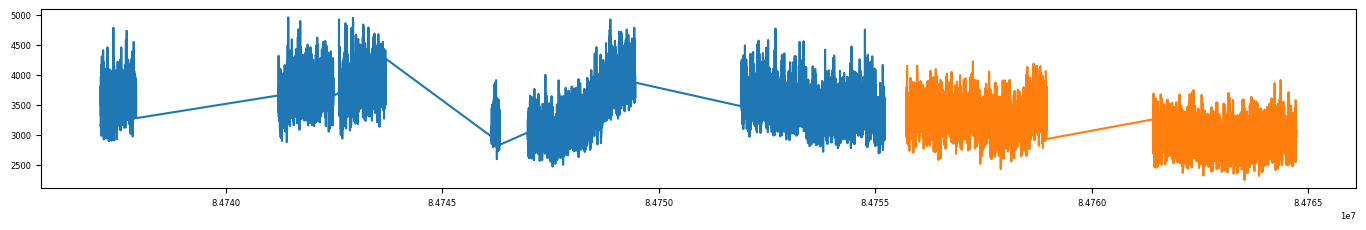

10408-01-33-00


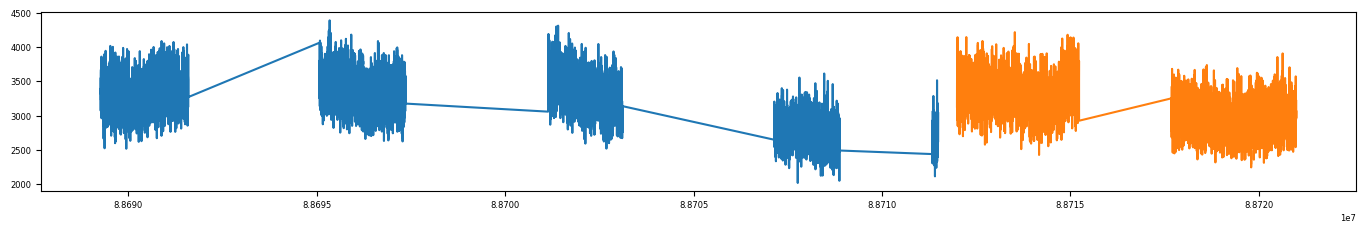

10408-01-43-00


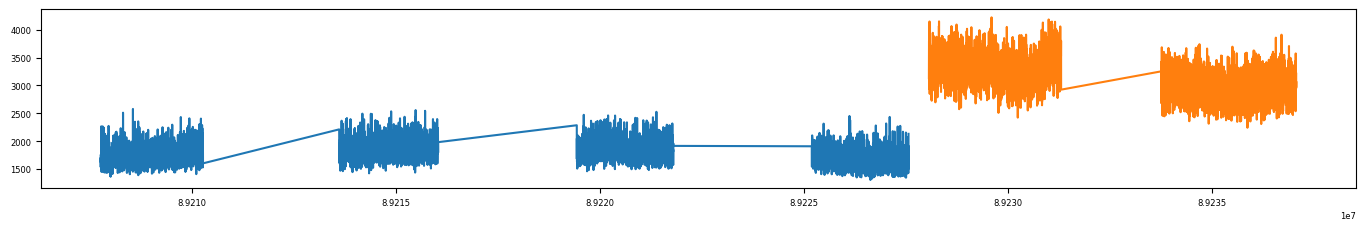

10408-01-45-00


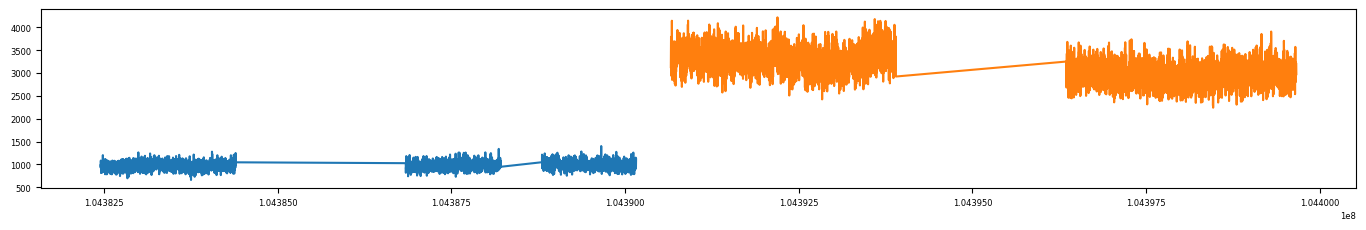

20402-01-24-00


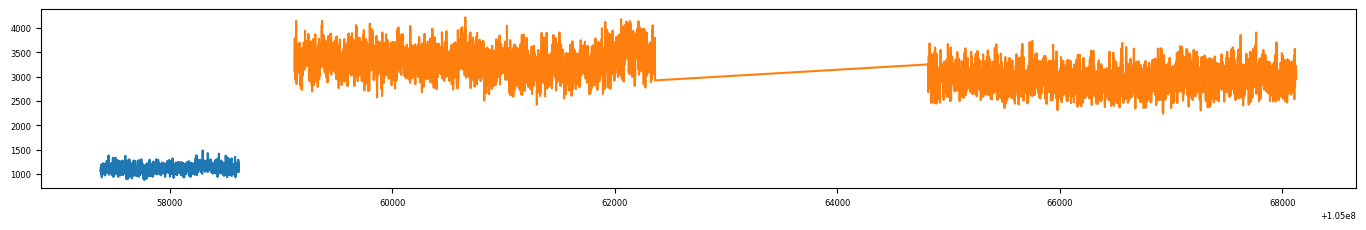

20402-01-26-01


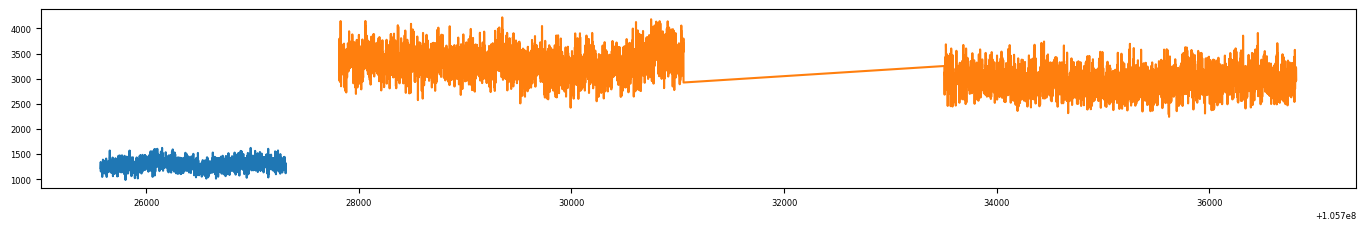

20402-01-27-01


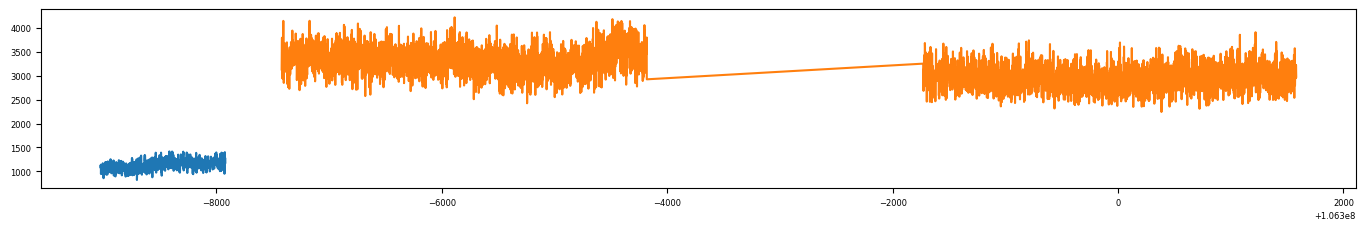

20402-01-27-03


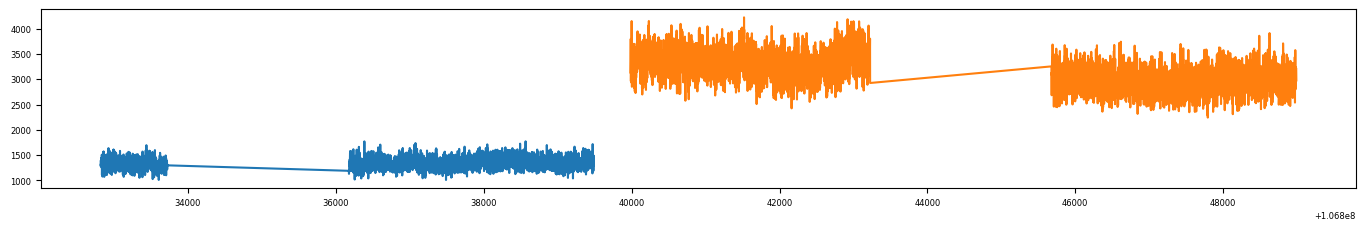

20402-01-29-00


In [74]:
plt.rcParams['figure.figsize'] = (16.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

misclass_lc_n = 5
misclass_lc = lcs[np.where(np.array(ids) == misclass.index[misclass_lc_n])[0][0]]
plt.plot(misclass_lc[0], misclass_lc[1])
plt.title("True Class {}".format(misclass.iloc[misclass_lc_n,:]["Class"]))
plt.show()

# list of ids of training observations for the class that was predicted
predicted_class_ids = [obid for obid in inv_ob_state[misclass.iloc[misclass_lc_n,:]["Prediction"]] if obid in train_data.index.values]
# list of ids of training observations for the true class of observation
true_class_ids = [obid for obid in inv_ob_state[misclass.iloc[misclass_lc_n,:]["Class"]] if obid in train_data.index.values]

print("Predicted Class", misclass.iloc[misclass_lc_n,:]["Prediction"])
for predicted_class_id in predicted_class_ids:
    predicted_class_lc = lcs[np.where(np.array(ids) == predicted_class_id)[0][0]]
    plt.plot(predicted_class_lc[0], predicted_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(predicted_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(predicted_class_id)
    
print("True Class", misclass.iloc[misclass_lc_n,:]["Class"])
for true_class_id in true_class_ids:
    
    true_class_lc = lcs[np.where(np.array(ids) == true_class_id)[0][0]]
    plt.plot(true_class_lc[0], true_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(true_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(true_class_id)

In [463]:
len(true_class_lc[0])

1864

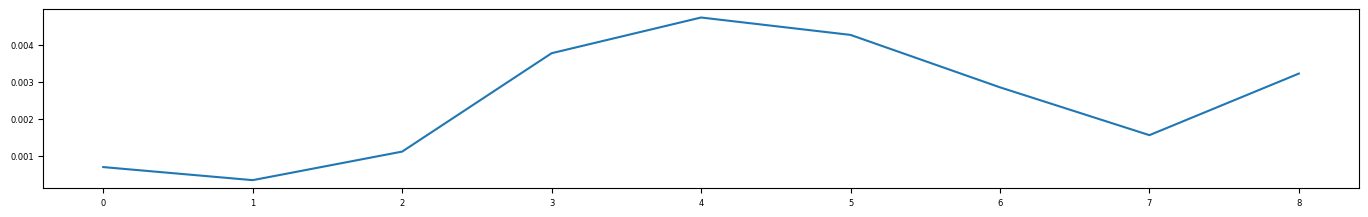

In [465]:
plt.plot(np.array([1,2,2,6,7,5,4,1,6])/np.array([1421,5674,1785,1593,1481,1174,1404,640,1864]))
plt.show()

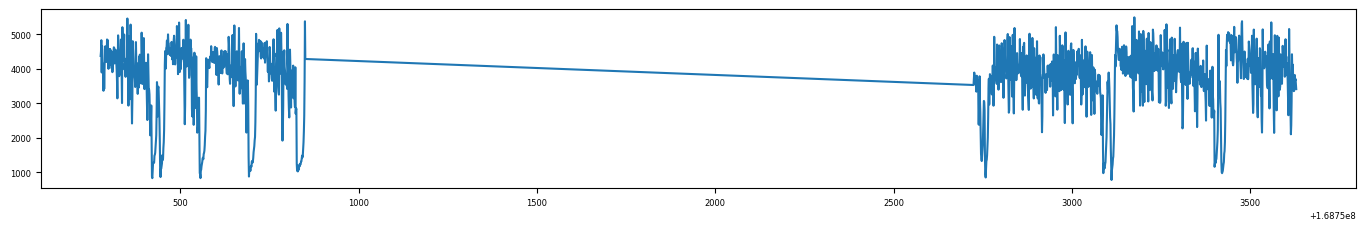

In [481]:
plt.rcParams['figure.figsize'] = (16.97, 6.97*(1/3))

true_class_lc = lcs[np.where(np.array(ids) == "40703-01-14-00")[0][0]]
plt.plot(true_class_lc[0], true_class_lc[1])
plt.show()

In [466]:
ob_state.keys()

dict_keys(['20187-02-01-00', '20187-02-01-01', '20402-01-22-00', '20402-01-23-00', '20402-01-24-01', '20402-01-27-00', '20402-01-28-00', '20402-01-30-02', '10408-01-10-00', '10408-01-21-00', '20402-01-43-02', '20402-01-44-00', '20402-01-45-03', '20402-01-46-00', '20402-01-52-01', '20402-01-52-02', '20402-01-53-00', '40703-01-18-00', '40703-01-19-00', '40703-01-19-01', '40703-01-22-00', '40703-01-22-01', '40703-01-35-00', '40703-01-35-01', '20402-01-37-00', '20402-01-37-02', '20402-01-38-00', '20402-01-39-00', '20402-01-39-02', '20402-01-40-00', '20402-01-55-00', '20402-01-56-00', '20402-01-57-00', '40703-01-13-00', '40115-01-07-00', '40703-01-31-00', '10408-01-14-00', '10408-01-14-01', '10408-01-14-02', '10408-01-14-03', '10408-01-14-04', '10408-01-14-05', '10408-01-14-07', '10408-01-14-08', '10408-01-14-09', '10408-01-17-00', '10408-01-17-03', '10408-01-18-01', '10408-01-18-04', '20402-01-41-00', '20402-01-41-01', '20402-01-41-03', '20402-01-42-00', '20402-01-54-00', '40703-01-33-01',

In [451]:
lcs_time = [lc[0][0] for lc in lcs]


In [809]:
for chrono_id in np.take(ids, np.argsort(np.array(lcs_time))):
    if chrono_id in ob_state.keys():
        start_time = lcs[np.where(np.array(ids) == chrono_id)[0][0]][0][0]
        print(chrono_id,start_time, ob_state[chrono_id])

10408-01-08-00 75260851.81593166 mu
10408-01-10-00 75749379.69093166 beta
10408-01-11-00 76159619.81593166 phi
10408-01-12-00 76592115.81593166 phi
10408-01-14-00 77155587.81593166 delta
10408-01-14-01 77161411.81593166 delta
10408-01-14-02 77167107.81593166 delta
10408-01-14-03 77172865.44093166 delta
10408-01-14-04 77178643.81593166 delta
10408-01-14-05 77190154.31593166 delta
10408-01-14-07 77195917.19093166 delta
10408-01-14-08 77201683.81593166 delta
10408-01-14-09 77207491.81593166 delta
10408-01-15-05 77553246.56593166 theta
10408-01-15-04 77559010.31593166 theta
10408-01-15-00 77564774.06593166 theta
10408-01-15-01 77570537.94093166 theta
10408-01-15-02 77576301.81593166 theta
10408-01-15-03 77582065.56593166 theta
10408-01-16-00 77812633.81593166 theta
10408-01-16-01 77818398.44093166 theta
10408-01-16-02 77824163.06593166 theta
10408-01-16-03 77829927.56593166 theta
10408-01-16-04 77837059.94093166 theta
10408-01-17-00 78072045.69093166 delta
10408-01-17-01 78083575.56593166 

In [93]:
misclass.iloc[misclass_lc_n,:]

Class         alpha
Prediction     beta
Name: 20402-01-30-02, dtype: object

In [79]:
misclass.iloc[0,:]["Prediction"]

Class         alpha
Prediction     beta
Name: 20402-01-30-02, dtype: object

In [324]:
misclass

Class Prediction
20402-01-30-02   alpha       beta
40703-01-35-01    beta      theta
40703-01-24-00   kappa        chi
40703-01-25-00   kappa        chi
20402-01-36-01  lambda      theta
10408-01-42-00     chi      gamma
40703-01-20-01     chi      gamma
40703-01-20-03     chi      gamma

In [81]:
inv_ob_state[misclass.iloc[0,:]["Prediction"]]

['10408-01-10-00',
 '10408-01-21-00',
 '20402-01-43-02',
 '20402-01-44-00',
 '20402-01-45-03',
 '20402-01-46-00',
 '20402-01-52-01',
 '20402-01-52-02',
 '20402-01-53-00',
 '40703-01-18-00',
 '40703-01-19-00',
 '40703-01-19-01',
 '40703-01-22-00',
 '40703-01-22-01',
 '40703-01-35-00',
 '40703-01-35-01']

In [330]:
test_data.loc[["40703-01-24-00", "40703-01-25-00"]]

0    1    2    3    4         5         6    7    8    9  \
40703-01-24-00  0.0  0.0  0.0  0.0  0.0  0.004469  0.217877  0.0  0.0  0.0   
40703-01-25-00  0.0  0.0  0.0  0.0  0.0  0.009223  0.192358  0.0  0.0  0.0   

                ...       213  214       215       216  217  218  219  220  \
40703-01-24-00  ...  0.000000  0.0  0.002235  0.002235  0.0  0.0  0.0  0.0   
40703-01-25-00  ...  0.001318  0.0  0.003953  0.000000  0.0  0.0  0.0  0.0   

                221  Class  
40703-01-24-00  0.0  kappa  
40703-01-25-00  0.0  kappa  

[2 rows x 223 columns]

In [429]:
UMAP_data[between_stars].index

Index(['20402-01-07-00', '30703-01-35-00'], dtype='object')

In [432]:
UMAP_data[(finger_UMAP.embedding_[:,1]>3)&(finger_UMAP.embedding_[:,0]>5) & (UMAP_data.Class =="chi") & (~UMAP_data.index.isin(['20402-01-07-00', '30703-01-35-00']))]

0         1         2         3         4    5    6  \
20402-01-27-01  0.006173  0.000000  0.012346  0.000000  0.012346  0.0  0.0   
40703-01-16-01  0.005525  0.110497  0.000000  0.000000  0.005525  0.0  0.0   
20186-03-02-06  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
20402-01-26-01  0.008929  0.000000  0.008929  0.000000  0.000000  0.0  0.0   
30402-01-11-00  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
20186-03-02-05  0.000000  0.000000  0.000000  0.000000  0.005405  0.0  0.0   
20402-01-04-00  0.025952  0.000000  0.050173  0.034602  0.019031  0.0  0.0   
40703-01-20-00  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
40703-01-38-01  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
40703-01-17-01  0.013436  0.000000  0.001919  0.001919  0.019194  0.0  0.0   
10408-01-30-00  0.000000  0.000000  0.000000  0.002066  0.000000  0.0  0.0   
20402-01-27-03  0.000000  0.000000  0.020408  0.010204  0.000000  0.0  0.0   
40703-01-38-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
20402-01-08-01  0.006270  0.000000  0.021944  0.006270  0.003135  0.0  0.0   
10408-01-32-00  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
10408-01-31-00  0.000000  0.000000  0.000000  0.000000  0.004689  0.0  0.0   
10408-01-33-00  0.000000  0.000000  0.000000  0.004768  0.000000  0.0  0.0   
10408-01-43-00  0.000000  0.000000  0.000000  0.020382  0.000000  0.0  0.0   
40703-01-21-01  0.010909  0.000000  0.000000  0.000000  0.018182  0.0  0.0   
40703-01-17-00  0.013889  0.000000  0.000000  0.000000  0.013889  0.0  0.0   
40703-01-20-02  0.000000  0.000000  0.000000  0.000000  0.000000  0.0  0.0   
20402-01-29-00  0.012723  0.000000  0.033079  0.002545  0.002545  0.0  0.0   
20402-01-05-00  0.013187  0.000000  0.039560  0.013187  0.018681  0.0  0.0   
20402-01-09-00  0.000000  0.000000  0.004225  0.000000  0.001408  0.0  0.0   

                       7         8         9  ...  213  214  215  216  \
20402-01-27-01  0.006173  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-16-01  0.016575  0.005525  0.000000  ...  0.0  0.0  0.0  0.0   
20186-03-02-06  0.000000  0.068528  0.080372  ...  0.0  0.0  0.0  0.0   
20402-01-26-01  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
30402-01-11-00  0.000000  0.080374  0.108411  ...  0.0  0.0  0.0  0.0   
20186-03-02-05  0.000000  0.156757  0.118919  ...  0.0  0.0  0.0  0.0   
20402-01-04-00  0.001730  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-20-00  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-38-01  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-17-01  0.046065  0.003839  0.000000  ...  0.0  0.0  0.0  0.0   
10408-01-30-00  0.001033  0.080579  0.051653  ...  0.0  0.0  0.0  0.0   
20402-01-27-03  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-38-02  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
20402-01-08-01  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
10408-01-32-00  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
10408-01-31-00  0.000000  0.175850  0.094959  ...  0.0  0.0  0.0  0.0   
10408-01-33-00  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
10408-01-43-00  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-21-01  0.025455  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-17-00  0.018519  0.009259  0.000000  ...  0.0  0.0  0.0  0.0   
40703-01-20-02  0.000000  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
20402-01-29-00  0.007634  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
20402-01-05-00  0.006593  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   
20402-01-09-00  0.001408  0.000000  0.000000  ...  0.0  0.0  0.0  0.0   

                     217  218  219  220       221  Class  
20402-01-27-01  0.000000  0.0  0.0  0.0  0.000000    chi  
40703-01-16-01  0.055249  0.0  0.0  0.0  0.000000    chi  
20186-03-02-06  0.000000  0.0  0.0  0.0  0.000000    chi  
20402-01-2

In [441]:
len((train_data["Class"]=="kappa"))

137

In [158]:
UMAP_data

1         4         5    6         7         8  \
10408-01-10-00  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
20402-01-45-03  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
20402-01-53-00  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
40703-01-22-01  0.000000  0.008333  0.000000  0.0  0.008333  0.000000   
40703-01-19-00  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
20402-01-46-00  0.001130  0.000000  0.000000  0.0  0.000000  0.000000   
20402-01-52-01  0.006667  0.000000  0.000000  0.0  0.000000  0.000000   
20402-01-44-00  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
20402-01-52-02  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
10408-01-21-00  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
20186-03-02-00  0.000000  0.000000  0.009225  0.0  0.000000  0.000923   
10408-01-15-05  0.000000  0.000000  0.007634  0.0  0.000000  0.000000   
40703-01-36-02  0.000000  0.000000  0.010135  0.0  0.000000  0.000000   
10408-01-15-01  0.000000  0.000000  0.021552  0.0  0.000000  0.000000   
10408-01-16-03  0.000000  0.000000  0.013333  0.0  0.000000  0.000000   
20402-01-45-02  0.000000  0.000000  0.009796  0.0  0.000000  0.000000   
40703-01-38-03  0.000000  0.000000  0.008889  0.0  0.000000  0.000000   
10408-01-16-01  0.000000  0.000000  0.026549  0.0  0.000000  0.000000   
10408-01-16-04  0.000000  0.000000  0.031250  0.0  0.000000  0.000000   
10408-01-16-00  0.000000  0.000000  0.013575  0.0  0.000000  0.000000   
10408-01-15-02  0.000000  0.004310  0.012931  0.0  0.000000  0.000000   
10408-01-15-00  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   

                      10        11   12   13  ...  219  220  221       222  \
10408-01-10-00  0.009509  0.026941  0.0  0.0  ...  0.0  0.0  0.0  0.019017   
20402-01-45-03  0.011364  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.035124   
20402-01-53-00  0.012642  0.008850  0.0  0.0  ...  0.0  0.0  0.0  0.007585   
40703-01-22-01  0.033333  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.600000   
40703-01-19-00  0.006826  0.006826  0.0  0.0  ...  0.0  0.0  0.0  0.539249   
20402-01-46-00  0.021469  0.001130  0.0  0.0  ...  0.0  0.0  0.0  0.044068   
20402-01-52-01  0.026667  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.053333   
20402-01-44-00  0.014085  0.007825  0.0  0.0  ...  0.0  0.0  0.0  0.051643   
20402-01-52-02  0.017143  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.022857   
10408-01-21-00  0.020134  0.026846  0.0  0.0  ...  0.0  0.0  0.0  0.000000   
20186-03-02-00  0.004613  0.008303  0.0  0.0  ...  0.0  0.0  0.0  0.150369   
10408-01-15-05  0.007634  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.099237   
40703-01-36-02  0.020270  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.043919   
10408-01-15-01  0.030172  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.043103   
10408-01-16-03  0.026667  0.008889  0.0  0.0  ...  0.0  0.0  0.0  0.048889   
20402-01-45-02  0.004898  0.008163  0.0  0.0  ...  0.0  0.0  0.0  0.142857   
40703-01-38-03  0.000000  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.057778   
10408-01-16-01  0.008850  0.004425  0.0  0.0  ...  0.0  0.0  0.0  0.035398   
10408-01-16-04  0.015625  0.000000  0.0  0.0  ...  0.0  0.0  0.0  0.015625   
10408-01-16-00  0.000000  0.022624  0.0  0.0  ...  0.0  0.0  0.0  0.099548   
10408-01-15-02  0.025862  0.004310  0.0  0.0  ...  0.0  0.0  0.0  0.064655   
10408-01-15-00  0.034483  0.004310  0.0  0.0  ...  0.0  0.0  0.0  0.060345   

                     223  224       225       226  227  Class  
10408-01-10-00  0.000000  0.0  0.000000  0.000000  0.0   beta  
20402-01-45-03  0.000000  0.0  0.003099  0.000000  0.0   beta  
20402-01-53-00  0.001264  0.0  0.001264  0.000000  0.0   beta  
40703-01-22-01  0.008333  0.0  0.000000  0.016667  0.0   beta  
40703-01-19-00  0.006826  0.0  0.000000  0.000000  0.0   beta  
20402-01-46-00  0.000000  0.0  0.001130  0.001130  0.0   beta  
20402-01-52-01  0.013333  0.0  0.000000  0.000000  0.0   beta  
20402-01-44-00  0.003130  0.0  0.000

In [452]:
heatmap_data = train_data[(train_data["Class"]=="kappa")& ~train_data.index.isin(['20402-01-33-00', '20402-01-35-00'])].iloc[:,:-1]
heatmap_data = heatmap_data.append(train_data.loc[['20402-01-33-00', '20402-01-35-00']].iloc[:,:-1])   
heatmap_data = heatmap_data.append(test_data.loc[["40703-01-24-00", "40703-01-25-00"]].iloc[:,:-1]) # kappa
heatmap_data = heatmap_data.append(UMAP_data[between_stars].iloc[:,:-1]) # chi
heatmap_data = heatmap_data.append(UMAP_data[(finger_UMAP.embedding_[:,1]>3)&(finger_UMAP.embedding_[:,1]<6)&(finger_UMAP.embedding_[:,0]>5) & (UMAP_data.Class =="chi") & (~UMAP_data.index.isin(['20402-01-07-00', '30703-01-35-00']))].iloc[:,:-1])

# heatmap_data = heatmap_data.append(train_data[(train_data["Class"]=="chi")].iloc[:,:-1])

# heatmap_data = heatmap_data.iloc[:,:].div(np.sum(heatmap_data.iloc[:,:], axis=1), axis="rows")

In [172]:
test_data.loc[misclass.index[misclass_lc_n]].to_frame().T

1         4  5  6  7  8        10        11 12 13  ... 219  \
40703-01-35-01  0  0.003663  0  0  0  0  0.025641  0.003663  0  0  ...   0   

               220 221       222         223 224 225 226 227 Class  
40703-01-35-01   0   0  0.150183  0.00732601   0   0   0   0  beta  

[1 rows x 181 columns]

In [209]:
UMAP_data = train_data[training_obs_predicted_class_filter | training_obs_true_class_filter]
# UMAP_data.append(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T)

In [ ]:
misclass_lc_n=1

In [291]:
import umap
training_obs_predicted_class_filter = (train_data["Class"]==misclass.iloc[misclass_lc_n,:]["Prediction"])
training_obs_true_class_filter = (train_data["Class"]==misclass.iloc[misclass_lc_n,:]["Class"])
training_obs_lambda_class_filter = (train_data["Class"]=="lambda")

UMAP_data = train_data[training_obs_predicted_class_filter | training_obs_true_class_filter]
UMAP_data.append(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T)
finger_UMAP = umap.UMAP(random_state=0).fit(UMAP_data.iloc[:,:-1])
# misclas_UMAP = finger_UMAP.transform(test_data.loc[misclass.index[misclass_lc_n]].iloc[:-1].values.reshape(1, -1))

/export/data/jakubok/software/anaconda3/envs/py37/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


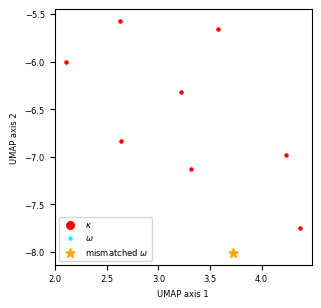

In [292]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})

training_lcs_predicted_class = UMAP_data["Class"] == misclass.iloc[misclass_lc_n,:]["Prediction"]
# training_lcs_true_class = (UMAP_data["Class"] == misclass.iloc[misclass_lc_n,:]["Class"]) & ()

first_class = training_obs_predicted_class_filter.sum()
second_class = training_obs_predicted_class_filter.sum()+training_obs_true_class_filter.sum()
# third_class = training_obs_predicted_class_filter.sum()+training_obs_true_class_filter.sum()+training_obs_lambda_class_filter.sum()

plt.scatter(finger_UMAP.embedding_[:first_class, 0], finger_UMAP.embedding_[:first_class, 1],s=5,zorder=2, c="red", label=r"$\{}$".format(misclass.iloc[misclass_lc_n,:]["Prediction"]))
plt.scatter(finger_UMAP.embedding_[first_class:second_class, 0],
            finger_UMAP.embedding_[first_class:second_class, 1],s=5,zorder=2, c="cyan", label=r"$\{}$".format(misclass.iloc[misclass_lc_n,:]["Class"]))

# plt.scatter(finger_UMAP.embedding_[second_class:third_class, 0],
#             finger_UMAP.embedding_[second_class:third_class, 1],s=5,zorder=2, c="magenta", label=r"$\{}$".format("lambda"))

plt.scatter(finger_UMAP.embedding_[-1, 0], finger_UMAP.embedding_[-1, 1],s=50,zorder=2,marker="*", c="orange", label=r"mismatched $\{}$".format(misclass.iloc[misclass_lc_n,:]["Class"]))
# plt.scatter(finger_UMAP.embedding_[-1, 0], finger_UMAP.embedding_[-1:, 1],s=50,zorder=2,marker="*", c="orange", label=r"mismatched $\{}$".format(misclass.iloc[misclass_lc_n,:]["Class"]))


lgnd = plt.legend(fontsize=6)

#change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# lgnd.legendHandles[2]._sizes = [50]
# lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

# plt.savefig('figures/UMAP_misclassified_two_kappa_as_chi.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.05)

# plt.xlim([5,8])
# plt.ylim([3,6])



plt.show()

In [244]:
finger_UMAP.embedding_[:,1]>11

array([False, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True, False, False, False,  True,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False,  True, False, False, False, False,
        True, False,  True, False, False,  True, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False, False,  True,  True, False, False, False,  True,  True,
        True,  True])

In [246]:
heatmap_data#[finger_UMAP.embedding_[:,1]>11]

1           4  5  6           7  8          10          11  \
10408-01-10-00  0           0  0  0           0  0  0.00950872   0.0269414   
20402-01-45-03  0           0  0  0           0  0   0.0113636           0   
20402-01-53-00  0           0  0  0           0  0   0.0126422  0.00884956   
40703-01-22-01  0  0.00833333  0  0  0.00833333  0   0.0333333           0   
40703-01-19-00  0           0  0  0           0  0  0.00682594  0.00682594   
...            ..         ... .. ..         ... ..         ...         ...   
40703-01-20-02  0           0  0  0           0  0           0           0   
30703-01-35-00  0  0.00204918  0  0  0.00204918  0           0           0   
20402-01-29-00  0  0.00254453  0  0  0.00763359  0           0           0   
20402-01-05-00  0   0.0186813  0  0  0.00659341  0           0           0   
20402-01-09-00  0  0.00140845  0  0  0.00140845  0           0           0   

                        12 13  ... 219 220        221         222         223  \
10408-01-10-00           0  0  ...   0   0          0   0.0190174           0   
20402-01-45-03           0  0  ...   0   0          0    0.035124           0   
20402-01-53-00           0  0  ...   0   0          0  0.00758534  0.00126422   
40703-01-22-01           0  0  ...   0   0          0         0.6  0.00833333   
40703-01-19-00           0  0  ...   0   0          0    0.539249  0.00682594   
...                    ... ..  ...  ..  ..        ...         ...         ...   
40703-01-20-02           0  0  ...   0   0          0    0.971831           0   
30703-01-35-00  0.00204918  0  ...   0   0          0    0.129098  0.00204918   
20402-01-29-00           0  0  ...   0   0          0    0.302799   0.0101781   
20402-01-05-00   0.0010989  0  ...   0   0          0    0.248352  0.00989011   
20402-01-09-00           0  0  ...   0   0  0.0028169    0.111268   0.0028169   

               224         225        226 227 Class  
10408-01-10-00   0           0          0   0  beta  
20402-01-45-03   0  0.00309917          0   0  beta  
20402-01-53-00   0  0.00126422          0   0  beta  
40703-01-22-01   0           0  0.0166667   0  beta  
40703-01-19-00   0           0          0   0  beta  
...             ..         ...        ...  ..   ...  
40703-01-20-02   0   0.0140845          0   0   chi  
30703-01-35-00   0           0  0.0245902   0   chi  
20402-01-29-00   0           0  0.0483461   0   chi  
20402-01-05-00   0           0  0.0527473   0   chi  
20402-01-09-00   0           0  0.0253521   0   chi  

[65 rows x 181 columns]

In [299]:
val_set_ids = split_ob_ids[1]
val_data = obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"]

In [301]:
obs_component_counts_df_comp.loc[obs_component_counts_df_comp.iloc[:,-1] == "omega"]

1    4         5    6    7    8   10        11   12   13  \
40703-01-13-01  0.0  0.0  0.001931  0.0  0.0  0.0  0.0  0.001931  0.0  0.0   
40703-01-27-00  0.0  0.0  0.012422  0.0  0.0  0.0  0.0  0.006211  0.0  0.0   
40703-01-29-01  0.0  0.0  0.007692  0.0  0.0  0.0  0.0  0.000000  0.0  0.0   

                ...  219  220  221  222  223  224       225  226       227  \
40703-01-13-01  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.017375  0.0  0.822394   
40703-01-27-00  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.012422  0.0  0.453416   
40703-01-29-01  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.0  0.784615   

                Class  
40703-01-13-01  omega  
40703-01-27-00  omega  
40703-01-29-01  omega  

[3 rows x 181 columns]

In [338]:
misclass

Class Prediction
40703-01-35-01    beta      theta
40703-01-19-01    beta        chi
20402-01-36-01  lambda      theta
10408-01-40-00      nu        rho
40703-01-29-01   omega      kappa

In [320]:
heatmap_data.columns.values

array([1, 4, 5, 6, 7, 8, 10, 11, 12, 13, 16, 17, 18, 19, 21, 22, 23, 24,
       25, 26, 29, 30, 32, 33, 34, 36, 37, 38, 39, 40, 42, 43, 44, 45, 46,
       47, 48, 49, 50, 51, 52, 55, 56, 57, 59, 60, 63, 64, 65, 67, 68, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104,
       105, 107, 108, 109, 111, 112, 114, 115, 117, 118, 119, 120, 121,
       123, 124, 125, 126, 128, 129, 130, 131, 133, 134, 135, 136, 138,
       139, 140, 141, 142, 143, 144, 145, 148, 149, 150, 151, 153, 155,
       156, 157, 158, 159, 160, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195,
       199, 202, 203, 205, 206, 207, 209, 210, 211, 213, 214, 215, 216,
       217, 218, 219, 220, 221, 'Class'], dtype=object)

In [76]:
# heatmap_data = train_data[training_obs_true_class_filter]
heatmap_data = obs_component_counts_df_comp.loc[obs_component_counts_df_comp.iloc[:,-1] == "omega"]
# heatmap_data = heatmap_data.append(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T)
# heatmap_data = heatmap_data.append(train_data[training_obs_predicted_class_filter])
heatmap_data = heatmap_data.append(obs_component_counts_df_comp.loc[obs_component_counts_df_comp.iloc[:,-1] == "kappa"])

In [77]:
new_cluster_order_merged = [col for col in new_cluster_order if col in heatmap_data.columns.values]

NameError: name 'new_cluster_order' is not defined

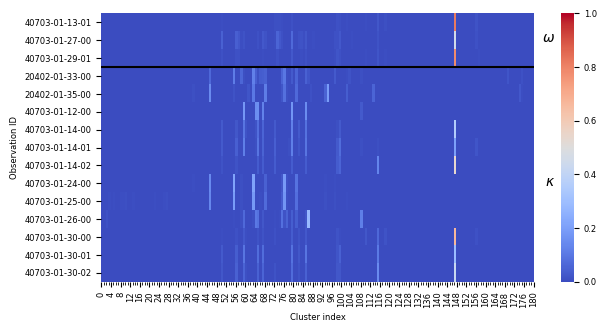

In [378]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(5/10))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(heatmap_data.iloc[:,:-1].astype(float)[new_cluster_order_merged],vmin=0, vmax=1, xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
ax.hlines([3], *ax.get_xlim(),colors=["black"])
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(AutoMinorLocator())

ax.text(1.05,14/15,r"$\{}$".format("omega"), ha='right', va='top', transform=ax.transAxes, size=10)
ax.text(1.05,6/15,r"$\{}$".format("kappa"), ha='right', va='top', transform=ax.transAxes, size=10)

plt.xlabel("Cluster index")
plt.ylabel("Observation ID")

# plt.savefig('figures/omega_kappa_fingerprints.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)


plt.show()

In [570]:
heatmap_data.index.values

array(['40703-01-13-01', '40703-01-27-00', '40703-01-29-01',
       '20402-01-33-00', '20402-01-35-00', '40703-01-12-00',
       '40703-01-14-00', '40703-01-14-01', '40703-01-14-02',
       '40703-01-24-00', '40703-01-25-00', '40703-01-26-00',
       '40703-01-30-00', '40703-01-30-01', '40703-01-30-02'], dtype=object)

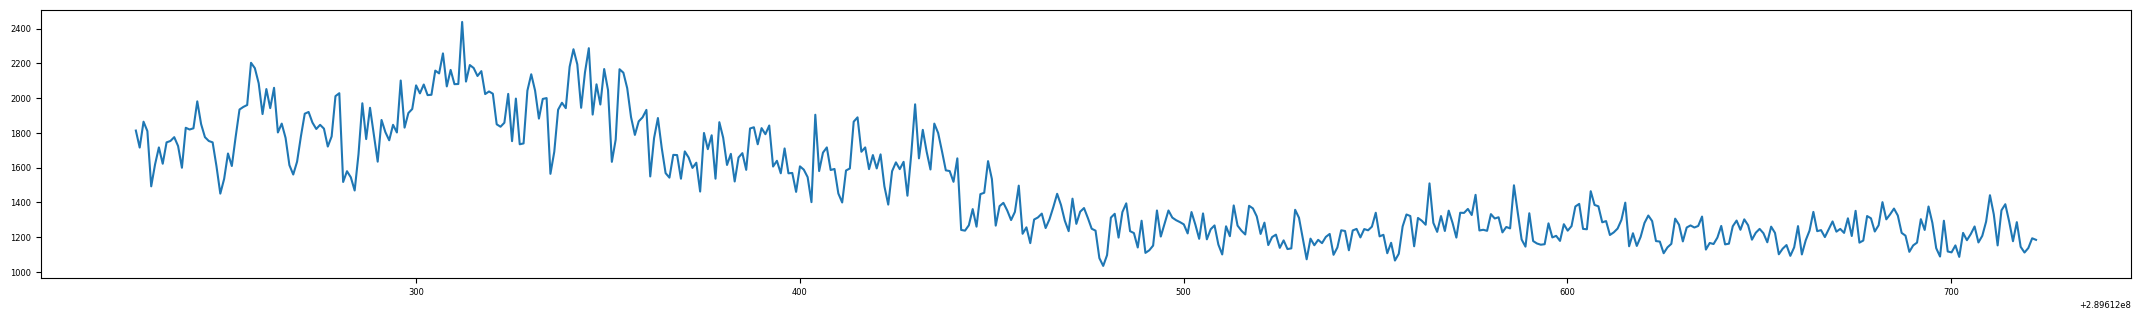

In [537]:
plt.rcParams['figure.figsize'] = (26.97, 6.97*(5/10))

true_class_lc = lcs[np.where(np.array(ids) == "80127-01-01-00")[0][0]]
plt.plot(true_class_lc[0], true_class_lc[1])
plt.show()

In [542]:
true_class_lc[0].shape

(496,)

In [366]:
np.mean(np.hstack((true_class_lc[1][:900],true_class_lc[1][-200:])))

3772.2136363636364

In [351]:
import umap
# training_obs_predicted_class_filter = (train_data["Class"]==misclass.iloc[misclass_lc_n,:]["Prediction"])
# training_obs_true_class_filter = (train_data["Class"]==misclass.iloc[misclass_lc_n,:]["Class"])
# training_obs_lambda_class_filter = (train_data["Class"]=="lambda")

# UMAP_data = train_data[training_obs_predicted_class_filter | training_obs_true_class_filter]
# UMAP_data.append(test_data.loc[misclass.index[misclass_lc_n]].to_frame().T)
finger_UMAP = umap.UMAP(random_state=0).fit(heatmap_data.iloc[:,:-1].astype(float)[new_cluster_order_merged])
# misclas_UMAP = finger_UMAP.transform(test_data.loc[misclass.index[misclass_lc_n]].iloc[:-1].values.reshape(1, -1))

/export/data/jakubok/software/anaconda3/envs/py37/lib/python3.7/site-packages/umap/umap_.py:1679: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  "n_neighbors is larger than the dataset size; truncating to "


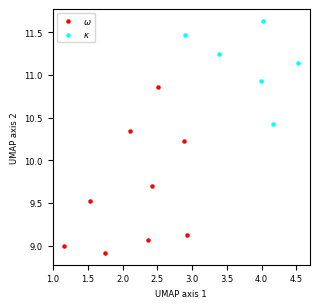

In [367]:
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})


plt.scatter(finger_UMAP.embedding_[:3, 0],
            finger_UMAP.embedding_[:3, 1],s=5,zorder=2, c="red", label=r"$\{}$".format("omega"))
plt.scatter(finger_UMAP.embedding_[6:9, 0],
            finger_UMAP.embedding_[6:9, 1],s=5,zorder=2, c="red")
plt.scatter(finger_UMAP.embedding_[12:15, 0],
            finger_UMAP.embedding_[12:15, 1],s=5,zorder=2, c="red")

plt.scatter(finger_UMAP.embedding_[3:6, 0],
            finger_UMAP.embedding_[3:6, 1],s=5,zorder=2, c="cyan", label=r"$\{}$".format("kappa"))
plt.scatter(finger_UMAP.embedding_[9:12, 0],
            finger_UMAP.embedding_[9:12, 1],s=5,zorder=2, c="cyan")

lgnd = plt.legend(fontsize=6, loc="upper left")

#change the marker size manually for both lines
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[0]._sizes = [30]
# lgnd.legendHandles[1]._sizes = [30]
# lgnd.legendHandles[2]._sizes = [50]
# lgnd.legendHandles[3]._sizes = [30]

plt.xlabel("UMAP axis 1")
plt.ylabel("UMAP axis 2")

# plt.savefig('figures/UMAP_misclassified_two_kappa_as_chi.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.05)

# plt.xlim([5,8])
# plt.ylim([3,6])



plt.show()

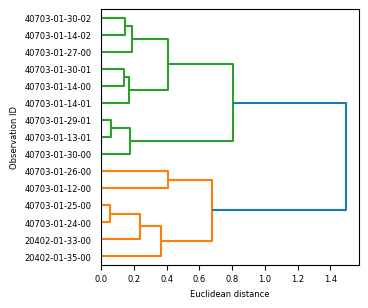

In [381]:
import scipy.cluster.hierarchy as sch
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})

linkage = sch.linkage(heatmap_data.iloc[:,:-1].astype(float), method="ward", metric="euclidean")
dendrogram = sch.dendrogram(linkage, truncate_mode=None, leaf_font_size = 6, labels=heatmap_data.index.values, orientation='right')
axis = plt.gca()
# axis.tick_params(axis="x", which="major", length=0, width=0, labelsize=0, direction="in")
# axis.set_xticks([])
# axis.set_xticklabels([])
# axis.set_ylabel("euclidean distance", size=6, x=1)

axis.set_xlabel("Euclidean distance")
axis.set_ylabel("Observation ID")

# plt.savefig('figures/agglomerative_dendogram.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.savefig('figures/omega_kappa_dendogram.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()

# from sklearn.metrics import silhouette_score
# from sklearn.metrics import calinski_harabasz_score

# plt.rcParams['figure.figsize'] = (3.32, 3.32*(1/1))


# y_top_limit = linkage[-1][2]
# y_bottom_limit = linkage[0][2]

# no_clusters = []
# silhouette_scores = []
# for distance in np.linspace(y_bottom_limit,y_top_limit,1000)[:-1]:
#     clusters = sch.fcluster(linkage, distance, criterion='distance')


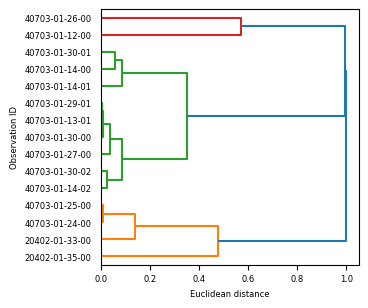

In [495]:
import scipy.cluster.hierarchy as sch
plt.rcParams['figure.figsize'] = (3.32, 3.32)#6.97)
plt.rcParams.update({'font.size': 6})

linkage = sch.linkage(heatmap_data.iloc[:,:-1].astype(float), method="complete", metric="cosine")
dendrogram = sch.dendrogram(linkage, truncate_mode=None, leaf_font_size = 6, labels=heatmap_data.index.values, orientation='right')
axis = plt.gca()
# axis.tick_params(axis="x", which="major", length=0, width=0, labelsize=0, direction="in")
# axis.set_xticks([])
# axis.set_xticklabels([])
# axis.set_ylabel("euclidean distance", size=6, x=1)

axis.set_xlabel("Euclidean distance")
axis.set_ylabel("Observation ID")

# plt.savefig('figures/agglomerative_dendogram.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.savefig('figures/omega_kappa_dendogram.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()

# from sklearn.metrics import silhouette_score
# from sklearn.metrics import calinski_harabasz_score

# plt.rcParams['figure.figsize'] = (3.32, 3.32*(1/1))


# y_top_limit = linkage[-1][2]
# y_bottom_limit = linkage[0][2]

# no_clusters = []
# silhouette_scores = []
# for distance in np.linspace(y_bottom_limit,y_top_limit,1000)[:-1]:
#     clusters = sch.fcluster(linkage, distance, criterion='distance')


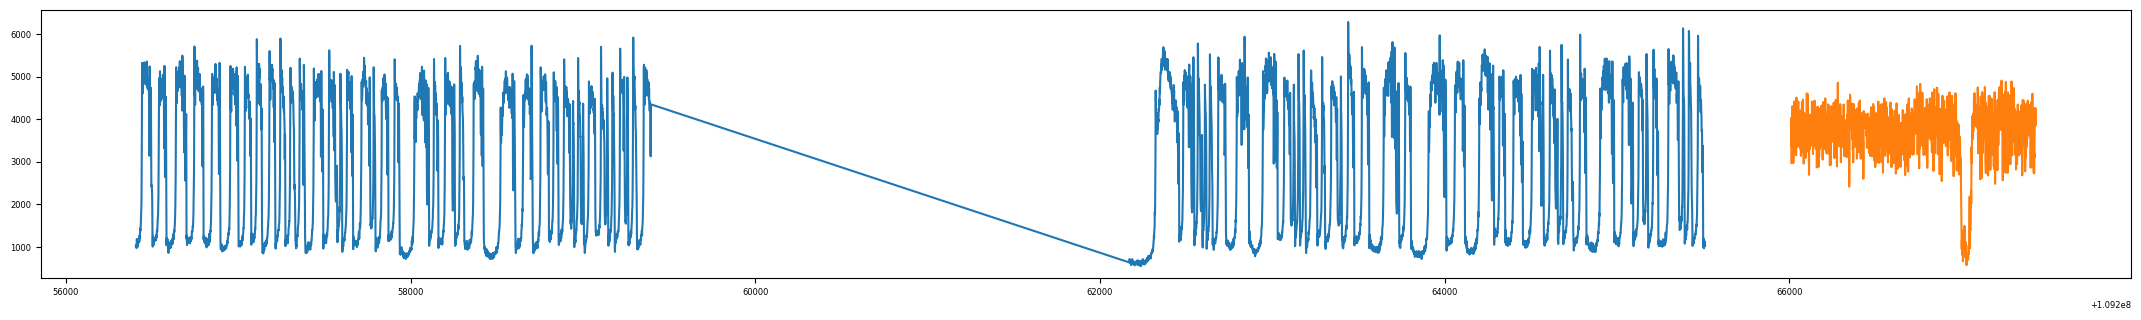

20402-01-33-00


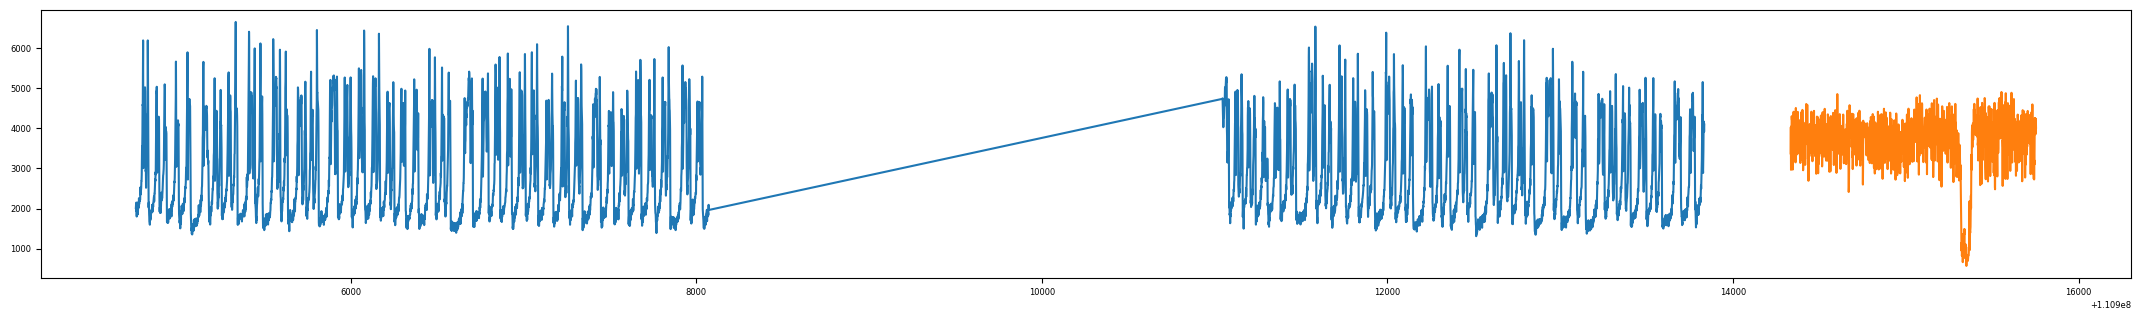

20402-01-35-00


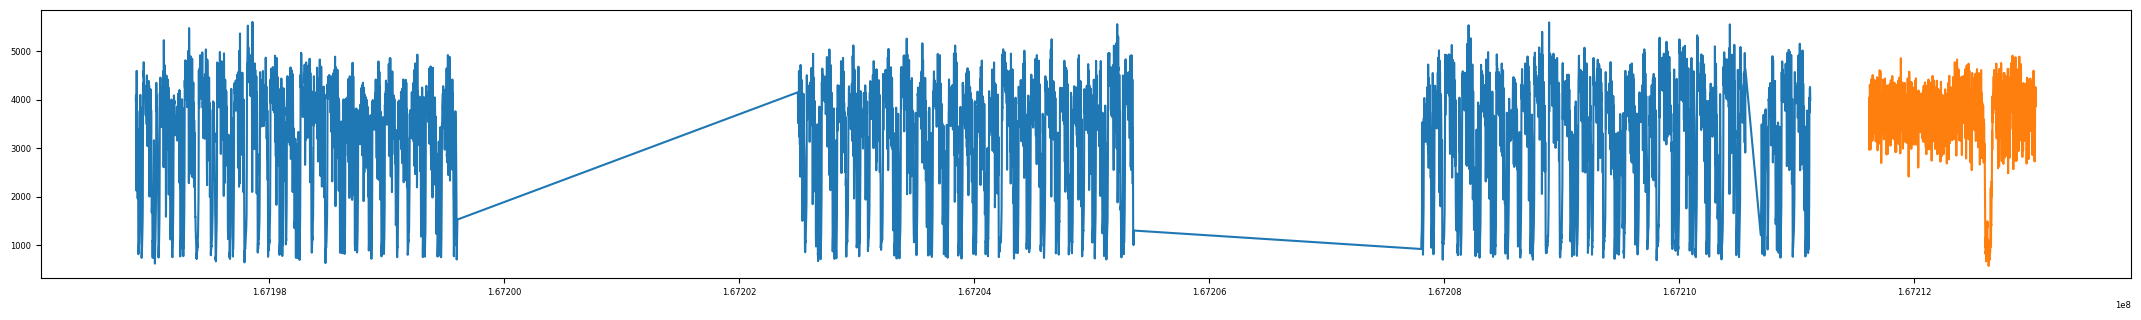

40703-01-12-00


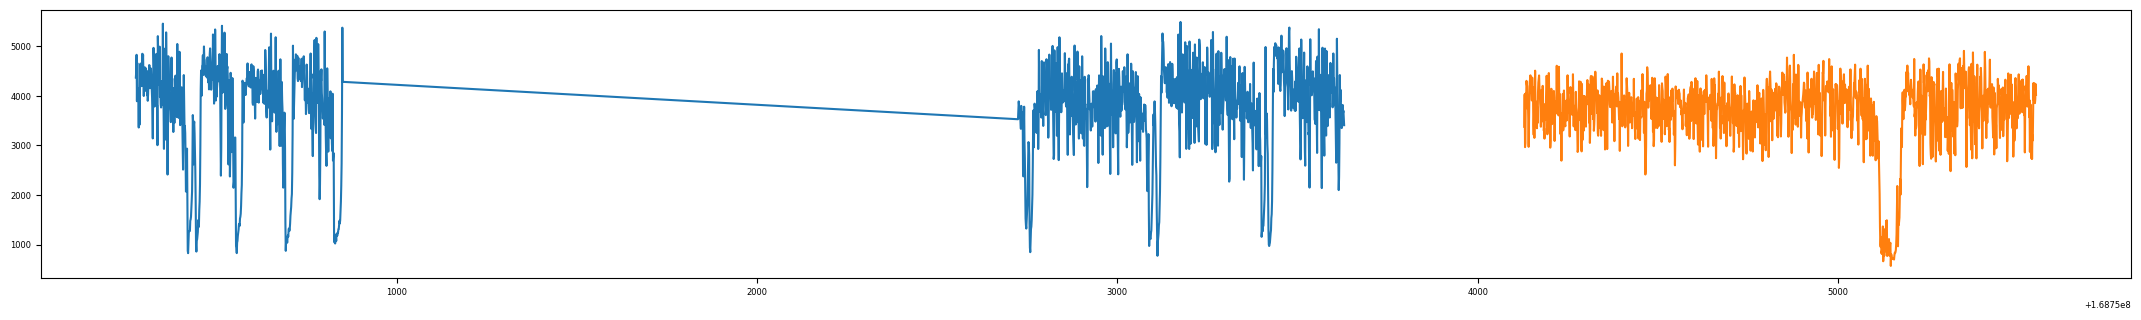

40703-01-14-00


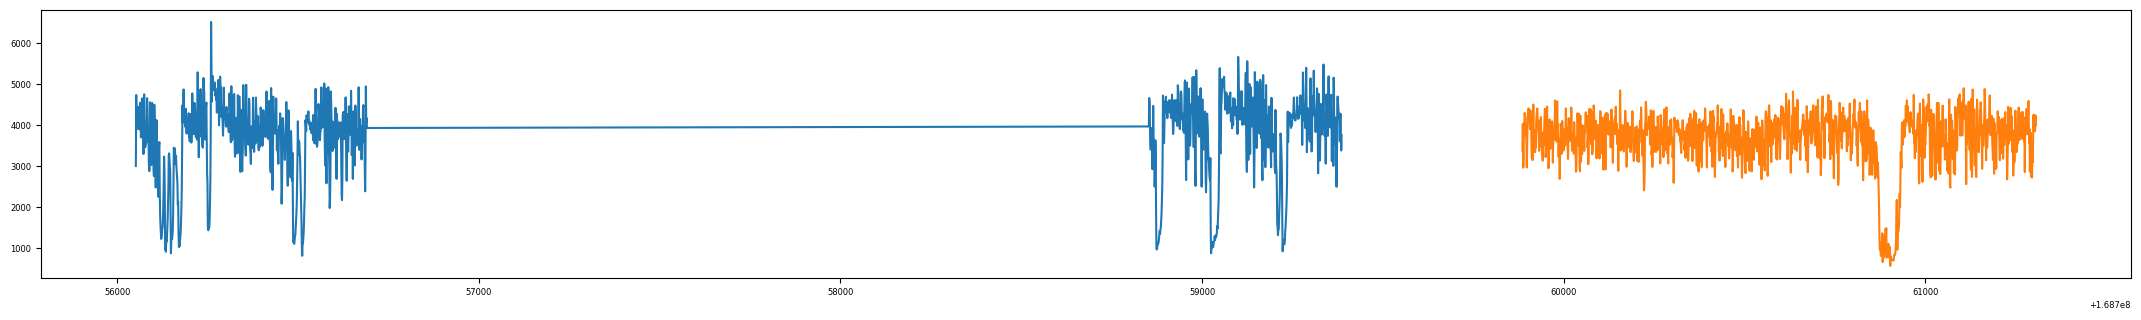

40703-01-14-01


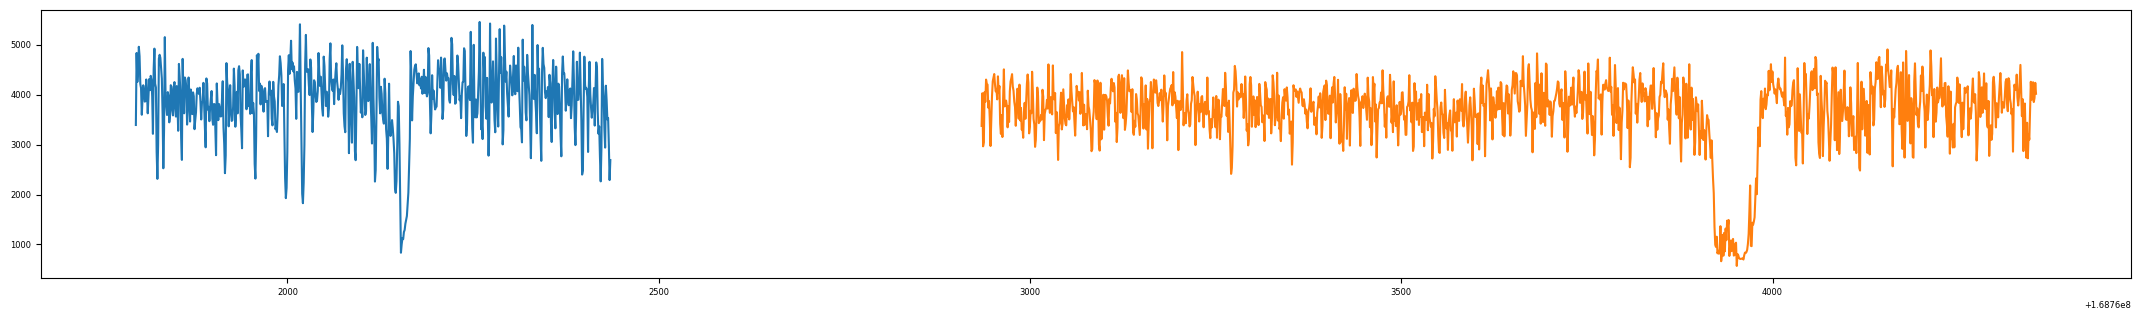

40703-01-14-02


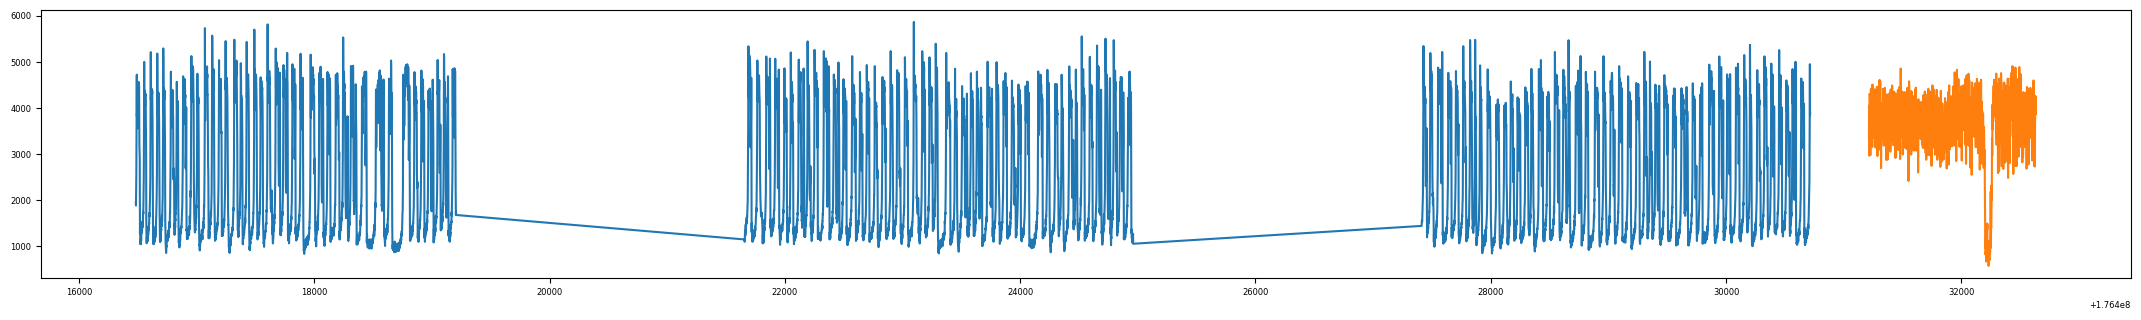

40703-01-24-00


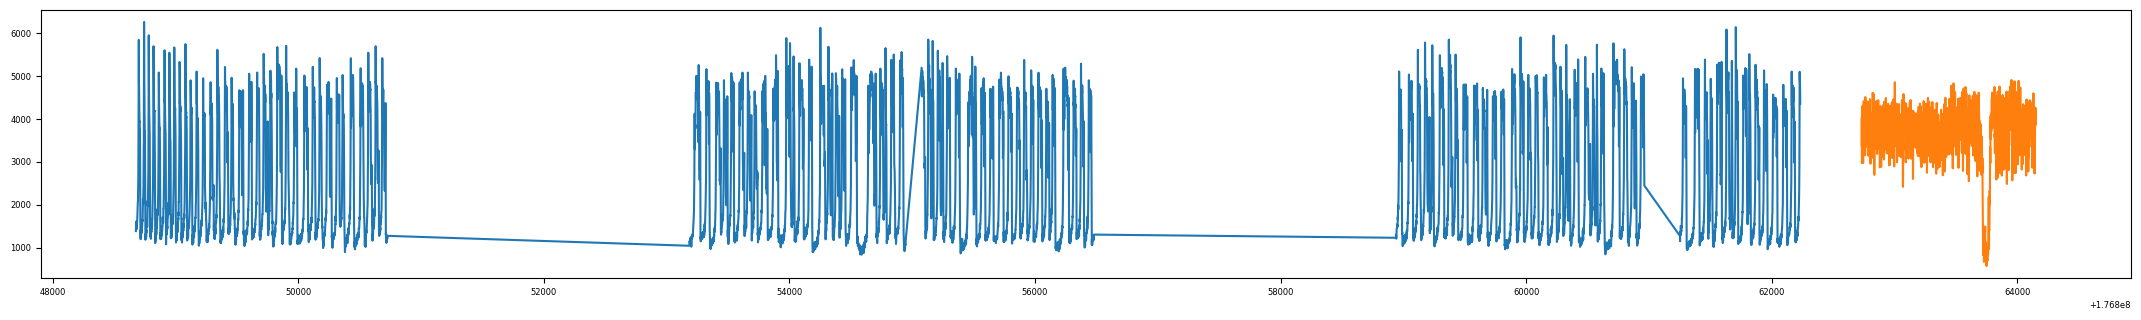

40703-01-25-00


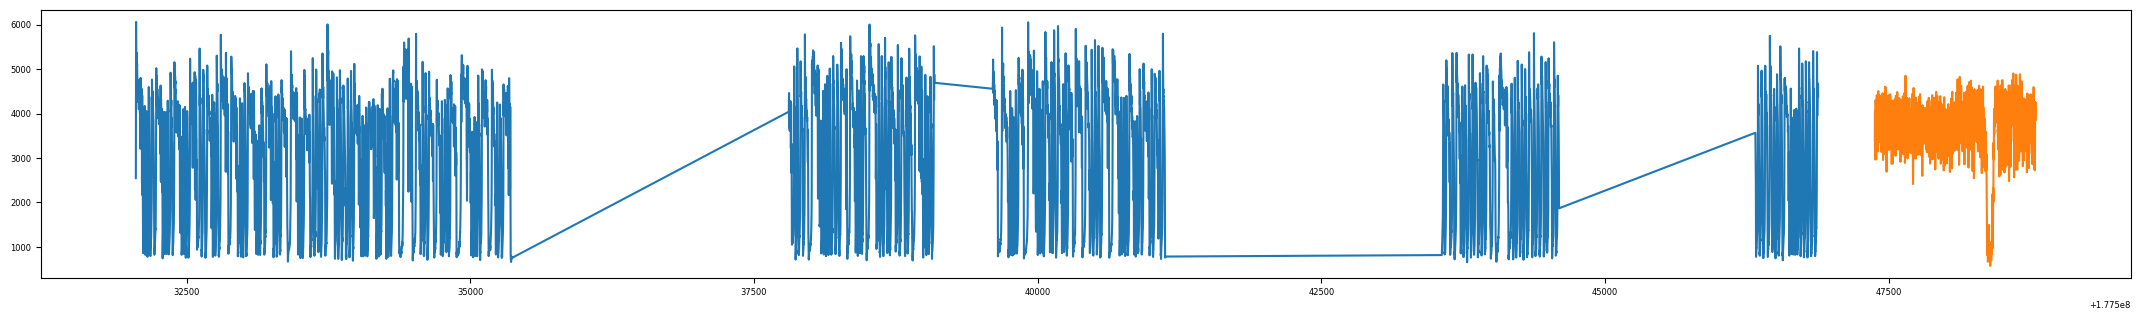

40703-01-26-00


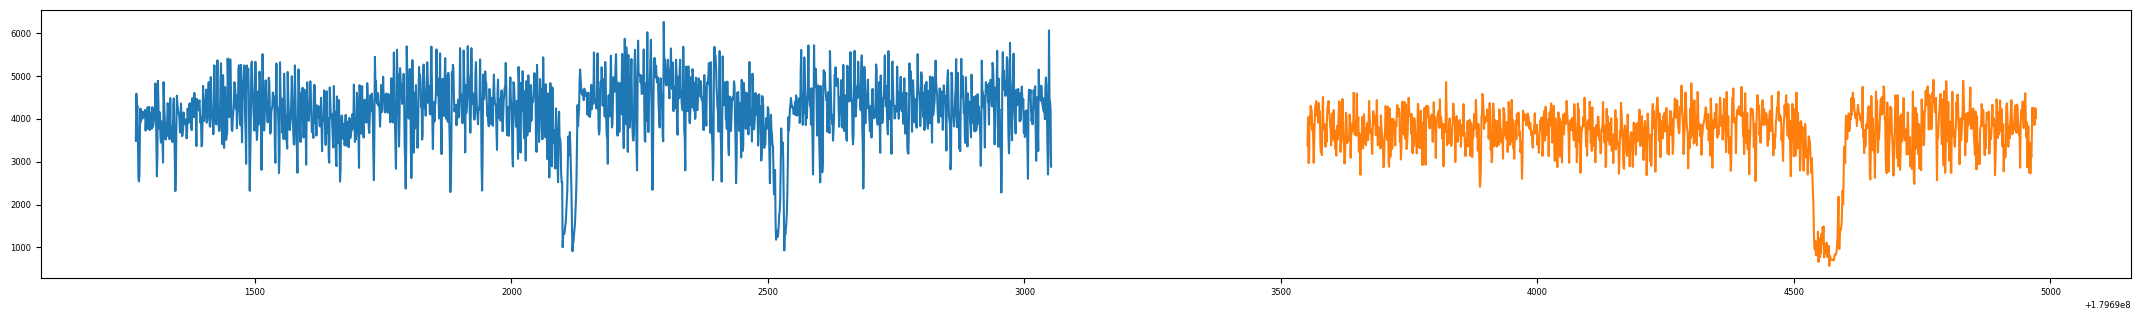

40703-01-30-00


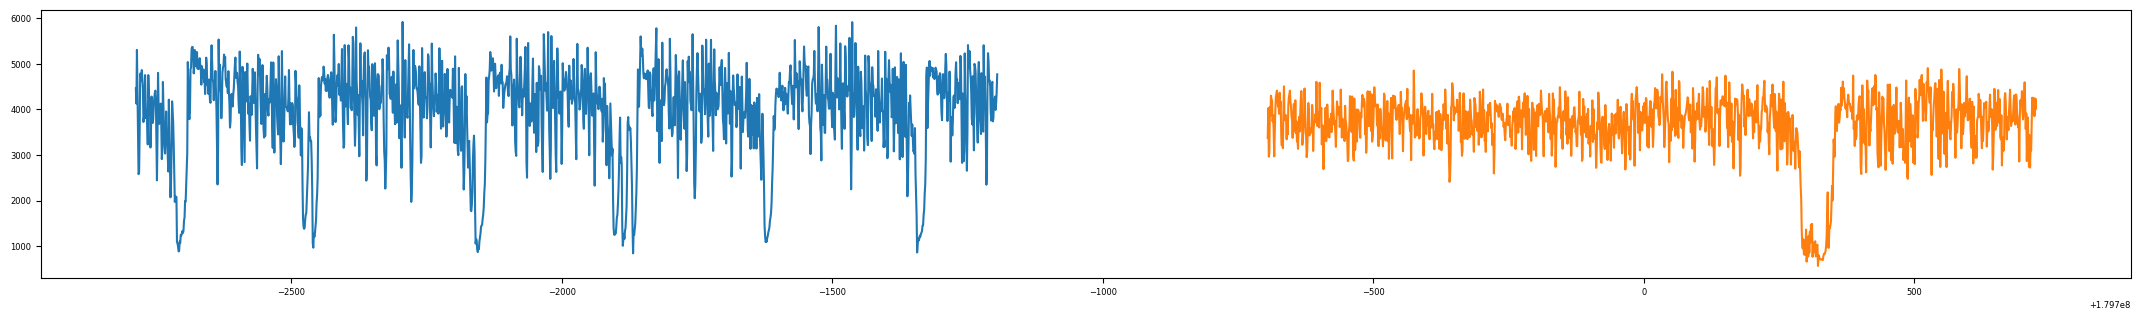

40703-01-30-01


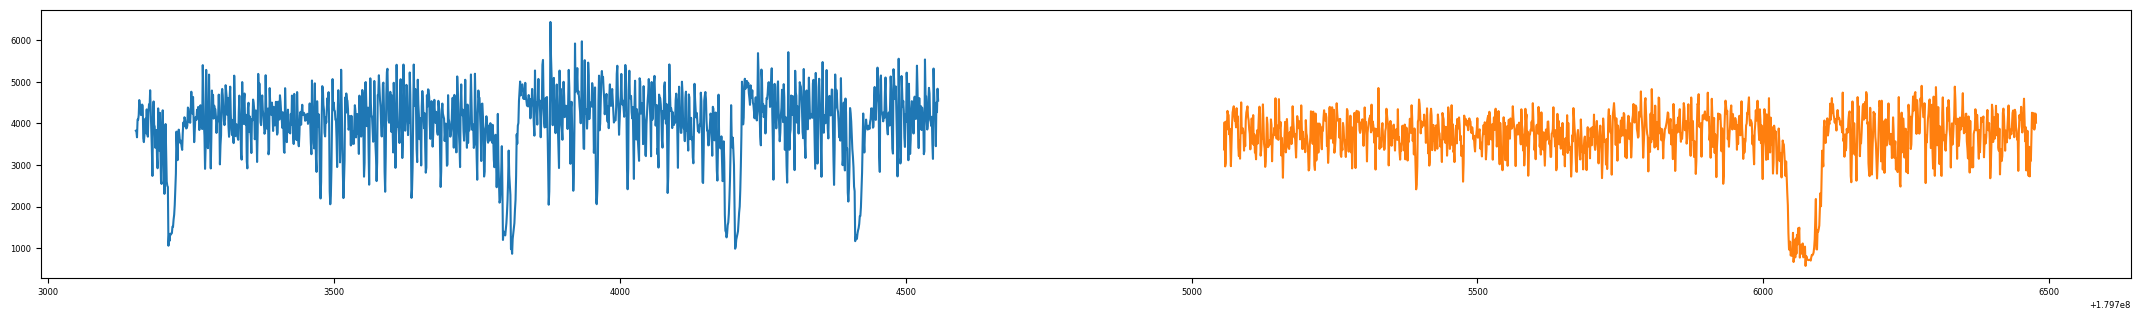

40703-01-30-02


In [401]:
predicted_class_ids = [obid for obid in inv_ob_state[misclass.iloc[misclass_lc_n,:]["Prediction"]] if obid in obs_component_counts_df_comp.index.values]
for predicted_class_id in predicted_class_ids:
    predicted_class_lc = lcs[np.where(np.array(ids) == predicted_class_id)[0][0]]
    plt.plot(predicted_class_lc[0], predicted_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(predicted_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(predicted_class_id)

In [567]:
n_estimators=1000
max_depth=10
min_samples_split=2
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.91)
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[1]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v

# change classifications according to the findings in the paper
# for new_omega in ["40703-01-14-00","40703-01-14-01","40703-01-14-02", "40703-01-30-00","40703-01-30-01","40703-01-30-02"]:
#     obs_component_counts_df_comp.loc[new_omega, "Class"] = "omega"
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]


RF_clf = RandomForestClassifier(random_state=12,#413
                                class_weight="balanced",
                                n_estimators=n_estimators,
                                max_depth=max_depth, 
                                min_samples_split=min_samples_split,
                                min_samples_leaf = min_samples_leaf
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

(0.7002331002331001, 0.7727272727272727)


In [555]:
np.unique(test_data.iloc[:,-1], return_counts=True)#test

(array(['alpha', 'beta', 'chi', 'delta', 'gamma', 'kappa', 'lambda', 'mu',
        'nu', 'omega', 'phi', 'rho', 'theta'], dtype=object),
 array([ 2,  3, 16,  5,  3,  3,  1,  2,  1,  1,  2,  4,  4]))

In [557]:
np.unique(test_data.iloc[:,-1], return_counts=True)#val

(array(['alpha', 'beta', 'chi', 'delta', 'gamma', 'kappa', 'lambda', 'mu',
        'nu', 'omega', 'phi', 'rho', 'theta'], dtype=object),
 array([1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2]))

In [563]:
alt_true = np.concatenate((test_data.iloc[:,-1], np.array(["chi"]*10), np.array(["rho"]*2)))
alt_preds = np.concatenate((preds, np.array(["chi"]*10), np.array(["rho"]*2)))

In [564]:
print((precision_recall_fscore_support(alt_true, alt_preds, zero_division=0, average="weighted")[2], accuracy_score(alt_true, alt_preds)))

(0.8053475935828879, 0.8529411764705882)


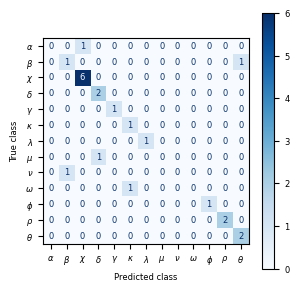

In [568]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
# plt.savefig('figures/classification_matrix_1s_94F1.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [ ]:
a,b,m,n,o

In [410]:
# [2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]
# results = []

n_estimators=50
max_depth=None
min_samples_split=10
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 2.9141414141414144)
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v

# change classifications according to the findings in the paper
for new_omega in ["40703-01-14-00","40703-01-14-01","40703-01-14-02", "40703-01-30-00","40703-01-30-01","40703-01-30-02"]:
    obs_component_counts_df_comp.loc[new_omega, "Class"] = "omega"
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

for test_iter in range(len(results)):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    n_estimators=1000,
                                    max_depth=10, 
                                    min_samples_split=2,
                                    min_samples_leaf = 1
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

KeyboardInterrupt: 

In [411]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.9268639830663113 0.008640634580027066 0.9346647932557209 0.006525028381689178


In [308]:
# old
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))
#0.9197354030483809 0.008215337526324746 0.9377129266568107 0.007602421773849735

0.9197354030483809 0.008215337526324746 0.9377129266568107 0.007602421773849735


In [ ]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker

pylab.rcParams['figure.figsize'] = (6.97, 6.97*(21.0/29.7) ) # A4 size 210mm x 297mm

ids_ar = np.array(ids)

class_names = list(inv_ob_state.keys())

fig, axes = plt.subplots(nrows=3, ncols=2)
axes = axes.flatten()

plt.subplots_adjust(hspace=0.05)
plt.subplots_adjust(wspace=0.01)


for plot_ind in range(6):
    light_c = np.copy(selected_lcs[plot_ind])
    light_c[1] /=1000
    class_name = class_names[plot_ind]
    offset = light_c[0][0]
    axes[plot_ind].set_ylim([0, 12.5])
    
    if class_name == "alpha":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1
        axes[plot_ind].plot(light_c[0][:breaks[0]]-offset, light_c[1][:breaks[0]], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].set_xlim([0, 3500])
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)

    elif class_name == "beta":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[0]
        end =breaks[1]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "gamma":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[0]
        end =breaks[1]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "theta":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[1]
        end =breaks[2]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "kappa":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[-1]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "lambda":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start=breaks[-1]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "nu":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[0]
        end =breaks[1]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "chi":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[0]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "eta":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[2]
        end =breaks[3]
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name == "omega":
        breaks = np.where((light_c[0][1:]-light_c[0][:-1]) != 1.)[0]+1 # [ 279 3584 6652]
        start= breaks[0]
        end =-1
        offset = light_c[0][start]
        axes[plot_ind].plot(light_c[0][start:end]-offset, light_c[1][start:end], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
        
    elif class_name in good_classes:
        axes[plot_ind].plot(light_c[0]-offset, light_c[1], c="blue", linewidth=0.5, zorder=-5)
        axes[plot_ind].text(0.99,0.95,r"$\{}$".format(class_name), ha='right', va='top', transform=axes[plot_ind].transAxes, size=10)
        axes[plot_ind].set_xlim([0, 3500])
    else:
        axes[plot_ind].plot(light_c[0]-offset, light_c[1])
        axes[plot_ind].plot(light_c[0][:3500]-offset, light_c[1][:3500])
    
    axes[plot_ind].set_xlim([0, 3500])
#     axes[plot_ind].tick_params(axis="x", which="major", length=5, width=1, labelsize=20, direction="in")
    
    if plot_ind%2 == 0:
        axes[plot_ind].tick_params(axis="y", which="major", length=2, width=1, labelsize=6, direction="in")
    else:
        axes[plot_ind].tick_params(axis="y", which="major", length=2, width=1, labelsize=0, direction="in")
        plt.setp(axes[plot_ind].get_yticklabels(), visible=False)
    if plot_ind == 6:
        axes[plot_ind].set_ylabel("Rate (kcounts/s)", size=6)
    if plot_ind == 12 or plot_ind == 13:
        axes[plot_ind].tick_params(axis="x", which="major", length=2, width=1, labelsize=6, direction="in")

    else:
        axes[plot_ind].tick_params(axis="x", which="major", length=2, width=1, labelsize=0, direction="in")
        plt.setp(axes[plot_ind].get_xticklabels(), visible=False)
    if plot_ind == 12:
        axes[plot_ind].set_xlabel("Time (s)", size=6, x=1)
    
#     axes[plot_ind].set_yticks([25, 50, 75, 100])
    axes[plot_ind].set_xticks([0,500, 1000,1500, 2000,2500, 3000])
    axes[plot_ind].set_yticks([0,2.5,5,7.5,10])
    axes[plot_ind].set_xticklabels([0,"", 1000,"", 2000,"", 3000])
    axes[plot_ind].set_yticklabels([0,"",5,"",10])
axes.reshape((7,2))


# axes[0][0].tick_params(axis="x", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[0][1].tick_params(axis="x", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[1][0].tick_params(axis="x", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[1][1].tick_params(axis="x", which="major", length=5, width=1, labelsize=25, direction="in")

# axes[0][0].tick_params(axis="y", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[1][0].tick_params(axis="y", which="major", length=5, width=1, labelsize=25, direction="in")
# axes[0][1].tick_params(axis="y", which="major", length=5, width=1, labelsize=5, direction="in")
# axes[1][1].tick_params(axis="y", which="major", length=5, width=1, labelsize=5, direction="in")

# plt.setp(axes[0][1].get_yticklabels(), visible=False)
# plt.setp(axes[1][1].get_yticklabels(), visible=False)
# plt.setp(axes[0][1].get_xticklabels(), visible=False)
# plt.setp(axes[0][0].get_xticklabels(), visible=False)

# axes[1][0].set_xticks([500,1000,1500,2000])
# axes[1][1].set_xticks([500,1000,1500,2000])


# axes[0][0].yaxis.set_label_coords(-0.2, 0)
# axes[1][0].xaxis.set_label_coords(1, -0.1)

# plt.suptitle("14 classes of activity of x-ray black hole binary GRS1915+105", fontsize=40, y=0.92)
# plt.rcParams.update({'font.size': 6})


# plt.savefig('all_classes_of_GRS1915.png', dpi=300)
plt.savefig('figures/light_curves.png', dpi=300, bbox_inches = 'tight',pad_inches = 0.01)

plt.show()

In [516]:
def new_grid_search_classification(data_labels, data, train_set_ids, val_set_ids, seg_ObIDs):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
    
#     comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    # change classifications according to the findings in the paper
#     for new_omega in ["40703-01-14-00","40703-01-14-01","40703-01-14-02", "40703-01-30-00","40703-01-30-01","40703-01-30-02"]:
#         obs_component_counts_df_comp.loc[new_omega, "Class"] = "omega"
    obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

    
    # training data
    train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
    # validation data
    val_data = obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"]
            
    #random forest hyperparameters
#     n_estimators_list = [50, 100, 300, 500] # 100
    max_depth_list = [None, 5, 10, 15, 25] # None
#     min_samples_split_list = [2, 5, 10, 15] # 2
#     min_samples_leaf_list = [1, 2, 5, 10] # 1   
    criterion_list= ["entropy", 'gini']

    reports = []
    
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for random_state in range(100):
                RF_clf = RandomForestClassifier(random_state=random_state,
                                                criterion=criterion,
                                                class_weight="balanced",
                                                n_estimators=100,
                                                max_depth=max_depth, 
                                                min_samples_split= 2,
                                                min_samples_leaf = 1
                                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
                preds = RF_clf.predict(val_data.iloc[:,:-1])

                reports.append((precision_recall_fscore_support(val_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                                accuracy_score(val_data.iloc[:,-1], preds),
                               (criterion,max_depth, random_state)))
    return reports



In [517]:
no_components_premerger = np.unique(GMmodel_1s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = new_grid_search_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_1s_100rng_criterion_depth_fixed_mergers_reclassified_mu.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

60 5.0


In [518]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [519]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[3.5858585858585856,
 (0.713088245088245, 0.7813636363636361, ('entropy', 5, 0))]

In [ ]:
[2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]

In [520]:
n_estimators=1000
max_depth=10
min_samples_split=2
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.5858585858585856)
data = shape_moments
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v

# change classifications according to the findings in the paper
# for new_omega in ["40703-01-14-00","40703-01-14-01","40703-01-14-02", "40703-01-30-00","40703-01-30-01","40703-01-30-02"]:
#     obs_component_counts_df_comp.loc[new_omega, "Class"] = "omega"
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]


RF_clf = RandomForestClassifier(random_state=0,#413
                                criterion="entropy"
                                class_weight="balanced",
                                n_estimators=1000,
                                max_depth=5, 
                                min_samples_split=min_samples_split,
                                min_samples_leaf = min_samples_leaf
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

SyntaxError: invalid syntax (<ipython-input-520-8d676b080ce3>, line 59)

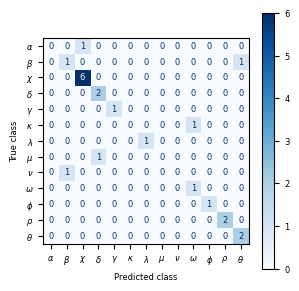

In [426]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
# plt.savefig('figures/classification_matrix_1s_94F1.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [573]:
np.array(['40703-01-13-01', '40703-01-27-00', '40703-01-29-01',
       '20402-01-33-00', '20402-01-35-00', '40703-01-12-00',
       '40703-01-14-00', '40703-01-14-01', '40703-01-14-02',
       '40703-01-24-00', '40703-01-25-00', '40703-01-26-00',
       '40703-01-30-00', '40703-01-30-01', '40703-01-30-02'], dtype=str)

array(['40703-01-13-01', '40703-01-27-00', '40703-01-29-01',
       '20402-01-33-00', '20402-01-35-00', '40703-01-12-00',
       '40703-01-14-00', '40703-01-14-01', '40703-01-14-02',
       '40703-01-24-00', '40703-01-25-00', '40703-01-26-00',
       '40703-01-30-00', '40703-01-30-01', '40703-01-30-02'], dtype='<U14')

In [571]:
heatmap_data.index.values

array(['40703-01-13-01', '40703-01-27-00', '40703-01-29-01',
       '20402-01-33-00', '20402-01-35-00', '40703-01-12-00',
       '40703-01-14-00', '40703-01-14-01', '40703-01-14-02',
       '40703-01-24-00', '40703-01-25-00', '40703-01-26-00',
       '40703-01-30-00', '40703-01-30-01', '40703-01-30-02'], dtype=object)

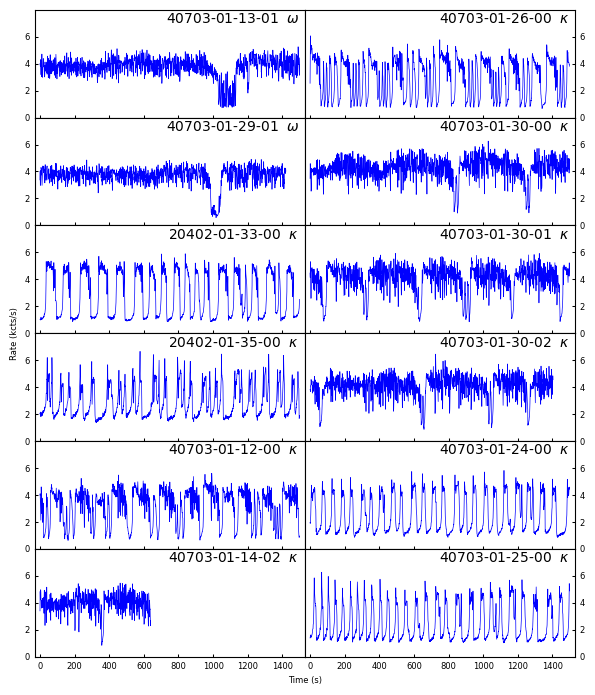

In [779]:
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
#https://stackoverflow.com/questions/8389636/creating-over-20-unique-legend-colors-using-matplotlib


# pylab.rcParams['figure.figsize'] = (3.15, 8.4) # A4 size 210mm x 297mm
plt.rcParams['figure.figsize'] = (6.97, 8.4)
plt.rcParams.update({'font.size': 6})


fig, axes = plt.subplots(nrows=6, ncols=2)
# axes = axes.flatten()

plt.subplots_adjust(hspace=0)#0.05
plt.subplots_adjust(wspace=0)#0.01

#'40703-01-14-00', '40703-01-14-01','40703-01-27-00',
# ids of 3 omega and 12 kappa observations
omega_kappa_ids = np.array(['40703-01-13-01',  '40703-01-29-01',
       '20402-01-33-00', '20402-01-35-00', '40703-01-12-00',
        '40703-01-14-02',
       '40703-01-24-00', '40703-01-25-00', '40703-01-26-00',
       '40703-01-30-00', '40703-01-30-01', '40703-01-30-02'], dtype=str)

for plot_ind, omega_kappa_id in enumerate(omega_kappa_ids):
    light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
    if plot_ind>5:
        col_ind = 1
        row_ind = plot_ind-8
        axes[row_ind, col_ind].yaxis.tick_right()
    else:
        col_ind = 0
        row_ind = plot_ind
    axes[row_ind, col_ind].plot(light_c[0][:1500]-light_c[0][0], light_c[1][:1500]/1000, c="blue", linewidth=0.5, zorder=1)

#     
    axes[row_ind, col_ind].set_ylim([0, 8])
    axes[row_ind, col_ind].set_xlim([-30, 1530])
#     axes[plot_ind, 1].set_xlim([0, 512])

    axes[row_ind, col_ind].text(0.98,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=axes[row_ind, col_ind].transAxes, size=10)
        
    axes[row_ind, col_ind].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
    axes[row_ind, col_ind].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

    axes[row_ind, col_ind].set_yticks([0, 2,4,6])
    axes[row_ind, col_ind].set_yticklabels([0, 2, 4, 6])

#     axes[plot_ind].tick_params(axis="y", which="minor", length=2, width=0.75, labelsize=8, direction="in")


#     if plot_ind%2 == 0:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=8, direction="in")
#     else:
#         axes[plot_ind].tick_params(axis="y", which="major", length=5, width=1, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind].get_yticklabels(), visible=False)

#     if plot_ind == 6:
#         axes[plot_ind, 0].set_ylabel("Rate (kcts/s)", size=6)
#     if plot_ind == 13:#plot_ind == 12 or plot_ind == 13:
#         axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#         axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#         axes[plot_ind, 0].set_xlabel("Time (s)", size=6, x=1)

#     else:
#         axes[plot_ind, 0].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind, 0].get_xticklabels(), visible=False)
#         axes[plot_ind, 1].tick_params(axis="x", which="major", length=2, width=0.75, labelsize=0, direction="in")
#         plt.setp(axes[plot_ind, 1].get_xticklabels(), visible=False)
    

#     axes[plot_ind, 0].set_yticks([0, 2500, 5000, 7500, 10000, 12500])
#     axes[plot_ind, 0].set_yticklabels([0, "", 5, "", 10, "",])
#     axes[plot_ind, 0].set_xticks([0, 100, 200,300, 400, 500])
#     axes[plot_ind, 0].set_xticklabels([0, "", 200,"", 400, ""])
#     axes[plot_ind, 1].set_xticks([0, 100, 200,300, 400, 500])
#     axes[plot_ind, 1].set_xticklabels([0, "", 200,"", 400, ""])
    
axes[2, 0].set_ylabel("Rate (kcts/s)", size=6, y=0)
axes[5, 1].set_xlabel("Time (s)", size=6,x=0)
# axes[5, 0].set_xlabel("Time (s)", size=6)

# axes[7, 1].set_yticks([])
# axes[7, 1].set_xticks([])

# axes[1, 0].set_xlim([-1500, -1])

plt.savefig('figures/omega_kappa_lightcurves.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)
# plt.legend()
plt.show()

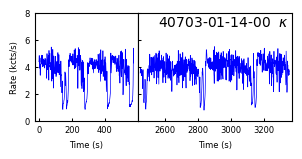

In [804]:
plt.rcParams['figure.figsize'] = (3.32, 8.4/6)
plt.rcParams.update({'font.size': 6})


# fig, axes = plt.subplots(nrows=1, ncols=20)
# axes = axes.flatten()
fig = plt.figure()

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)

lc_ind = 1
break_point = break_point_list[lc_ind]+1
omega_kappa_id = omega_kappa_ids[lc_ind]

ax1 = plt.subplot2grid((1, 20), (0, 0), rowspan=1, colspan=8)#, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax2 = plt.subplot2grid((1, 20), (0, 8), rowspan=1, colspan=12, yticks=[])#, xticklabels=[], yticklabels=[], xticks=[])


light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
ax1.plot(light_c[0][:break_point]-light_c[0][0], light_c[1][:break_point]/1000, c="blue", linewidth=0.5, zorder=1)
ax2.plot(light_c[0][break_point:]-light_c[0][0], light_c[1][break_point:]/1000, c="blue", linewidth=0.5, zorder=1)


ax1.set_ylim([0, 8])
ax2.set_ylim([0, 8])
ax1.set_xlim([-25, 574+25])
ax2.set_xlim([2448-15, 2448+906+15])

ax2.text(0.98,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=ax2.transAxes, size=10)
ax1.set_ylabel("Rate (kcts/s)", size=6)
ax1.set_xlabel("Time (s)", size=6)
ax2.set_xlabel("Time (s)", size=6)

ax1.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax1.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

ax1.set_yticks([0, 2,4,6,8])
ax2.set_yticks([0, 2,4,6,8])
ax1.set_yticklabels([0, 2, 4, 6,8])
ax2.set_yticklabels(["", "", "", "",""])

plt.rcParams['figure.figsize'] = (3.32, 8.4/6)
plt.savefig('figures/40703-01-14-00_lightcurve.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)


plt.show()

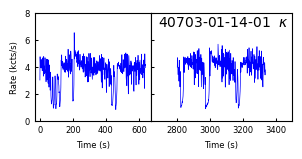

In [805]:
plt.rcParams['figure.figsize'] = (3.32, 8.4/6)
plt.rcParams.update({'font.size': 6})


# fig, axes = plt.subplots(nrows=1, ncols=20)
# axes = axes.flatten()
fig = plt.figure()

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)

lc_ind = 2
break_point = break_point_list[lc_ind]+1
omega_kappa_id = omega_kappa_ids[lc_ind]

ax1 = plt.subplot2grid((1, 20), (0, 0), rowspan=1, colspan=9)#, xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ax2 = plt.subplot2grid((1, 20), (0, 9), rowspan=1, colspan=11, yticks=[])#, xticklabels=[], yticklabels=[], xticks=[])


light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
ax1.plot(light_c[0][:break_point]-light_c[0][0], light_c[1][:break_point]/1000, c="blue", linewidth=0.5, zorder=1)
ax2.plot(light_c[0][break_point:]-light_c[0][0], light_c[1][break_point:]/1000, c="blue", linewidth=0.5, zorder=1)


ax1.set_ylim([0, 8])
ax2.set_ylim([0, 8])
ax1.set_xlim([-31, 639+32])
ax2.set_xlim([2801-162, 2801+534+162])

ax2.text(0.98,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=ax2.transAxes, size=10)
ax1.set_ylabel("Rate (kcts/s)", size=6)
ax1.set_xlabel("Time (s)", size=6)
ax2.set_xlabel("Time (s)", size=6)

ax1.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax1.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
ax2.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")
#     axes[plot_ind, 1].tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")

ax1.set_yticks([0, 2,4,6,8])
ax2.set_yticks([0, 2,4,6,8])
ax1.set_yticklabels([0, 2, 4, 6,8])
ax2.set_yticklabels(["", "", "", "",""])

plt.rcParams['figure.figsize'] = (3.32, 8.4/6)
plt.savefig('figures/40703-01-14-01_lightcurve.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)


plt.show()

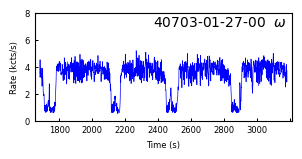

In [802]:

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)
lc_ind = 0
break_point = break_point_list[lc_ind]+1
omega_kappa_id = omega_kappa_ids[lc_ind]
light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]


fig, axes = plt.subplots(nrows=1, ncols=1)
axes.plot(light_c[0][break_point:break_point+1500]-light_c[0][0], light_c[1][break_point:break_point+1500]/1000, c="blue", linewidth=0.5, zorder=1)
axes.set_ylim([0, 8])
axes.set_xlim([-30+1681.125, 1530+1681.125])
axes.set_ylabel("Rate (kcts/s)", size=6)
axes.set_xlabel("Time (s)", size=6)
axes.text(0.98,0.98,"{}\t".format(omega_kappa_id)+ r"$\{}$".format(ob_state[omega_kappa_id]), ha='right', va='top', transform=axes.transAxes, size=10)
plt.rcParams['figure.figsize'] = (3.32, 8.4/6)

axes.tick_params(axis="y", which="major", length=2, width=0.75, labelsize=6, direction="in")
axes.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="in")

axes.set_yticks([0, 2,4,6,8])
axes.set_yticklabels([0, 2, 4, 6,8])
axes.set_xticks([1800,2000,2200,2400,2600,2800,3000,3200])
axes.set_xticklabels([1800,2000,2200,2400,2600,2800,3000,""])

plt.savefig('figures/40703-01-27-00_lightcurve.png', dpi=300,pad_inches = 0, bbox_inches = 'tight')#)

plt.show()

In [706]:
light_c[0][break_point:break_point+1500]-light_c[0][0]#.shape

array([1681.125, 1682.125, 1683.125, ..., 3178.125, 3179.125, 3180.125])

In [696]:
(light_c[0]-light_c[0][0])[250:300]

array([ 250.   ,  251.   ,  252.   ,  253.   ,  254.   ,  255.   ,
       1681.125, 1682.125, 1683.125, 1684.125, 1685.125, 1686.125,
       1687.125, 1688.125, 1689.125, 1690.125, 1691.125, 1692.125,
       1693.125, 1694.125, 1695.125, 1696.125, 1697.125, 1698.125,
       1699.125, 1700.125, 1701.125, 1702.125, 1703.125, 1704.125,
       1705.125, 1706.125, 1707.125, 1708.125, 1709.125, 1710.125,
       1711.125, 1712.125, 1713.125, 1714.125, 1715.125, 1716.125,
       1717.125, 1718.125, 1719.125, 1720.125, 1721.125, 1722.125,
       1723.125, 1724.125])

In [681]:
light_c[0][break_point+1]

178051636.94093037

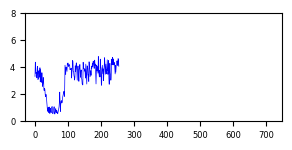

In [670]:
plt.rcParams['figure.figsize'] = (3.32, 8.4/6)
plt.rcParams.update({'font.size': 6})


fig, axes = plt.subplots(nrows=1, ncols=1)
# axes = axes.flatten()

plt.subplots_adjust(hspace=0)
plt.subplots_adjust(wspace=0)

break_point_list = [255,574,639]
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)

lc_ind = 0
break_point = break_point_list[lc_ind]
omega_kappa_id = omega_kappa_ids[lc_ind]

light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
axes.plot(light_c[0][:break_point]-light_c[0][0], light_c[1][:break_point]/1000, c="blue", linewidth=0.5, zorder=1)

axes.set_ylim([0, 8])
axes.set_xlim([-30, 750])
plt.show()

In [669]:
light_c

array([[1.78049956e+08, 1.78049957e+08, 1.78049958e+08, ...,
        1.78053242e+08, 1.78053243e+08, 1.78053244e+08],
       [3.33000000e+03, 4.38800000e+03, 4.07800000e+03, ...,
        6.45000000e+02, 7.02000000e+02, 6.75000000e+02],
       [5.77061522e+01, 6.62419806e+01, 6.38592202e+01, ...,
        2.53968502e+01, 2.64952826e+01, 2.59807621e+01]])

In [644]:
axes

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [640]:
omega_kappa_ids = np.array(['40703-01-27-00', '40703-01-14-00', '40703-01-14-01'], dtype=str)
#[255,574,639]
np.where((lcs[np.where(np.array(ids) == omega_kappa_ids[2])[0][0]][0][1:]-lcs[np.where(np.array(ids) == omega_kappa_ids[2])[0][0]][0][:-1])>1)

(array([639]),)

In [658]:
for plot_ind, omega_kappa_id in enumerate(omega_kappa_ids):
    light_c = lcs[np.where(np.array(ids) == omega_kappa_id)[0][0]]
    print(len(light_c[0]))

1864
1481
1174


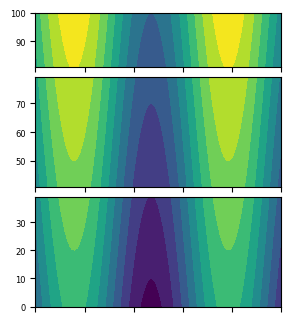

In [601]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure()
gs = gridspec.GridSpec(2, 2)

X, Y = np.meshgrid(np.linspace(0,100, num=101), np.linspace(0,100, num=101))
f = lambda x, y: np.sin(x/10.)+y/100.


axMain = plt.subplot(gs[0])
plt.sca(axMain)
cf = axMain.contourf(X[0:40,:], Y[0:40,:], f(X,Y)[0:40,:] , vmin=-1, vmax=2)

divider = make_axes_locatable(axMain)
axShallow = divider.append_axes("top", size="100%", pad=0.1, sharex=axMain)
axShallow.contourf(X[41:80,:], Y[41:80,:], f(X,Y)[41:80,:], vmin=-1, vmax=2)
axShallow.set_xticklabels([])
axShallow2 = divider.append_axes("top", size="50%", pad=0.1, sharex=axMain)
axShallow2.contourf(X[81:,:], Y[81:,:], f(X,Y)[81:,:], vmin=-1, vmax=2)
axShallow2.set_xticklabels([])

plt.show()

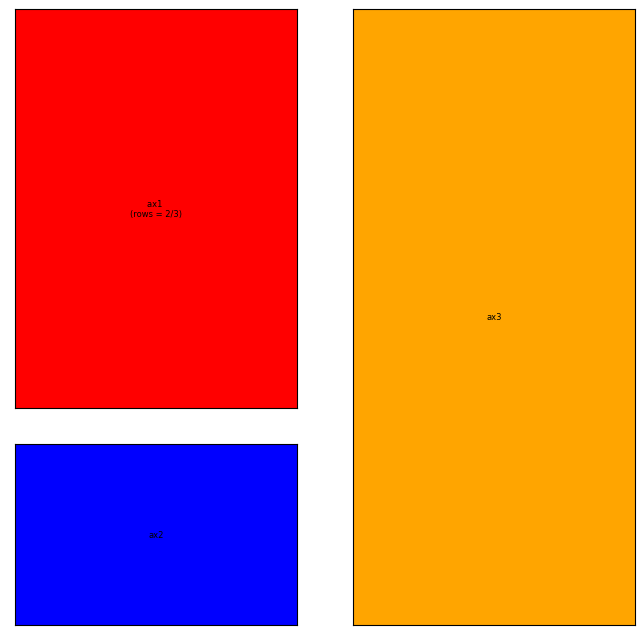

In [602]:
fig = plt.figure(figsize=(8,8))
ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=2, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], fc="red",)
ax2 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], fc="blue",)
ax3 = plt.subplot2grid((3, 2), (0, 1), rowspan=3, colspan=1, xticklabels=[], yticklabels=[], xticks=[], yticks=[], fc="orange",)
ax1.text(0.5, 0.5, "ax1 \n(rows = 2/3)", horizontalalignment='center', verticalalignment='center')
ax2.text(0.5, 0.5, "ax2", horizontalalignment='center', verticalalignment='center')
ax3.text(0.5, 0.5, "ax3", horizontalalignment='center', verticalalignment='center')
plt.show()

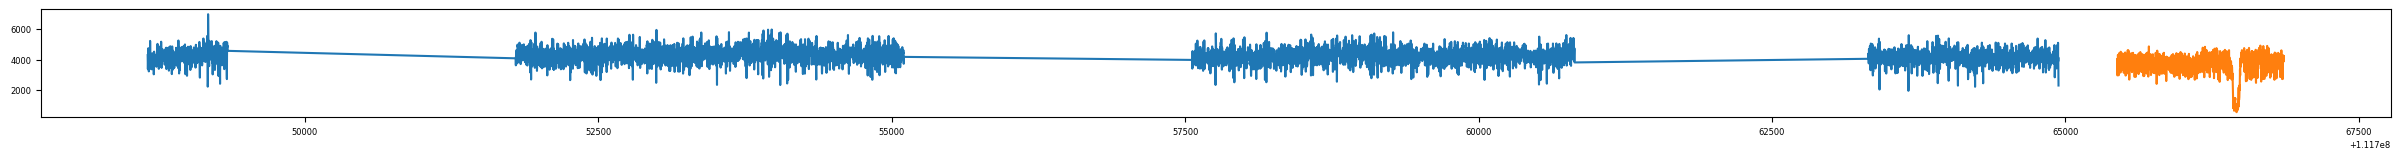

20402-01-37-00


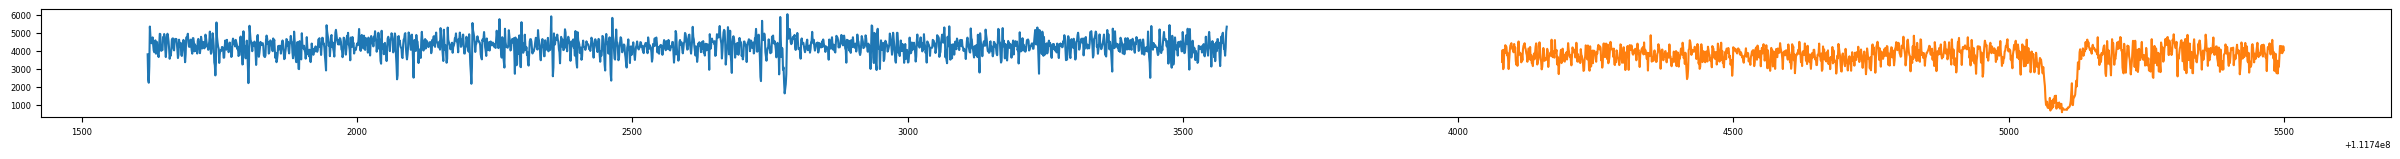

20402-01-37-02


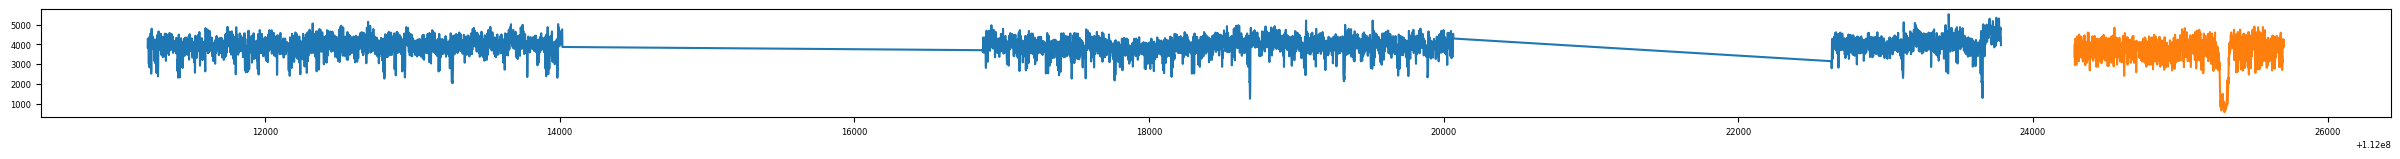

20402-01-38-00


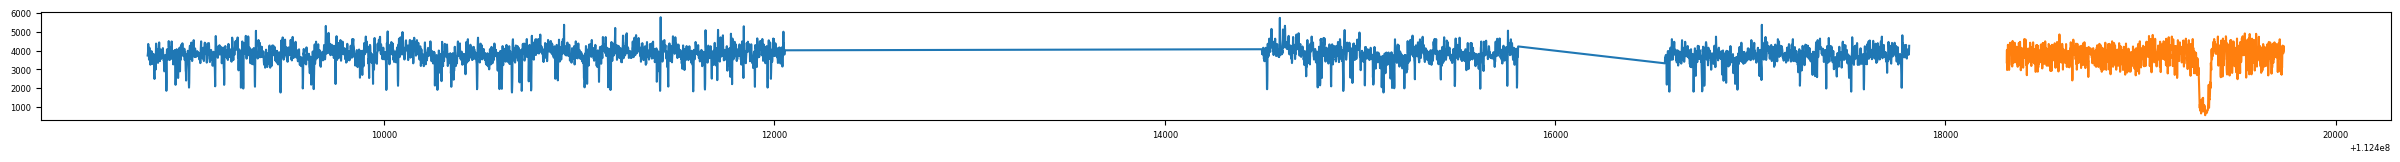

20402-01-39-00


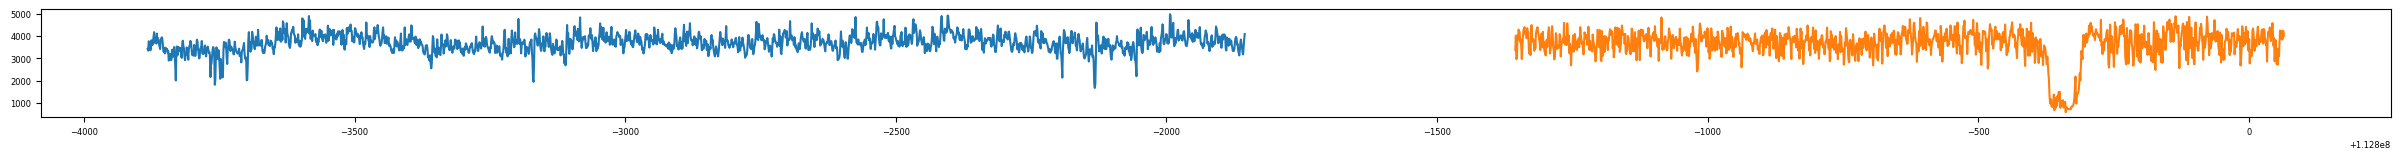

20402-01-39-02


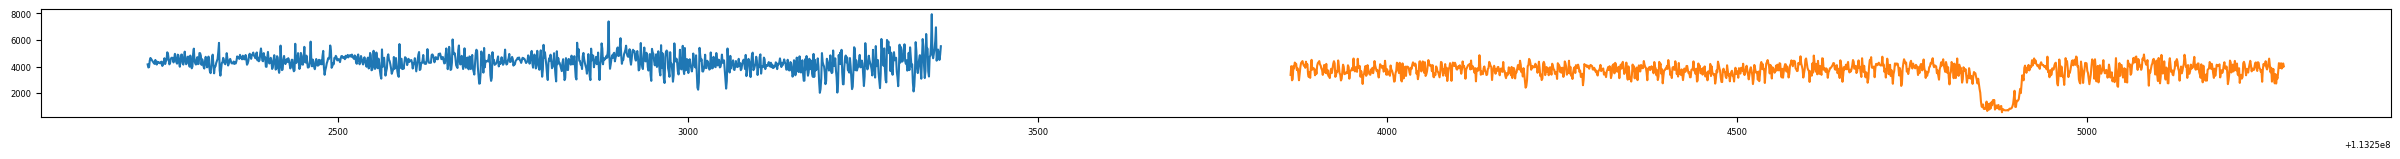

20402-01-40-00


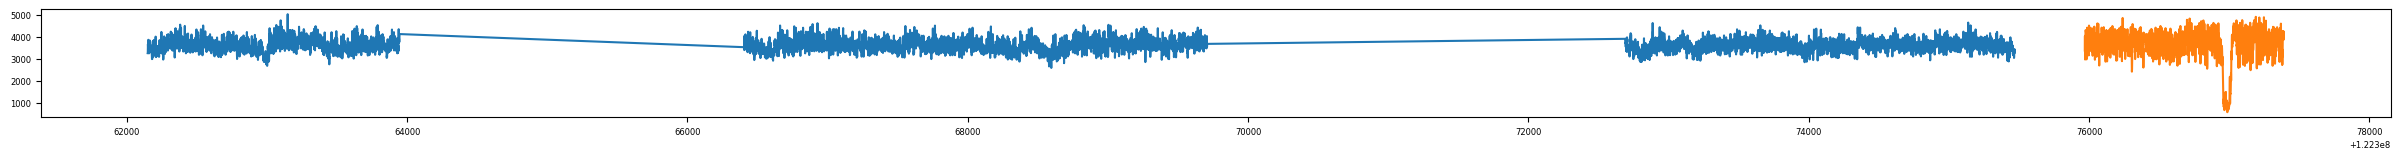

20402-01-55-00


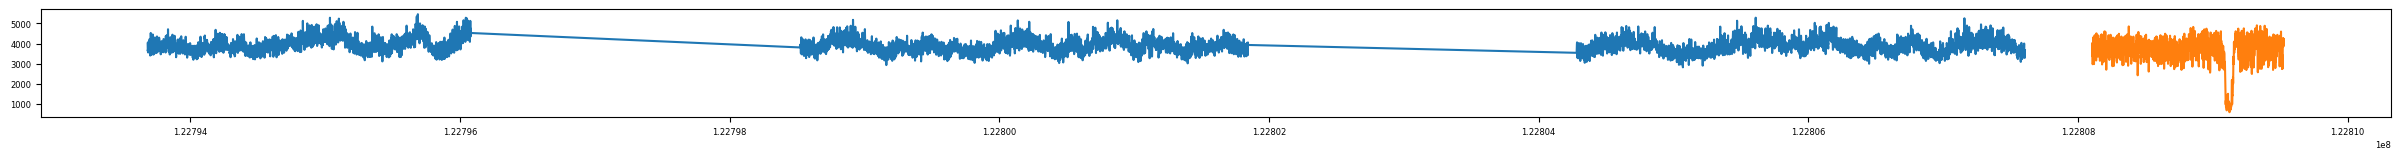

20402-01-56-00


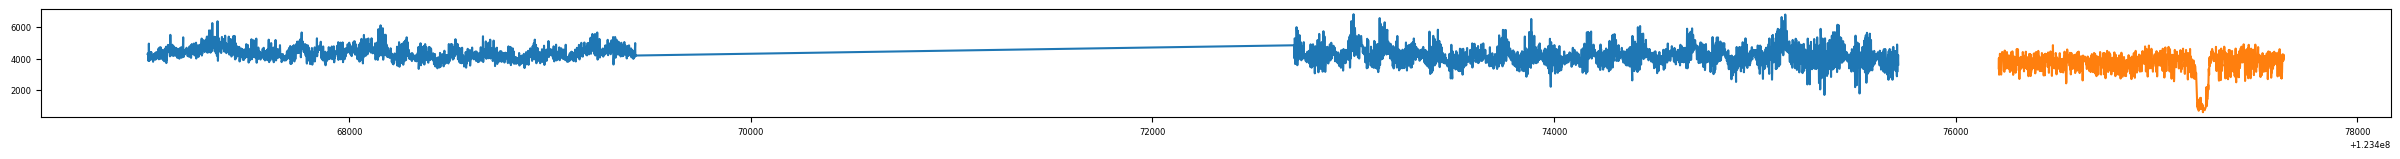

20402-01-57-00


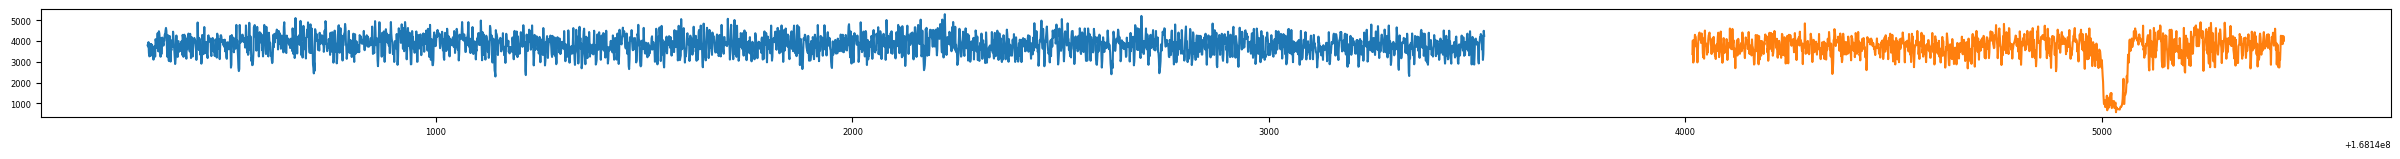

40703-01-13-00


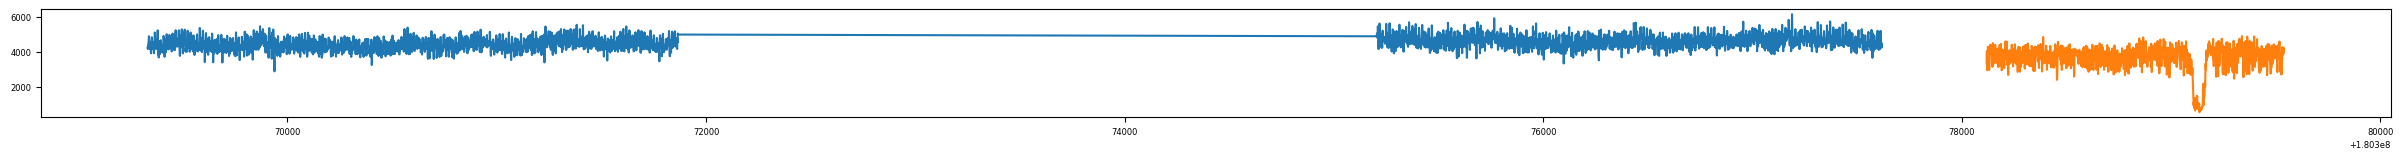

40115-01-07-00


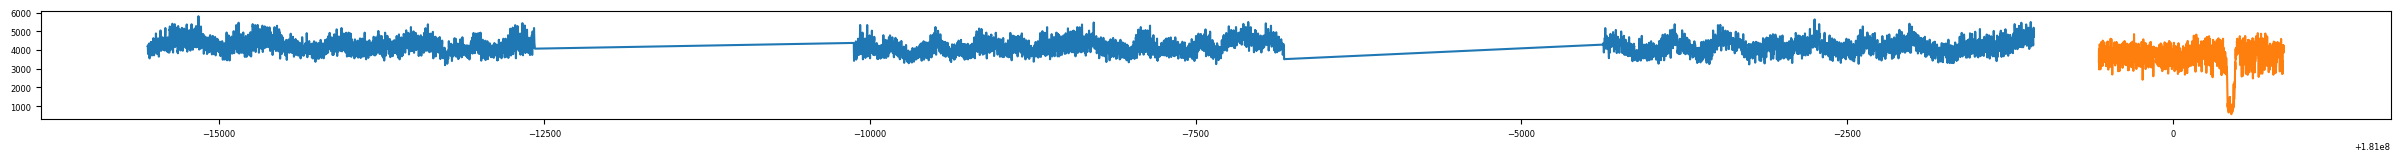

40703-01-31-00


In [812]:
plt.rcParams['figure.figsize'] = (30.32, 8.4/6)

predicted_class_ids = [obid for obid in inv_ob_state["gamma"] if obid in obs_component_counts_df_comp.index.values]
for predicted_class_id in predicted_class_ids:
    predicted_class_lc = lcs[np.where(np.array(ids) == predicted_class_id)[0][0]]
    plt.plot(predicted_class_lc[0], predicted_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(predicted_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(predicted_class_id)

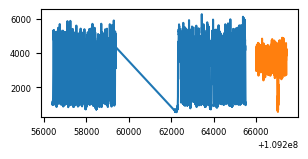

20402-01-33-00


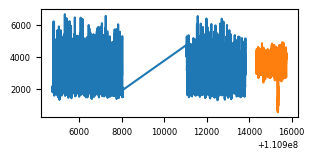

20402-01-35-00


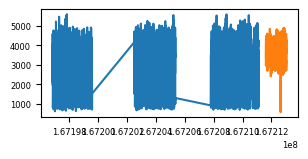

40703-01-12-00


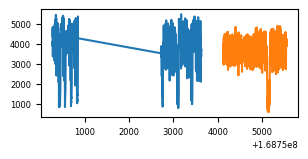

40703-01-14-00


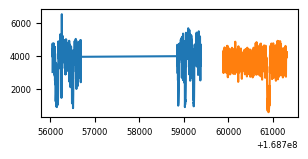

40703-01-14-01


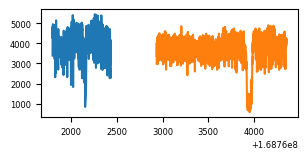

40703-01-14-02


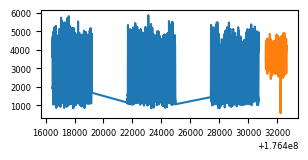

40703-01-24-00


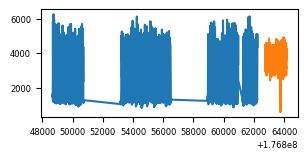

40703-01-25-00


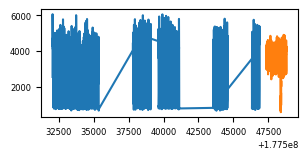

40703-01-26-00


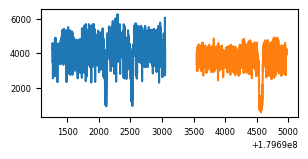

40703-01-30-00


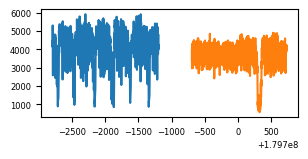

40703-01-30-01


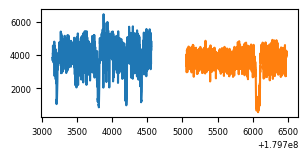

40703-01-30-02


In [810]:
predicted_class_ids = [obid for obid in inv_ob_state[misclass.iloc[misclass_lc_n,:]["Prediction"]] if obid in obs_component_counts_df_comp.index.values]
for predicted_class_id in predicted_class_ids:
    predicted_class_lc = lcs[np.where(np.array(ids) == predicted_class_id)[0][0]]
    plt.plot(predicted_class_lc[0], predicted_class_lc[1])
    plt.plot(misclass_lc[0]-misclass_lc[0][0]+(predicted_class_lc[0][-1]+500), misclass_lc[1])
    plt.show()
    print(predicted_class_id)

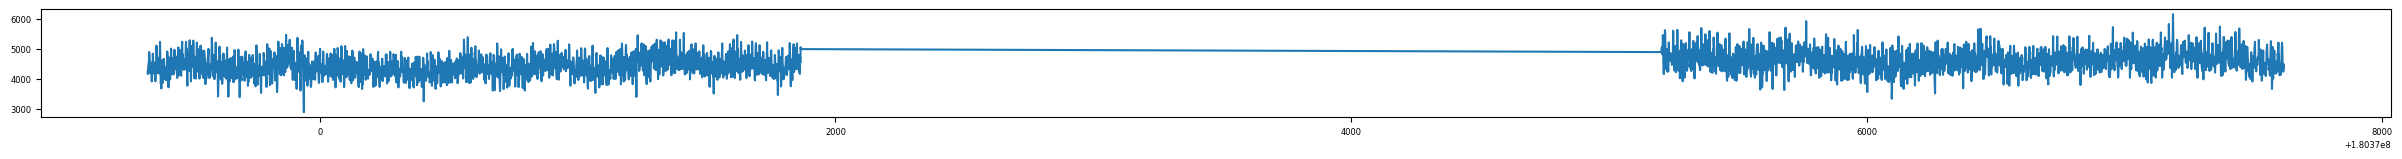

In [833]:
show_lc = lcs[np.where(np.array(ids) == "40115-01-07-00")[0][0]]
plt.plot(show_lc[0], show_lc[1])
plt.show()

In [ ]:
for chrono_id in np.take(ids, np.argsort(np.array(lcs_time))):
    if chrono_id in ob_state.keys():
        start_time = lcs[np.where(np.array(ids) == chrono_id)[0][0]][0][0]
        print(chrono_id,start_time, ob_state[chrono_id])

In [829]:
start_times = [lc[0][0] for lc in lcs]
for ordered_ind in np.argsort(start_times):
    print(ids[ordered_ind])

10408-01-01-01
10408-01-01-00
10408-01-03-00
10263-01-01-00
10408-01-03-01
10408-01-04-00
10408-01-05-00
10408-01-06-00
10408-01-07-00
10408-01-08-00
10408-01-10-00
10408-01-11-00
10408-01-12-00
10408-01-13-00
10408-01-14-00
10408-01-14-01
10408-01-14-02
10408-01-14-03
10408-01-14-04
10408-01-14-05
10408-01-14-07
10408-01-14-08
10408-01-14-09
10408-01-15-05
10408-01-15-04
10408-01-15-00
10408-01-15-01
10408-01-15-02
10408-01-15-03
10408-01-16-00
10408-01-16-01
10408-01-16-02
10408-01-16-03
10408-01-16-04
10408-01-17-00
10408-01-17-01
10408-01-17-02
10408-01-17-03
10408-01-18-00
10408-01-18-04
10408-01-18-01
10408-01-19-01
10408-01-19-02
10408-01-19-00
10408-01-20-00
10408-01-20-01
10408-01-21-00
10408-01-21-01
10408-01-21-02
10408-01-22-00
10408-01-22-01
10408-01-22-02
10408-01-23-00
10408-01-24-00
10408-01-25-00
10258-01-01-00
10408-01-27-00
10258-01-02-00
10408-01-28-00
10258-01-03-00
10408-01-29-00
10258-01-04-00
10408-01-30-00
10258-01-05-00
10408-01-31-00
10258-01-06-00
10408-01-3

In [9]:
def grid_search_classification_mu(data_labels, data, train_set_ids, val_set_ids, seg_ObIDs):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
    
#     comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

    
    # training data
    train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
    # validation data
    val_data = obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"]
            
    #random forest hyperparameters
#     n_estimators_list = [50, 100, 300, 500] # 100
    max_depth_list = [None, 5, 10, 15, 25] # None
#     min_samples_split_list = [2, 5, 10, 15] # 2
#     min_samples_leaf_list = [1, 2, 5, 10] # 1   
    criterion_list= ["entropy", 'gini']

    reports = []
    
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for random_state in range(100):
                RF_clf = RandomForestClassifier(random_state=random_state,
                                                criterion=criterion,
                                                class_weight="balanced",
                                                n_estimators=100,
                                                max_depth=max_depth, 
                                                min_samples_split= 2,
                                                min_samples_leaf = 1,
                                                n_jobs=35
                                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
                preds = RF_clf.predict(val_data.iloc[:,:-1])

                reports.append((precision_recall_fscore_support(val_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                                accuracy_score(val_data.iloc[:,-1], preds),
                               (criterion,max_depth, random_state)))
    return reports

In [ ]:
no_components_premerger = np.unique(GMmodel_1s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_1s_100rng_criterion_depth_fixed_mergers_fixed_mulambda.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

59 4.893939393939394


In [839]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [840]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result
# [2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]

[3.5858585858585856,
 (0.713088245088245, 0.7813636363636361, ('entropy', 5, 0))]

In [14]:
np.unique(merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.59)).shape #140

(140,)

In [20]:
# [2.9141414141414144, (0.7060269730269728, 0.7763636363636358, ('gini', 10, 0))]
results = []


data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.59)
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"


# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]

for test_iter in range(1000):

    RF_clf = RandomForestClassifier(random_state=test_iter,
                                    class_weight="balanced",
                                    criterion = 'entropy',
                                    n_estimators=1000,
                                    max_depth=5, 
                                    min_samples_split=2,
                                    min_samples_leaf = 1,
                                    n_jobs=35
                                   ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
    preds = RF_clf.predict(test_data.iloc[:,:-1])

    results.append((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))
    print(len(results))
    clear_output(wait=True)

1000


In [21]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.8641750742779589 0.030095514637440517 0.896127659574468 0.02533680771644878


In [866]:
# with open("results_entropy_depth5_mahal3-58_1000.pkl", 'wb') as f:
#     pickle.dump(sigma_reports_list, f)

In [868]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.91961035549688 0.006428386858158328 0.9374468085106387 0.006132189027295693


In [843]:
print(np.mean([x for x,y in results]), np.std([x for x,y in results]), np.mean([y for x,y in results]), np.std([y for x,y in results]))

0.8631028440568634 0.030472414973967174 0.894595744680851 0.025548611561859783


In [32]:
np.sum(np.array([x for x,y in results])>0.9)

132

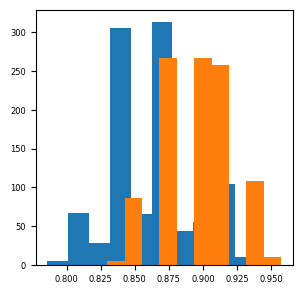

In [862]:
plt.hist([x for x,y in results])
plt.hist([y for x,y in results])

plt.show()

In [22]:
np.argmin(np.array([x for x,y in results]))

125

In [23]:
results[125]

(0.7857987166497805, 0.8297872340425532)

In [851]:
results[710]

(0.8633078505418932, 0.8936170212765957)

In [37]:
n_estimators=1000
max_depth=5
min_samples_split=2
min_samples_leaf = 1
data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.59)
train_set_ids = split_ob_ids[0]
test_set_ids = split_ob_ids[2]


# find GMM component labels for data
data_GMMcomp_labels = data_labels

# make a dict that groups indices of segments of the same observation 
# i.e. where each observation id can be found in seg_ObIDs
#i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
for ID_index, ObID in enumerate(seg_ObIDs):
    ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)

# make a dictionary of Gaussian component labels instead of segment indices  
#i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
ObID_GaussComps_dict_comp = {}
for ObID, Indices in ObID_SegIndices_dict.items():
    ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]

# make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                           index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)

# populate the data frame
for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
    for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
        obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count


obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows

# add classification column
obs_component_counts_df_comp["Class"] = "Unknown" 
for k,v in ob_state.items():
    if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
    if str(k) in obs_component_counts_df_comp.index.values:
        obs_component_counts_df_comp.loc[str(k), "Class"] = v
obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"


# training data
train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
# validation data
test_data = obs_component_counts_df_comp.loc[test_set_ids].loc[obs_component_counts_df_comp.loc[test_set_ids].iloc[:,-1] != "Unknown"]


RF_clf = RandomForestClassifier(random_state=125,
                                class_weight="balanced",
                                criterion = 'entropy',
                                n_estimators=1000,
                                max_depth=5, 
                                min_samples_split=2,
                                min_samples_leaf = 1,
                                n_jobs=35
                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
preds = RF_clf.predict(test_data.iloc[:,:-1])

print((precision_recall_fscore_support(test_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2], accuracy_score(test_data.iloc[:,-1], preds)))

(0.7857987166497805, 0.8297872340425532)


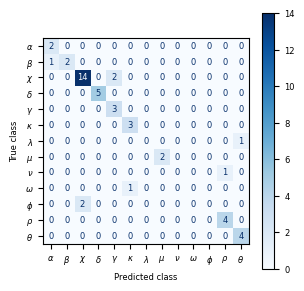

In [38]:
from sklearn.svm import SVC
from  sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
#(y_true, y_pred, *, beta=1.0, labels=None, pos_label=1, average=None, warn_for=('precision', 'recall', 'f-score'), sample_weight=None, zero_division='warn')

# import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (3.32, 3.32)#(6.97, 6.97)
plt.rcParams.update({'font.size': 6})


disp = plot_confusion_matrix(RF_clf, test_data.iloc[:,:-1], test_data.iloc[:,-1],
                         cmap=plt.cm.Blues,
                         normalize=None)
#     disp.ax_.set_title("{}".format(title))
disp.ax_.set_xlabel("Predicted class")
disp.ax_.set_ylabel("True class")
disp.ax_.set_yticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
disp.ax_.set_xticklabels([r"$\{}$".format(class_name) for class_name in np.unique(test_data.iloc[:,-1])])
# plt.savefig('figures/classification_matrix_1s_86F1_fixedmu.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()


In [864]:
39/47

0.8297872340425532

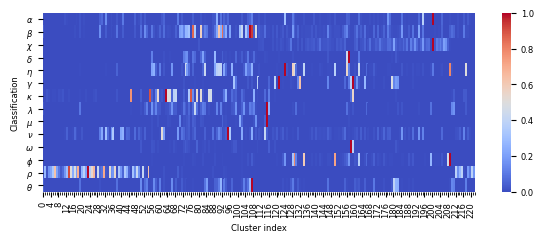

In [875]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True)[new_cluster_order], xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
# # ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 6)
# ax.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="out")

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())

classes_names = class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True).index.values
ax.set_yticklabels([r"$\{}$".format(c) for c in classes_names])

# offset = ScaledTranslation(0.5, 0, ax.transData)

# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)
    
# for label in ax.xaxis.get_minorticklabels():
#     label.set_transform(label.get_transform() + offset)

plt.xlabel("Cluster index")
plt.ylabel("Classification")

# plt.title("Gaussian mixture components' populations in terms of classified data (component-wise min-maxed)")
# plt.savefig("figures/GMM122vsBelloni_heatmap.png", dpi=300)
# plt.savefig('figures/GMM222merged_vsBelloni_heatmap_sorted.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()

In [90]:
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega"])
scales = []
segment_class = []
for ob in seg_ObIDs:
    if ob in ob_state:
        if ob == "10258-01-10-00":
            segment_class.append("mu")
        else:
            segment_class.append(ob_state[ob])
    else:
        segment_class.append("Unknown")

In [91]:
new_classification = merge_gaussian_component_labels(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 0)

Belloni_classes = np.array(["alpha", "beta", "gamma", "delta", "theta", "kappa", "lambda", "mu", "nu", "rho", "phi", "chi", "eta", "omega", "Unknown"])

comparison_matrix = np.zeros((len(np.unique(new_classification)), len(Belloni_classes)), dtype=int)

comparison_matrix_df = pd.DataFrame(comparison_matrix, columns=Belloni_classes, index=np.unique(new_classification))

for n_Bc, Belloni_class in enumerate(Belloni_classes):
    Belloni_class_indices = np.where(np.array(segment_class) == Belloni_class)[0]
    count_clusters_for_class = np.unique(np.take(new_classification, Belloni_class_indices), return_counts=True)
    for cluster_ind, cluster in enumerate(count_clusters_for_class[0]):
        comparison_matrix_df[Belloni_class][cluster] = count_clusters_for_class[1][cluster_ind]

In [92]:
class_normalized_comparison_matrix_df=(comparison_matrix_df-comparison_matrix_df.min())/(comparison_matrix_df.max()-comparison_matrix_df.min())
known_comparison_matrix_df = comparison_matrix_df.drop(columns=['Unknown']).T
component_normalized_comparison_matrix_df = (known_comparison_matrix_df-known_comparison_matrix_df.min())/(known_comparison_matrix_df.max()-known_comparison_matrix_df.min())

In [93]:
merged_components  = merge_gaussian_return_component_sets(GM_comp_mahal_distances_1s, GMmodel_1s_labels, 3.59)

In [94]:
np.unique(merged_components).shape

(8,)

In [100]:
class_normalized_comparison_matrix_df.T.columns.values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [102]:
comp_indices

{'178', '198'}

In [ ]:
cluster_centroids = []
centroid_distances=[]
for component in class_normalized_comparison_matrix_df.T.columns.values:
    cluster_centroids.append(GMmodel_1s.means_[component])
for comp_indices in merged_components:
    cluster_centroids[] = np.mean(np.take(GMmodel_1s.means_,list(comp_indices),axis=0),axis=0)
for centroid in cluster_centroids:
    centroid_distances.append(np.sqrt(np.mean((centroid-np.ones(24))**2)))
order_columns = np.take(class_normalized_comparison_matrix_df.T.columns.values, np.argsort(centroid_distances))

In [95]:
cluster_centroids = []
centroid_distances=[]
for component in class_normalized_comparison_matrix_df.T.columns.values:
    cluster_centroids.append(GMmodel_1s.means_[component])
for comp_indices in merged_components:
    cluster_centroids.append(np.mean(np.take(GMmodel_1s.means_,list(comp_indices),axis=0),axis=0))
for centroid in cluster_centroids:
    centroid_distances.append(np.sqrt(np.mean((centroid-np.ones(24))**2)))
order_columns = np.take(class_normalized_comparison_matrix_df.T.columns.values, np.argsort(centroid_distances))

IndexError: index 228 is out of bounds for axis 0 with size 222

In [96]:
len(cluster_centroids)

230

In [45]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn import datasets
import scipy.cluster.hierarchy as sch

import matplotlib.pyplot as plt
def seriation(Z,N,cur_index):
    '''
    https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
    https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = sch.linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
#     seriated_dist = np.zeros((N,N))
#     a,b = np.triu_indices(N,k=1)
#     seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
#     seriated_dist[b,a] = seriated_dist[a,b]
    
    return res_order

In [ ]:
no_components = len(cluster_centroids)
GM_comp_euclid_distances = np.zeros((no_components,no_components))
for comp1_ind, comp1 in enumerate(cluster_centroids):
    for comp2_ind, comp2 in enumerate(cluster_centroids):
        GM_comp_euclid_distances[comp1_ind, comp2_ind] = distance.euclidean(comp1, comp2)
        print(comp1_ind, comp2_ind)
        clear_output(wait=True)

74 108


In [84]:
new_cluster_order  = compute_serial_matrix(GM_comp_euclid_distances,method="single") 
new_cluster_order= np.take(class_normalized_comparison_matrix_df.T.columns.values, new_cluster_order)

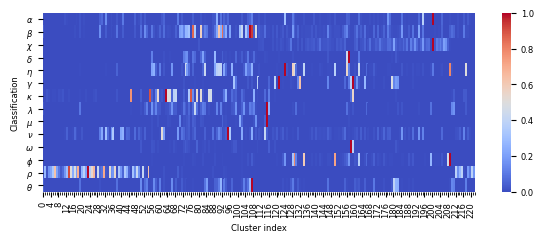

In [414]:
plt.rcParams['figure.figsize'] = (6.97, 6.97*(1/3))
plt.rcParams.update({'font.size': 6})

import seaborn as sns

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from matplotlib.transforms import ScaledTranslation

ax = sns.heatmap(class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True)[new_cluster_order], xticklabels=True, yticklabels=True, cmap='coolwarm')#, linewidth=0.5)
# # ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 6)
# ax.tick_params(axis="x", which="major", length=2, width=0.75, labelsize=6, direction="out")

ax.xaxis.set_major_locator(MultipleLocator(4))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

# For the minor ticks, use no labels; default NullFormatter.
# ax.xaxis.set_minor_locator(MultipleLocator(1.5))
ax.xaxis.set_minor_locator(AutoMinorLocator())

classes_names = class_normalized_comparison_matrix_df.T.iloc[:-1,:].sort_index(ascending=True).index.values
ax.set_yticklabels([r"$\{}$".format(c) for c in classes_names])

# offset = ScaledTranslation(0.5, 0, ax.transData)

# for label in ax.xaxis.get_majorticklabels():
#     label.set_transform(label.get_transform() + offset)
    
# for label in ax.xaxis.get_minorticklabels():
#     label.set_transform(label.get_transform() + offset)

plt.xlabel("Cluster index")
plt.ylabel("Classification")

# plt.title("Gaussian mixture components' populations in terms of classified data (component-wise min-maxed)")
# plt.savefig("figures/GMM122vsBelloni_heatmap.png", dpi=300)
# plt.savefig('figures/GMM222merged_vsBelloni_heatmap_sorted.png', dpi=300, bbox_inches = 'tight',pad_inches = 0)

plt.show()

# redoing 4s classification with fixed mu/lambda

In [1]:
%load_ext autoreload
%autoreload 2
from IPython.display import clear_output
import os
import fnmatch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
# import umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from  sklearn.ensemble import RandomForestClassifier
from scipy import stats
# from sklearn.cluster import OPTICS
from copy import deepcopy

from scipy.stats import zscore
from scipy.spatial import distance


plt.rcParams['figure.figsize'] = (5.0, 5.0)
plt.rcParams.update({'font.size': 12})
plt.rcParams.update(plt.rcParamsDefault)

np.random.seed(seed=11)


cwd = os.getcwd()

if cwd.split("/")[1] == "export":
    data_dir = "../../../files_from_snuffy"
else:
    data_dir = "../../../data_GRS1915"


In [9]:
def merge_gaussian_component_labels(distance_matrix, observation_labels, sigma_threshold):
    """
        if mahalanobis distance between Gaussian components is smaller than the sigma_threshold, relabel the data within
    those components as belonging to a new, single cluster
    
    input:
        distance_matrix - square matrix containing distances between Gaussian component means, output of component_mahalanobis_distances function
        observation_labels - list of data labels corresponding to the Gaussian components
        sigma_threshold - threshold for the merger of Gaussian components. If distances between two component means are less then the threshold,
        (both when calculating from A to B and from B to A), the components will be treated as one cluster.
                            
    output
        new_observation_labels - modified observation_labels, where a new index was created for merged components, and both component indices were
        replaced with that new index
    

    uses the graph solution from https://stackoverflow.com/questions/4842613/merge-lists-that-share-common-elements
    """
    # find pairs of components whose means are separated by mahalanobis distance smaller than the threshold (both ways)
    couples = np.array(np.where(((np.triu(distance_matrix)<sigma_threshold)&(np.triu(distance_matrix)>0))
      &(np.triu(distance_matrix.T)<sigma_threshold)&(np.triu(distance_matrix.T)>0))).T
    
    # build a graph of connections
    l = []
    for couple in couples:
        l.append([str(c) for c in couple])
    import networkx 
    from networkx.algorithms.components.connected import connected_components
    def to_graph(l):
        G = networkx.Graph()
        for part in l:
            # each sublist is a bunch of nodes
            G.add_nodes_from(part)
            # it also imlies a number of edges:
            G.add_edges_from(to_edges(part))
        return G
    def to_edges(l):
        """ 
            treat `l` as a Graph and returns it's edges 
            to_edges(['a','b','c','d']) -> [(a,b), (b,c),(c,d)]
        """
        it = iter(l)
        last = next(it)

        for current in it:
            yield last, current
            last = current    
    G = to_graph(l)

    new_observation_labels = observation_labels
    # merge components
    for n_connection, connection in enumerate(connected_components(G)):
        node_indices=np.array([int(node) for node in connection])
#         new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
#                                           n_connection+np.unique(observation_labels).shape[0], new_observation_labels)
        new_observation_labels = np.where(np.isin(new_observation_labels, node_indices),
                                          node_indices[0], new_observation_labels)
        
    return new_observation_labels

def grid_search_classification(data_labels, data, train_set_ids, val_set_ids, seg_ObIDs):
    """
    prepare representations of observations based on their make up in terms of Gaussian mixture component contributions.
    test the representation as the feature set for classification task
    """
    
#     comp=GMmodel.means_.shape[0]
    
    # find GMM component labels for data
    data_GMMcomp_labels = data_labels
    
    # make a dict that groups indices of segments of the same observation 
    # i.e. where each observation id can be found in seg_ObIDs
    #i.e. ObID_SegIndices_dict == {'10258-01-01-00': [916, 949, 1046...467528, 467578], ....}
    ObID_SegIndices_dict = {key:[] for key in np.unique(seg_ObIDs)}
    for ID_index, ObID in enumerate(seg_ObIDs):
        ObID_SegIndices_dict.setdefault(ObID, []).append(ID_index)
    
    # make a dictionary of Gaussian component labels instead of segment indices  
    #i.e. ObID_GaussComps_dict_comp == {'10258-01-01-00': [401, 433, 382...101, 152], ....}
    ObID_GaussComps_dict_comp = {}
    for ObID, Indices in ObID_SegIndices_dict.items():
        ObID_GaussComps_dict_comp[ObID] = [data_GMMcomp_labels[ind] for ind in Indices]
        
    # make a data frame containing the counts of light curve segments in each of the Gaussian components, for each observation
    obs_component_counts_df_comp = pd.DataFrame(np.zeros((len(ObID_GaussComps_dict_comp),len(np.unique(data_GMMcomp_labels)))),
                                               index=np.unique(seg_ObIDs), columns=np.unique(data_GMMcomp_labels), dtype=int)
        
    # populate the data frame
    for ObID, GaussComps in ObID_GaussComps_dict_comp.items():
        for comp_id, comp_count in np.array(np.unique(GaussComps, return_counts=True)).T:
            obs_component_counts_df_comp.loc[ObID][comp_id] = comp_count
    
    
    obs_component_counts_df_comp = obs_component_counts_df_comp.iloc[:,:].div(np.sum(obs_component_counts_df_comp.iloc[:,:], axis=1), axis="rows") # normalise rows
    
    # add classification column
    obs_component_counts_df_comp["Class"] = "Unknown" 
    for k,v in ob_state.items():
        if v == "eta": v = "Unknown" ##################################### remove eta classifications, there are only two in the set of 1738 observations
        if str(k) in obs_component_counts_df_comp.index.values:
            obs_component_counts_df_comp.loc[str(k), "Class"] = v
            
    obs_component_counts_df_comp.loc["10258-01-10-00", "Class"] = "mu"

    
    # training data
    train_data = obs_component_counts_df_comp.loc[train_set_ids].loc[obs_component_counts_df_comp.loc[train_set_ids].iloc[:,-1] != "Unknown"]  
    # validation data
    val_data = obs_component_counts_df_comp.loc[val_set_ids].loc[obs_component_counts_df_comp.loc[val_set_ids].iloc[:,-1] != "Unknown"]
            
    #random forest hyperparameters
#     n_estimators_list = [50, 100, 300, 500] # 100
    max_depth_list = [None, 5, 10, 15, 25] # None
#     min_samples_split_list = [2, 5, 10, 15] # 2
#     min_samples_leaf_list = [1, 2, 5, 10] # 1   
    criterion_list= ["entropy", 'gini']

    reports = []
    
    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for random_state in range(100):
                RF_clf = RandomForestClassifier(random_state=random_state,
                                                criterion=criterion,
                                                class_weight="balanced",
                                                n_estimators=100,
                                                max_depth=max_depth, 
                                                min_samples_split= 2,
                                                min_samples_leaf = 1,
                                                n_jobs=35
                                               ).fit(train_data.iloc[:,:-1], train_data.iloc[:,-1])
                preds = RF_clf.predict(val_data.iloc[:,:-1])

                reports.append((precision_recall_fscore_support(val_data.iloc[:,-1], preds, zero_division=0, average="weighted")[2],
                                accuracy_score(val_data.iloc[:,-1], preds),
                               (criterion,max_depth, random_state)))
    return reports

In [2]:
clean_belloni = open('{}/1915Belloniclass_updated.dat'.format(data_dir))
lines = clean_belloni.readlines()
states = lines[0].split()
belloni_clean = {}
for h,l in zip(states, lines[1:]):
    belloni_clean[h] = l.split()
    #state: obsID1, obsID2...
ob_state = {}
for state, obs in belloni_clean.items():
    if state == "chi1" or state == "chi2" or state == "chi3" or state == "chi4": state = "chi"
    for ob in obs:
        ob_state[ob] = state

        
# inverse the ob_state dictionary, so that inv_ob_state contains {"state name" : [list of observation IDs], ...}

inv_ob_state = {}
for k, v in ob_state.items():
    inv_ob_state[v] = inv_ob_state.get(v, [])
    inv_ob_state[v].append(k)

In [3]:
with open('{}/lightcurve1738_train70_val10_test20.pkl'.format(data_dir), 'rb') as f:
    split_ob_ids = pickle.load(f)

In [4]:
# Load Gaussian mixture model which produced the minimum BIC with 1 second cadence data
with open("{}/GMM_279comps_model_2020-12-21_20-11-39_segments_468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl".format(data_dir), 'rb') as f:
    GMmodel_4s = pickle.load(f)

In [5]:
# load light curve segments
with open('{}/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'.format(data_dir), 'rb') as f:
    segments_counts = pickle.load(f)
    
# load latent variables for light curve segments
weights_dir = "../../../model_weights/model_2020-12-21_20-11-39.h5"
segments_dir = '../../../data_GRS1915/468202_len128_stride8_4sec_cad_countrates_sum_bin.pkl'
segment_encoding_dir = '{}/segment_encoding_{}_segments_{}.pkl'.format(data_dir, weights_dir.split("/")[-1].split(".")[0], segments_dir.split("/")[-1].split(".")[0])
with open(segment_encoding_dir, 'rb') as f:
    segment_encoding = pickle.load(f)

# take latent variable means, i.e. 16 values per segment
segment_encoding_scaled_means = zscore(segment_encoding[:,0,:], axis=0).astype(np.float32)  # standardize per feature

# calculate statistical moments for the segments
desc_stats = np.zeros((len(segments_counts), 4)) #mean, std, skew, kurt
desc_stats[:,0] = np.mean(segments_counts, axis=1).flatten()
desc_stats[:,1] = np.std(segments_counts, axis=1).flatten()
desc_stats[:,2] = stats.skew(segments_counts, axis=1).flatten()
desc_stats[:,3] = stats.kurtosis(segments_counts, axis=1).flatten()
zscore_desc_stats = zscore(desc_stats, axis=0)

# merge the two types of features; shape of shape_moments is [474471, 24]
shape_moments = np.hstack((segment_encoding_scaled_means, zscore_desc_stats)) # every column is standardized

In [6]:
GMmodel_4s_labels = GMmodel_4s.predict(shape_moments)

In [8]:
# calculate mahalanobis distances between components
GM_comp_mahal_distances_4s = component_mahalanobis_distances(GMmodel_4s)

# with open("GM_comp_mahal_distances_4s.pkl", 'wb') as f:
#     pickle.dump(GM_comp_mahal_distances_4s, f)

276 235


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
with open("GM_comp_mahal_distances_4s.pkl".format(data_dir), 'rb') as f:
    GM_comp_mahal_distances_4s = pickle.load(f)

In [8]:
with open('{}/468202_len128_stride8_4sec_cad_ids_sum_bin.pkl'.format(data_dir), 'rb') as f:
    seg_ids = pickle.load(f)
seg_ObIDs = [seg.split("_")[0] for seg in seg_ids] # get rid of the within-observation segment indices and create a degenerate list of observation IDs

In [ ]:
no_components_premerger = np.unique(GMmodel_4s_labels).shape[0]

sigma_reports_list = []

for sigma_threshold in np.linspace(1.5,5,100):
    data_labels = merge_gaussian_component_labels(GM_comp_mahal_distances_4s, GMmodel_4s_labels, sigma_threshold)
    if (np.unique(data_labels).shape[0] < no_components_premerger) or len(sigma_reports_list)==0:
        no_components_premerger = np.unique(data_labels).shape[0]
        reports = grid_search_classification(data_labels, shape_moments, split_ob_ids[0], split_ob_ids[1], seg_ObIDs)
        sigma_reports_list.append((sigma_threshold, reports))
        print(len(sigma_reports_list), sigma_threshold)
        clear_output(wait=True)
        
with open("sigmas100_reports_list_4s_100rng_criterion_depth_fixed_mergers_fixed_mulambda2.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)

17 2.9494949494949494


In [14]:
rng_iterations= 100
treshold_avg_reports=[]
for threshold, report_list in sigma_reports_list:
    average_reports = []
    for set_i in range(int(len(report_list)/rng_iterations)):
        avg_f1=0
        avg_ac=0
        for rng_i in range(rng_iterations):
            avg_f1 += report_list[rng_i+(set_i*rng_iterations)][0]
            avg_ac += report_list[rng_i+(set_i*rng_iterations)][1]
        average_reports.append((avg_f1/rng_iterations,avg_ac/rng_iterations,(report_list[set_i*rng_iterations][2])))
    treshold_avg_reports.append((threshold,average_reports))

In [15]:
best_f1 = 0
best_result = []
for threshold, report_list in treshold_avg_reports:
    for report in report_list:
        if report[0] > best_f1:
            best_f1 = report[0]
            best_result = [threshold, report]
best_result

[3.8686868686868685, (0.697826824690461, 0.7586363636363636, ('gini', 5, 0))]

In [ ]:
with open("sigmas100_reports_list_4s_100rng_criterion_depth_fixed_mergers_fixed_mulambda2.pkl", 'wb') as f:
    pickle.dump(sigma_reports_list, f)